# **__Emotional Patterns in Text for Deeper Context (Amazon Reviews Dataset)__**
* We use BERT to give sentiment scores.
* NRCLex is used for giving emotions corresponding to each review
* BERT embeddings are used for reviews, we compate 768 (CLS), 1536 (CLS + Mean Pooling) embeddings
* We find weak correlations with emotional patterns which may be useful in finginf helpfulness (buyer's perspective as well as seller's perspective)
* We then go on to use emotional patterns to create embeddings. For this we use feature imprtance extracted through random forest regression.
* We find correlation with emotion socres which are extracted through NRCLex. We therefore create an embedding with this also.

* Results - improved embeddings to find helpful reviews


## Basic Data Loading 

In [ ]:
#!pip3 install pandas
#!pip3 install textblob
#!pip3 install matplotlib
#!pip3 install -U scikit-learn scipy matplotlib
#!pip3 install seaborn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textblob
from scipy.spatial.distance import cdist
import seaborn as sns
import nltk
import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
from textblob import TextBlob

In [ ]:
#import json
#num_lines_to_read = 7000 # Initialize a counter for the lines read
#lines_read = 0 # Initialize an empty list to store the data
#data_list_json = []
#with open('reviews_Books_5.json', 'r') as file:
#    for line in file:
#        if lines_read < num_lines_to_read:
#            dataj = json.loads(line)
#            data_list_json.append(dataj)
#           lines_read += 1
#       else:
#           break     
#data_amazon_json = pd.DataFrame(data_list_json)
#data_amazon_json.head()
#result = data_amazon_json[data_amazon_json['helpful'].apply(lambda x:  (x[0]==x[1])&(x[0]!=0))]
#result.to_json('data_amazon_json.json')
#data_amazon_json_df = pd.concat([data_amazon_json, data_amazon_json['reviewText'].apply(return_emopattern)], axis=1)
#data_amazon_json_df.to_csv('data_amazon_json_df.csv')

In [ ]:
data_amazon_json_df = pd.read_csv('data_amazon_json_df.csv')

In [ ]:
data_amazon_json_df.head()

Unnamed: 0             reviewerID        asin  \
0           0  A10000012B7CGYKOMPQ4L  000100039X   
1           1         A2S166WSCFIFP5  000100039X   
2           2         A1BM81XB4QHOA3  000100039X   
3           3         A1MOSTXNIO5MPJ  000100039X   
4           4         A2XQ5LZHTD4AFT  000100039X   

                                      reviewerName helpful  \
0                                             Adam  [0, 0]   
1  adead_poet@hotmail.com "adead_poet@hotmail.com"  [0, 2]   
2                      Ahoro Blethends "Seriously"  [0, 0]   
3                                        Alan Krug  [0, 0]   
4                                         Alaturka  [7, 9]   

                                          reviewText  overall  \
0  Spiritually and mentally inspiring! A book tha...      5.0   
1  This is one my must have books. It is a master...      5.0   
2  This book provides a reflection that you can a...      5.0   
3  I first read THE PROPHET in college back in th...      5.0   
4  A timeless classic.  It is a very demanding an...      5.0   

                                             summary  unixReviewTime  \
0                                         Wonderful!      1355616000   
1                                       close to god      1071100800   
2                    Must Read for Life Afficianados      1390003200   
3  Timeless for every good and bad time in your l...      1317081600   
4                                      A Modern Rumi      1033948800   

    reviewTime  emopattern  emoscore  
0  12 16, 2012         spn  0.091968  
1  12 11, 2003      sppppn  0.603524  
2  01 18, 2014          sp  0.092623  
3  09 27, 2011   snnppnpnp  0.169401  
4   10 7, 2002  spnppnpnpp  0.097563

## Defining Emo Pattern Function

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
bert_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
def polarity(val):
    if val >= 0:
        return 'p'
    else:
        return 'n'

def return_sentiment(txt):  # returning single-sentence BERT score
    encoded_input = tokenizer(txt, return_tensors='pt',padding=True,truncation=True)
    output = bert_model(**encoded_input)
    score = output[0][0].detach().numpy() 
    scores = softmax(score)
    if scores[2] > scores[0]: 
        return pd.Series({'emopattern_str': 'p','senti_score':scores[2]})#this is positive
    else:
        return pd.Series({'emopattern_str': 'n','senti_score':scores[0]}) # this is negative
        #converts prob to + or - polarities

In [ ]:
# find emotional pattern
def return_emopattern(text):
    emosenti='s'
    blob = TextBlob(text)
    # Access the sentences using the `sentences` attribute
    sentences = blob.sentences
    for sen in sentences:
        temp = return_sentiment(str(sen))
        emosenti = emosenti + temp['emopattern_str']
        emoscore = temp['senti_score']
    s_pattern = pd.Series({'emopattern': emosenti,'emoscore':emoscore})
    return s_pattern

In [ ]:
data_amazon_json_df_pat = pd.concat([data_amazon_json_df, data_amazon_json_df['emopattern'].apply(return_pattern_match)], axis=1)

In [ ]:
data_amazon_json_df_pat.to_csv('data_amazon_json_df_pat.csv')

In [ ]:
data_amazon_json_df_pat = data_amazon_json_df_pat.fillna(0)

In [4496]:
%%time
return_emopattern(data_amazon['review'].iloc[25])

CPU times: user 393 ms, sys: 232 ms, total: 625 ms
Wall time: 527 ms


emopattern      snnnnp
emoscore      0.086741
dtype: object

In [ ]:
data_amazon_json_df_pat[pattern_list]

npn  pnp  nppn  pnnp  nnppnn  ppnnpp  ppn  nnp  nnn  ppp
0       0    0     0     0       0       0    0    0    0    0
1       0    0     0     0       0       0    1    0    0    1
2       0    0     0     0       0       0    0    0    0    0
3       1    1     1     0       0       0    1    1    0    0
4       1    2     1     0       0       0    1    0    0    0
...   ...  ...   ...   ...     ...     ...  ...  ...  ...  ...
6995    0    0     0     0       0       0    0    0    0    0
6996    0    0     0     0       0       0    0    0    0    0
6997    0    0     0     0       0       0    0    0    0    0
6998    1    0     0     0       0       0    1    1    1    1
6999    2    3     1     0       0       0    3    0    0    2

[7000 rows x 10 columns]

In [ ]:
def convert_to_int(x):
    try:
        result = int(x)
        return result
    except ValueError:
        return 0
def find_helpfulness(x):
    if convert_to_int(x[4]) == 0:
        return 0
    elif (convert_to_int(x[1])/convert_to_int(x[4]) >= .5) :
        return 1
    else:
        return -1

In [ ]:
result = data_amazon_json_df_pat['helpful'].apply(lambda x : find_helpfulness(x))

In [ ]:
result.value_counts()

helpful
 1    3327
 0    2325
-1    1348
Name: count, dtype: int64

In [ ]:
data_amazon_json_df_pat['helpfulness'] = result

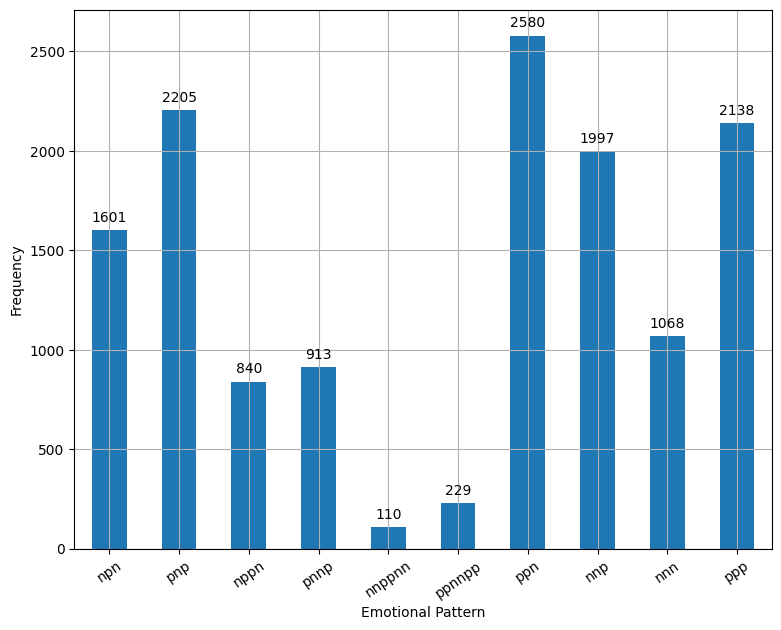

In [ ]:
data_analysis_json = pd.DataFrame(data_amazon_json_df_pat[pattern_list][data_amazon_json_df_pat['helpfulness']>0].sum())
data_analysis2 = data_analysis_json.reset_index()
df_patt2 = data_analysis2.rename(columns={'index':'pattern',0:'freq'})
ax = df_patt2.plot(kind='bar', x='pattern', y='freq', figsize=(9,7),legend=False)
for p in ax.patches:
    ax.annotate(format(p.get_height(), ''), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.xticks(rotation=35)
plt.grid(True)
plt.xlabel('Emotional Pattern')
plt.ylabel('Frequency')
plt.show()

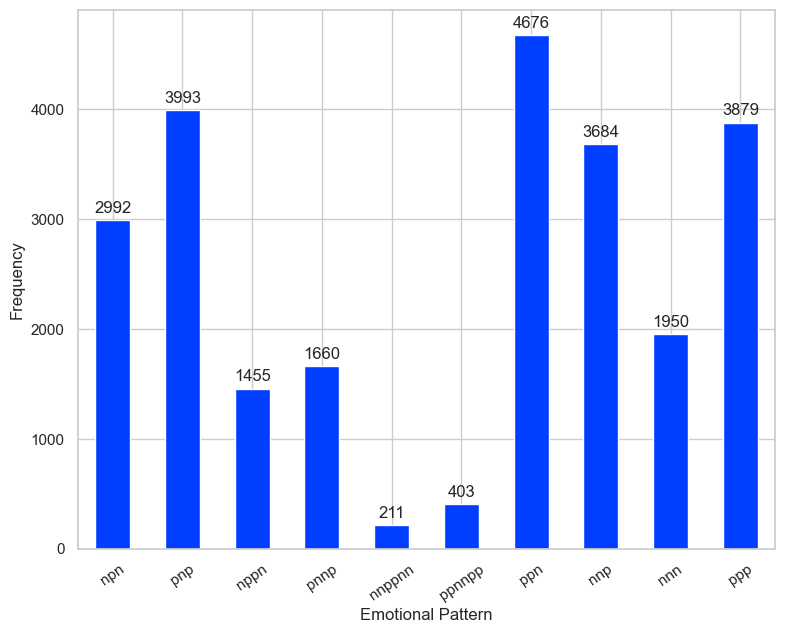

In [4201]:
sns.color_palette('bright')
data_analysis_json = pd.DataFrame(data_amazon_json_df_pat[pattern_list].sum())
data_analysis2 = data_analysis_json.reset_index()
df_patt2 = data_analysis2.rename(columns={'index':'pattern',0:'freq'})
ax = df_patt2.plot(kind='bar', x='pattern', y='freq', figsize=(9,7),legend=False)
for p in ax.patches:
    ax.annotate(format(p.get_height(), ''), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.xticks(rotation=35)
plt.grid(True)
plt.xlabel('Emotional Pattern')
plt.ylabel('Frequency')
plt.show()

In [ ]:
for pat7 in pattern_list:
    data_amazon_json_df_pat[pat7] = data_amazon_json_df_pat[pat7].apply(lambda x : x) #1 if x>0 else 0)

In [ ]:
data_amazon_json_df_pat['total_patterns'] = data_amazon_json_df_pat[pattern_list].sum(axis=1)
                                    

In [ ]:
data_amazon_json_df_pat['total_patterns'] = data_amazon_json_df_pat['total_patterns'].apply(lambda x : x )#1 if x > 0 else 0)

In [ ]:
pattern_list_helpful = pattern_list+ ['helpfulness'] + ['total_patterns']

In [ ]:
pattern_list_helpful

['npn',
 'pnp',
 'nppn',
 'pnnp',
 'nnppnn',
 'ppnnpp',
 'ppn',
 'nnp',
 'nnn',
 'ppp',
 'helpfulness',
 'total_patterns']

In [ ]:
data_amazon_json_df_pat[pattern_list_helpful].corr()

npn       pnp      nppn      pnnp    nnppnn    ppnnpp  \
npn             1.000000  0.669033  0.441619  0.575712  0.228057  0.203393   
pnp             0.669033  1.000000  0.597651  0.434955  0.170382  0.264860   
nppn            0.441619  0.597651  1.000000  0.510538  0.508960  0.421238   
pnnp            0.575712  0.434955  0.510538  1.000000  0.402211  0.607371   
nnppnn          0.228057  0.170382  0.508960  0.402211  1.000000  0.359830   
ppnnpp          0.203393  0.264860  0.421238  0.607371  0.359830  1.000000   
ppn             0.512673  0.757931  0.746416  0.600400  0.372949  0.533457   
nnp             0.706174  0.471557  0.553699  0.804807  0.473980  0.478160   
nnn             0.515148  0.311334  0.368632  0.287585  0.353086  0.182400   
ppp             0.353902  0.551173  0.284302  0.423210  0.155433  0.423602   
helpfulness     0.094402  0.117765  0.105954  0.088898  0.033793  0.057895   
total_patterns  0.763945  0.793447  0.724051  0.755221  0.447623  0.545394   

                     ppn       nnp       nnn       ppp  helpfulness  \
npn             0.512673  0.706174  0.515148  0.353902     0.094402   
pnp             0.757931  0.471557  0.311334  0.551173     0.117765   
nppn            0.746416  0.553699  0.368632  0.284302     0.105954   
pnnp            0.600400  0.804807  0.287585  0.423210     0.088898   
nnppnn          0.372949  0.473980  0.353086  0.155433     0.033793   
ppnnpp          0.533457  0.478160  0.182400  0.423602     0.057895   
ppn             1.000000  0.629236  0.419163  0.673402     0.122950   
nnp             0.629236  1.000000  0.664101  0.451520     0.105758   
nnn             0.419163  0.664101  1.000000  0.288870     0.089378   
ppp             0.673402  0.451520  0.288870  1.000000     0.107695   
helpfulness     0.122950  0.105758  0.089378  0.107695     1.000000   
total_patterns  0.892122  0.853642  0.606839  0.693459     0.135540   

                total_patterns  
npn                   0.763945  
pnp                   0.793447  
nppn                  0.724051  
pnnp                  0.755221  
nnppnn                0.447623  
ppnnpp                0.545394  
ppn                   0.892122  
nnp                   0.853642  
nnn                   0.606839  
ppp                   0.693459  
helpfulness           0.135540  
total_patterns        1.000000

In [ ]:
for_corr = data_amazon_json_df_pat.query('helpfulness == 1 | helpfulness ==-1')

In [ ]:
for_corr[pattern_list_helpful]

npn  pnp  nppn  pnnp  nnppnn  ppnnpp  ppn  nnp  nnn  ppp  helpfulness  \
1       0    0     0     0       0       0    1    0    0    1           -1   
4       1    2     1     0       0       0    1    0    0    0            1   
14      2    1     0     0       0       0    0    1    1    0            1   
15      0    0     0     0       0       0    0    0    0    1            1   
17      0    1     1     0       0       0    1    0    0    0            1   
...   ...  ...   ...   ...     ...     ...  ...  ...  ...  ...          ...   
6984    0    0     0     0       0       0    0    0    0    0            1   
6989    0    0     0     0       0       0    0    1    0    0            1   
6992    1    1     0     0       0       0    0    0    0    1            1   
6993    0    0     1     0       1       0    1    1    1    0            1   
6999    2    3     1     0       0       0    3    0    0    2            1   

      total_patterns  
1                  2  
4                  5  
14                 5  
15                 1  
17                 3  
...              ...  
6984               0  
6989               1  
6992               3  
6993               5  
6999              11  

[4675 rows x 12 columns]

In [ ]:
for_corr['helpfulness'] = for_corr['helpfulness'].apply(lambda x : 1 if x>=1 else 0)

In [ ]:
corr_data = for_corr[pattern_list_helpful].corr()

In [ ]:
corr_data['helpfulness']

npn               0.129586
pnp               0.151642
nppn              0.137313
pnnp              0.119509
nnppnn            0.053035
ppnnpp            0.077031
ppn               0.160052
nnp               0.143661
nnn               0.117297
ppp               0.133900
helpfulness       1.000000
total_patterns    0.180146
Name: helpfulness, dtype: float64

In [ ]:
len(data_amazon_json_df_pat.query('total_patterns==0 & helpfulness==1')) / len(data_amazon_json_df_pat.query('total_patterns==0'))

0.3609271523178808

In [ ]:
len(data_amazon_json_df_pat.query('npn==1 & helpfulness==1')) / len(data_amazon_json_df_pat.query('npn==1'))

0.518494484101233

In [ ]:
len(data_amazon_json_df_pat.query('total_patterns==1 & helpfulness==1')) / len(data_amazon_json_df_pat.query('helpfulness==1'))

0.21280432822362488

In [ ]:
len(data_amazon_json_df_pat.query('total_patterns==0 & helpfulness==1')) / len(data_amazon_json_df_pat.query('helpfulness==1'))

0.1638112413585813

In [ ]:
len(data_amazon_json_df_pat.query('npn==1 & helpfulness==1')) / len(data_amazon_json_df_pat.query('helpfulness==1'))

0.24015629696423205

In [ ]:
len(data_amazon_json_df_pat.query('pnp==1 & helpfulness==1')) / len(data_amazon_json_df_pat.query('helpfulness==1'))

0.306883077847911

In [ ]:
len(data_amazon_json_df_pat.query('nnn==1 & helpfulness==1')) / len(data_amazon_json_df_pat.query('helpfulness==1'))

0.19056206792906522

In [ ]:
len(data_amazon_json_df_pat.query('ppp==1 & helpfulness==1')) / len(data_amazon_json_df_pat.query('helpfulness==1'))

0.3047790802524797

In [ ]:
len(data_amazon_json_df_pat.query('npn==1 & helpfulness==1')) / len(data_amazon_json_df_pat.query('npn==1'))

0.518494484101233

In [ ]:
len(data_amazon_json_df_pat.query('npn==0 & helpfulness==1')) / len(data_amazon_json_df_pat.query('npn==0'))

0.4531758957654723

In [ ]:
len(data_amazon_json_df_pat.query('pnp==1 & helpfulness==1')) / len(data_amazon_json_df_pat.query('pnp==1'))

0.5238583889173936

In [ ]:
len(data_amazon_json_df_pat.query('pnp==0 & helpfulness==1')) / len(data_amazon_json_df_pat.query('pnp==0'))

0.43475226796929517

In [ ]:
percent_pat=[]
for pat8 in pattern_list:
    percent_pat.append({pat8+str('_helpful%'): len(data_amazon_json_df_pat.query(f"{pat8}=={1} and {'helpfulness'}==1"))  / len(data_amazon_json_df_pat.query(f"{'helpfulness'}=={1}"))})

In [ ]:
percent_pat

[{'npn_helpful%': 0.24015629696423205},
 {'pnp_helpful%': 0.306883077847911},
 {'nppn_helpful%': 0.16140667267808836},
 {'pnnp_helpful%': 0.17793808235647732},
 {'nnppnn_helpful%': 0.030658250676284943},
 {'ppnnpp_helpful%': 0.0616170724376315},
 {'ppn_helpful%': 0.3095882176134656},
 {'nnp_helpful%': 0.26570483919446947},
 {'nnn_helpful%': 0.19056206792906522},
 {'ppp_helpful%': 0.3047790802524797}]

<Axes: xlabel='pnp'>

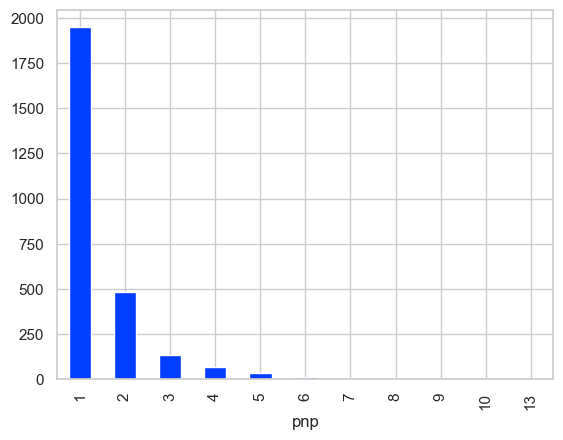

In [4196]:
data_amazon_json_df_pat['nnn'].value_counts().drop(0).plot(kind='bar')
data_amazon_json_df_pat['pnp'].value_counts().drop(0).plot(kind='bar')

In [4198]:
val_pats = data_amazon_json_df_pat[['nnn','ppp']].value_counts()

In [4200]:
val_pats.drop(0)

/var/folders/wc/3lttp9mx3ps_jqd1xzsfrct80000gn/T/ipykernel_80929/3558092018.py:1: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



nnn  ppp
1    0      729
     1      281
     2      105
2    0       94
     1       50
1    3       39
2    2       26
3    0       18
1    4       15
2    3       15
3    1       13
1    5       11
3    2        9
2    5        8
     4        7
4    0        6
3    3        6
2    6        5
4    1        5
1    6        5
5    6        4
4    2        4
3    7        3
4    3        3
3    8        3
     5        3
     6        3
     4        3
2    9        3
     10       2
4    6        2
5    3        2
     5        1
6    6        1
     4        1
     0        1
1    7        1
5    4        1
     1        1
4    10       1
     8        1
     4        1
6    7        1
Name: count, dtype: int64

In [ ]:
len(data_amazon_json_df_pat.query(f"{'total_patterns'}==1 and {'helpfulness==1'}"))

708

In [ ]:
len(data_amazon_json_df_pat.query(f"{'total_patterns'}==1 and {'helpfulness==-1'}"))

391

In [ ]:
len(data_amazon_json_df_pat.query(f"{'total_patterns'}==0 and {'helpfulness==1'}"))

545

In [ ]:
len(data_amazon_json_df_pat.query(f"{'total_patterns'}==0 and {'helpfulness==-1'}"))

420

In [ ]:
len(data_amazon_json_df_pat.query(f"{'total_patterns'}==1 and {'helpfulness==1'}"))/len(data_amazon_json_df_pat.query(f"{'helpfulness'}==1 or {'helpfulness==-1'}"))

0.1514438502673797

In [ ]:
len(data_amazon_json_df_pat.query(f"{'helpfulness'}==1 or {'helpfulness==-1'}"))

4675

In [ ]:
data_amazon_json_df_pat.query(f"{'total_patterns'}==1")['helpfulness'].value_counts()

helpfulness
 1    708
 0    509
-1    391
Name: count, dtype: int64

In [ ]:
relevant_helpfulness_df = data_amazon_json_df_pat.query(f"{'helpfulness'}==1 or {'helpfulness==-1'}")

In [ ]:
relevant_helpfulness_df['helpfulness'] = relevant_helpfulness_df['helpfulness'].apply(lambda x : 1 if x > 0 else 0)

In [ ]:
corr_json = relevant_helpfulness_df[pattern_list_helpful].corr()

In [ ]:
corr_json = corr_json.drop(columns='helpfulness')

<Axes: >

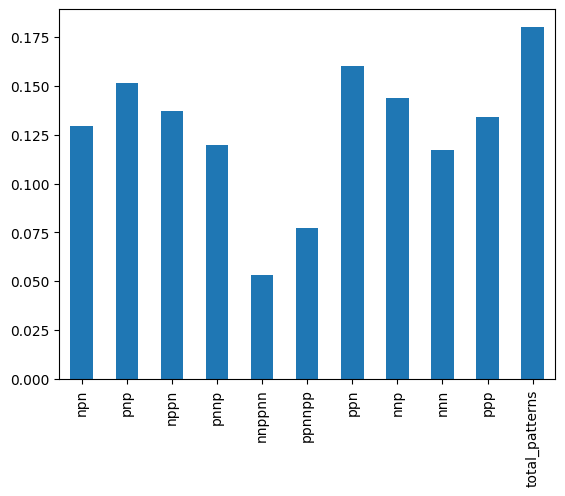

In [ ]:
corr_json.loc['helpfulness'].plot(kind='bar')

In [ ]:
relevant_helpfulness_df['helpfulness'].value_counts()

helpfulness
1    3327
0    1348
Name: count, dtype: int64

In [ ]:
# p(helpful)
len(relevant_helpfulness_df.query('helpfulness==1'))/len(relevant_helpfulness_df)

0.7116577540106952

In [ ]:
# p(not_helpful)
len(relevant_helpfulness_df.query('helpfulness==0'))/len(relevant_helpfulness_df)

0.2883422459893048

In [ ]:
# p(total_patterns)
len(relevant_helpfulness_df.query('total_patterns==1'))/len(relevant_helpfulness_df)

0.2350802139037433

In [ ]:
# p(not_total_patterns)
len(relevant_helpfulness_df.query('total_patterns==0'))/len(relevant_helpfulness_df)

0.20641711229946524

In [ ]:
# p(total_patterns/helpful)
len(relevant_helpfulness_df.query(f"{'helpfulness'}=={1} and {'total_patterns'}=={1}"))/len(relevant_helpfulness_df.query(f"{'helpfulness'}=={1}"))

0.21280432822362488

In [ ]:
# p(total_patterns/not_helpful)
len(relevant_helpfulness_df.query(f"{'helpfulness'}=={0} and {'total_patterns'}=={1}"))/len(relevant_helpfulness_df.query(f"{'helpfulness'}=={0}"))

0.2900593471810089

In [ ]:
# p(helpful/total_patterns)
len(relevant_helpfulness_df.query(f"{'helpfulness'}=={1} and {'total_patterns'}=={1}"))/len(relevant_helpfulness_df.query(f"{'total_patterns'}=={1}"))

0.6442220200181984

In [ ]:
# p(not_helpful/total_patterns)
len(relevant_helpfulness_df.query(f"{'helpfulness'}=={0} and {'total_patterns'}=={1}"))/len(relevant_helpfulness_df.query(f"{'total_patterns'}=={1}"))

0.35577797998180166

In [ ]:
# p(helpful/not_total_patterns)
len(relevant_helpfulness_df.query(f"{'helpfulness'}=={1} and {'total_patterns'}=={0}"))/len(relevant_helpfulness_df.query(f"{'total_patterns'}=={0}"))

0.5647668393782384

In [ ]:
# p(not_helpful/not_total_patterns)
len(relevant_helpfulness_df.query(f"{'helpfulness'}=={0} and {'total_patterns'}=={0}"))/len(relevant_helpfulness_df.query(f"{'total_patterns'}=={0}"))

0.43523316062176165

In [ ]:
# p(not_total_patterns/helpful)
len(relevant_helpfulness_df.query(f"{'helpfulness'}=={1} and {'total_patterns'}=={0}"))/len(relevant_helpfulness_df.query(f"{'helpfulness'}=={1}"))

0.1638112413585813

In [ ]:
# p(not_total_patterns/not_helpful)
len(relevant_helpfulness_df.query(f"{'helpfulness'}=={0} and {'total_patterns'}=={0}"))/len(relevant_helpfulness_df.query(f"{'helpfulness'}=={0}"))

0.3115727002967359

In [ ]:
percent_pat1=[]
for pat8 in pattern_list:
    percent_pat1.append({pat8+str('_helpful'): len(relevant_helpfulness_df.query(f"{pat8}>={1} and {'helpfulness'}==1"))  / len(relevant_helpfulness_df.query(f"{'helpfulness'}=={1}"))})
percent_pat1

[{'npn_helpful': 0.3309287646528404},
 {'pnp_helpful': 0.4382326420198377},
 {'nppn_helpful': 0.20018034265103696},
 {'pnnp_helpful': 0.21701232341448753},
 {'nnppnn_helpful': 0.03186053501653141},
 {'ppnnpp_helpful': 0.0652239254583709},
 {'ppn_helpful': 0.47249774571686204},
 {'nnp_helpful': 0.38473098887886986},
 {'nnn_helpful': 0.24256086564472498},
 {'ppp_helpful': 0.4277126540426811}]

In [ ]:
percent_pat1=[]
for pat8 in pattern_list:
    percent_pat1.append({pat8+str('_helpful'): len(relevant_helpfulness_df.query(f"{pat8}>={1} and {'helpfulness'}==1"))  / len(relevant_helpfulness_df.query(f"{'helpfulness'}=={1}"))})
percent_pat1

[{'npn_helpful': 0.3309287646528404},
 {'pnp_helpful': 0.4382326420198377},
 {'nppn_helpful': 0.20018034265103696},
 {'pnnp_helpful': 0.21701232341448753},
 {'nnppnn_helpful': 0.03186053501653141},
 {'ppnnpp_helpful': 0.0652239254583709},
 {'ppn_helpful': 0.47249774571686204},
 {'nnp_helpful': 0.38473098887886986},
 {'nnn_helpful': 0.24256086564472498},
 {'ppp_helpful': 0.4277126540426811}]

In [ ]:
percent_pat1=[]
for pat8 in pattern_list:
    percent_pat1.append({str('helpful_')+str('not_')+pat8: len(relevant_helpfulness_df.query(f"{pat8}=={0} and {'helpfulness'}==1"))  / len(relevant_helpfulness_df.query(f"{pat8}=={0}"))})
percent_pat1

[{'helpful_not_npn': 0.6731176292712429},
 {'helpful_not_pnp': 0.6585623678646935},
 {'helpful_not_nppn': 0.6826577732170344},
 {'helpful_not_pnnp': 0.6849855377333683},
 {'helpful_not_nnppnn': 0.7077565370248297},
 {'helpful_not_ppnnpp': 0.7033016734509272},
 {'helpful_not_ppn': 0.6519316493313522},
 {'helpful_not_nnp': 0.6637483787289234},
 {'helpful_not_nnn': 0.683853459972863},
 {'helpful_not_ppp': 0.6664333216660833}]

In [ ]:
percent_pat1=[]
for pat8 in pattern_list:
    for measure in range (0,data_amazon_json_df_pat[pat8].max()):
        percent_pat1.append([str('P(h/')+ pat8+str(')') ,str(measure), len(data_amazon_json_df_pat.query(f"{pat8}=={measure} and {'helpfulness'}==1"))  / len(data_amazon_json_df_pat.query(f"{pat8}=={measure}")) if len(data_amazon_json_df_pat.query(f"{pat8}=={measure}")) >0 else 0,len(data_amazon_json_df_pat.query(f"{pat8}=={measure} and {'helpfulness'}==1"))  , len(data_amazon_json_df_pat.query(f"{pat8}=={measure}"))])
        print(pat8)
        print(measure)
percent_pat1

npn
0
npn
1
npn
2
npn
3
npn
4
npn
5
npn
6
npn
7
npn
8
pnp
0
pnp
1
pnp
2
pnp
3
pnp
4
pnp
5
pnp
6
pnp
7
pnp
8
pnp
9
pnp
10
pnp
11
pnp
12
nppn
0
nppn
1
nppn
2
nppn
3
nppn
4
nppn
5
pnnp
0
pnnp
1
pnnp
2
pnnp
3
pnnp
4
pnnp
5
pnnp
6
nnppnn
0
nnppnn
1
ppnnpp
0
ppnnpp
1
ppnnpp
2
ppnnpp
3
ppn
0
ppn
1
ppn
2
ppn
3
ppn
4
ppn
5
ppn
6
ppn
7
ppn
8
ppn
9
ppn
10
ppn
11
ppn
12
ppn
13
ppn
14
nnp
0
nnp
1
nnp
2
nnp
3
nnp
4
nnp
5
nnp
6
nnp
7
nnp
8
nnp
9
nnp
10
nnp
11
nnp
12
nnn
0
nnn
1
nnn
2
nnn
3
nnn
4
nnn
5
ppp
0
ppp
1
ppp
2
ppp
3
ppp
4
ppp
5
ppp
6
ppp
7
ppp
8
ppp
9


[['P(h/npn)', '0', 0.4531758957654723, 2226, 4912],
 ['P(h/npn)', '1', 0.518494484101233, 799, 1541],
 ['P(h/npn)', '2', 0.5505952380952381, 185, 336],
 ['P(h/npn)', '3', 0.568, 71, 125],
 ['P(h/npn)', '4', 0.4791666666666667, 23, 48],
 ['P(h/npn)', '5', 0.6153846153846154, 16, 26],
 ['P(h/npn)', '6', 0.6666666666666666, 4, 6],
 ['P(h/npn)', '7', 0.3333333333333333, 1, 3],
 ['P(h/npn)', '8', 1.0, 2, 2],
 ['P(h/pnp)', '0', 0.43475226796929517, 1869, 4299],
 ['P(h/pnp)', '1', 0.5238583889173936, 1021, 1949],
 ['P(h/pnp)', '2', 0.577639751552795, 279, 483],
 ['P(h/pnp)', '3', 0.6044776119402985, 81, 134],
 ['P(h/pnp)', '4', 0.582089552238806, 39, 67],
 ['P(h/pnp)', '5', 0.6111111111111112, 22, 36],
 ['P(h/pnp)', '6', 0.4, 6, 15],
 ['P(h/pnp)', '7', 0.7142857142857143, 5, 7],
 ['P(h/pnp)', '8', 0.5, 3, 6],
 ['P(h/pnp)', '9', 0.5, 1, 2],
 ['P(h/pnp)', '10', 0.0, 0, 1],
 ['P(h/pnp)', '11', 0, 0, 0],
 ['P(h/pnp)', '12', 0, 0, 0],
 ['P(h/nppn)', '0', 0.45565068493150684, 2661, 5840],
 ['P(h/np

In [ ]:
percent_pat1=[]
for pat8 in ['total_patterns']: #pattern_list:
    for measure in range (0,data_amazon_json_df_pat[pat8].max()):
        percent_pat1.append([str('P(h/')+ pat8+str(')') ,str(measure), len(data_amazon_json_df_pat.query(f"{pat8}=={measure} and {'helpfulness'}==1"))  / len(data_amazon_json_df_pat.query(f"{pat8}=={measure}")) if len(data_amazon_json_df_pat.query(f"{pat8}=={measure}")) >0 else 0,len(data_amazon_json_df_pat.query(f"{pat8}=={measure} and {'helpfulness'}==1"))  , len(data_amazon_json_df_pat.query(f"{pat8}=={measure}"))])
percent_pat1

[['P(h/total_patterns)', '0', 0.3609271523178808, 545, 1510],
 ['P(h/total_patterns)', '1', 0.44029850746268656, 708, 1608],
 ['P(h/total_patterns)', '2', 0.48895292987512007, 509, 1041],
 ['P(h/total_patterns)', '3', 0.508695652173913, 351, 690],
 ['P(h/total_patterns)', '4', 0.5480349344978166, 251, 458],
 ['P(h/total_patterns)', '5', 0.5339506172839507, 173, 324],
 ['P(h/total_patterns)', '6', 0.5699658703071673, 167, 293],
 ['P(h/total_patterns)', '7', 0.6333333333333333, 114, 180],
 ['P(h/total_patterns)', '8', 0.6258064516129033, 97, 155],
 ['P(h/total_patterns)', '9', 0.5126050420168067, 61, 119],
 ['P(h/total_patterns)', '10', 0.48484848484848486, 48, 99],
 ['P(h/total_patterns)', '11', 0.5609756097560976, 46, 82],
 ['P(h/total_patterns)', '12', 0.7076923076923077, 46, 65],
 ['P(h/total_patterns)', '13', 0.5, 29, 58],
 ['P(h/total_patterns)', '14', 0.5833333333333334, 21, 36],
 ['P(h/total_patterns)', '15', 0.5714285714285714, 28, 49],
 ['P(h/total_patterns)', '16', 0.538461538

In [ ]:
data_amazon_json_df_pat['helpfulness'].value_counts()

helpfulness
 1    3327
 0    2325
-1    1348
Name: count, dtype: int64

In [ ]:
resultant_helpfulness = data_amazon_json_df_pat.query(f"{'helpfulness'}=={1} | {'helpfulness'}=={-1}")

In [ ]:
resultant_helpfulness.head()

Unnamed: 0      reviewerID        asin  \
1            1  A2S166WSCFIFP5  000100039X   
4            4  A2XQ5LZHTD4AFT  000100039X   
14          14  A19N3FCQCLJYUA  000100039X   
15          15  A3FFNE1DR5SI1W  000100039X   
17          17  A2X4HE21JTAL98  000100039X   

                                       reviewerName helpful  \
1   adead_poet@hotmail.com "adead_poet@hotmail.com"  [0, 2]   
4                                          Alaturka  [7, 9]   
14                                  Amazon Customer  [1, 1]   
15                                       A. Morelli  [1, 1]   
17                                      Antiquarian  [3, 5]   

                                           reviewText  overall  \
1   This is one my must have books. It is a master...      5.0   
4   A timeless classic.  It is a very demanding an...      5.0   
14  I discovered The Prophet fifty years ago in co...      5.0   
15  Can't say enough about Kahlil Gibran's work am...      5.0   
17  Anything I've read by Gibran is, in my mind, f...      5.0   

                                  summary  unixReviewTime   reviewTime  ...  \
1                            close to god      1071100800  12 11, 2003  ...   
4                           A Modern Rumi      1033948800   10 7, 2002  ...   
14  A book everyone &#34;should&#34; read      1358899200  01 23, 2013  ...   
15        phenomenal piece of literature!      1340755200  06 27, 2012  ...   
17                               Flawless      1132099200  11 16, 2005  ...   

   ppp  nnn  nnp  ppn  pnnp  nppn  nnppnn  ppnnpp  total_patterns  helpfulness  
1    1    0    0    1     0     0       0       0               2           -1  
4    0    0    0    1     0     1       0       0               5            1  
14   0    1    1    0     0     0       0       0               5            1  
15   1    0    0    0     0     0       0       0               1            1  
17   0    0    0    1     0     1       0       0               3            1  

[5 rows x 26 columns]

In [ ]:
len(resultant_helpfulness[resultant_helpfulness['helpfulness']==1])/len(resultant_helpfulness)

0.7116577540106952

In [ ]:
percent_pat1=[]
for pat8 in ['total_patterns']: #pattern_list:
    for measure in range (0,resultant_helpfulness[pat8].max()):
        percent_pat1.append([str('P(h/')+ pat8+str(')') ,str(measure), len(resultant_helpfulness.query(f"{pat8}=={measure} and {'helpfulness'}==1"))  / len(resultant_helpfulness.query(f"{pat8}=={measure}")) if len(resultant_helpfulness.query(f"{pat8}=={measure}")) >0 else 0,len(resultant_helpfulness.query(f"{pat8}=={measure} and {'helpfulness'}==1"))  , len(resultant_helpfulness.query(f"{pat8}=={measure}"))])
percent_pat1

[['P(h/total_patterns)', '0', 0.5647668393782384, 545, 965],
 ['P(h/total_patterns)', '1', 0.6442220200181984, 708, 1099],
 ['P(h/total_patterns)', '2', 0.7240398293029872, 509, 703],
 ['P(h/total_patterns)', '3', 0.7697368421052632, 351, 456],
 ['P(h/total_patterns)', '4', 0.7746913580246914, 251, 324],
 ['P(h/total_patterns)', '5', 0.8084112149532711, 173, 214],
 ['P(h/total_patterns)', '6', 0.8564102564102564, 167, 195],
 ['P(h/total_patterns)', '7', 0.8636363636363636, 114, 132],
 ['P(h/total_patterns)', '8', 0.8434782608695652, 97, 115],
 ['P(h/total_patterns)', '9', 0.7922077922077922, 61, 77],
 ['P(h/total_patterns)', '10', 0.8, 48, 60],
 ['P(h/total_patterns)', '11', 0.8214285714285714, 46, 56],
 ['P(h/total_patterns)', '12', 0.9019607843137255, 46, 51],
 ['P(h/total_patterns)', '13', 0.9354838709677419, 29, 31],
 ['P(h/total_patterns)', '14', 0.9545454545454546, 21, 22],
 ['P(h/total_patterns)', '15', 0.9333333333333333, 28, 30],
 ['P(h/total_patterns)', '16', 0.93333333333333

In [ ]:
meaningful_patt_lst = ['npn','pnp']
resultant_helpfulness['total_meaningful_patterns']=resultant_helpfulness[meaningful_patt_lst].sum(axis=1)

In [ ]:
resultant_helpfulness['total_meaningful_patterns']

1       0
4       3
14      3
15      0
17      1
       ..
6984    0
6989    0
6992    2
6993    0
6999    5
Name: total_meaningful_patterns, Length: 4675, dtype: int64

In [ ]:
percent_pat1=[]
for pat8 in ['total_meaningful_patterns']: #pattern_list:
    for measure in range (0,resultant_helpfulness[pat8].max()):
        percent_pat1.append([str('P(h/')+ pat8+str(')') ,str(measure), len(resultant_helpfulness.query(f"{pat8}=={measure} and {'helpfulness'}==1"))  / len(resultant_helpfulness.query(f"{pat8}=={measure}")) if len(resultant_helpfulness.query(f"{pat8}=={measure}")) >0 else 0,len(resultant_helpfulness.query(f"{pat8}=={measure} and {'helpfulness'}==1"))  , len(resultant_helpfulness.query(f"{pat8}=={measure}"))])
percent_pat1

[['P(h/total_meaningful_patterns)', '0', 0.6483691328560064, 1630, 2514],
 ['P(h/total_meaningful_patterns)', '1', 0.7353535353535353, 728, 990],
 ['P(h/total_meaningful_patterns)', '2', 0.7910906298003072, 515, 651],
 ['P(h/total_meaningful_patterns)', '3', 0.853448275862069, 198, 232],
 ['P(h/total_meaningful_patterns)', '4', 0.8682170542635659, 112, 129],
 ['P(h/total_meaningful_patterns)', '5', 0.9622641509433962, 51, 53],
 ['P(h/total_meaningful_patterns)', '6', 0.8055555555555556, 29, 36],
 ['P(h/total_meaningful_patterns)', '7', 0.9230769230769231, 24, 26],
 ['P(h/total_meaningful_patterns)', '8', 1.0, 6, 6],
 ['P(h/total_meaningful_patterns)', '9', 0.8, 12, 15],
 ['P(h/total_meaningful_patterns)', '10', 0.8888888888888888, 8, 9],
 ['P(h/total_meaningful_patterns)', '11', 1.0, 7, 7],
 ['P(h/total_meaningful_patterns)', '12', 1.0, 3, 3],
 ['P(h/total_meaningful_patterns)', '13', 1.0, 2, 2],
 ['P(h/total_meaningful_patterns)', '14', 1.0, 1, 1],
 ['P(h/total_meaningful_patterns)', 

In [ ]:
percent_pat1=[]
for pat8 in pattern_list: #['total_patterns']: #pattern_list:
    for measure in range (0,relevant_helpfulness_df[pat8].max()):
        percent_pat1.append([str('P(h/')+ pat8+str(')') ,str(measure), len(relevant_helpfulness_df.query(f"{pat8}=={measure} and {'helpfulness'}==1"))  / len(relevant_helpfulness_df.query(f"{pat8}=={measure}")) if len(relevant_helpfulness_df.query(f"{pat8}=={measure}")) >0 else 0,len(relevant_helpfulness_df.query(f"{pat8}=={measure} and {'helpfulness'}==1"))  , len(relevant_helpfulness_df.query(f"{pat8}=={measure}"))])
percent_pat1

[['P(h/npn)', '0', 0.6731176292712429, 2226, 3307],
 ['P(h/npn)', '1', 0.7856440511307768, 799, 1017],
 ['P(h/npn)', '2', 0.8409090909090909, 185, 220],
 ['P(h/npn)', '3', 0.8987341772151899, 71, 79],
 ['P(h/npn)', '4', 0.8846153846153846, 23, 26],
 ['P(h/npn)', '5', 0.8421052631578947, 16, 19],
 ['P(h/npn)', '6', 1.0, 4, 4],
 ['P(h/npn)', '7', 1.0, 1, 1],
 ['P(h/pnp)', '0', 0.6585623678646935, 1869, 2838],
 ['P(h/pnp)', '1', 0.7619402985074627, 1021, 1340],
 ['P(h/pnp)', '2', 0.8637770897832817, 279, 323],
 ['P(h/pnp)', '3', 0.9204545454545454, 81, 88],
 ['P(h/pnp)', '4', 0.8666666666666667, 39, 45],
 ['P(h/pnp)', '5', 0.9166666666666666, 22, 24],
 ['P(h/pnp)', '6', 0.8571428571428571, 6, 7],
 ['P(h/pnp)', '7', 1.0, 5, 5],
 ['P(h/pnp)', '8', 1.0, 3, 3],
 ['P(h/pnp)', '9', 1.0, 1, 1],
 ['P(h/pnp)', '10', 0, 0, 0],
 ['P(h/pnp)', '11', 0, 0, 0],
 ['P(h/pnp)', '12', 0, 0, 0],
 ['P(h/nppn)', '0', 0.6826577732170344, 2661, 3898],
 ['P(h/nppn)', '1', 0.8430141287284144, 537, 637],
 ['P(h/npp

In [3823]:
len(data_amazon.query(f"{'helpfulness'}=={1}"))/len(data_amazon)

0.4752857142857143

In [4148]:
data_amazon['total_patterns'] = data_amazon[['pnnp','nppn','ppp','nnn']].sum(axis=1)
pattern_list_help = pattern_list + ['total_patterns']
percent_pat1= {}
for pat8 in pattern_list_help: #['total_patterns']: #pattern_list:
    xcx = str(str('P(h/')+pat8+str(')'))
    temp_list = []
    for measure in range (0,int(data_amazon[pattern_list_help].max().max())):
        percent  =  len(data_amazon.query(f"{pat8}=={measure} and {'helpfulness'}==1"))  / len(data_amazon.query(f"{pat8}=={measure}")) if len(data_amazon.query(f"{pat8}=={measure}")) >0 else 0
        temp_list.append(percent)
        
    percent_pat1[xcx] = temp_list
    percent_pat1

In [4149]:
percent_pat1 = pd.DataFrame(percent_pat1)
percent_pat1


P(h/npn)  P(h/pnp)  P(h/nppn)  P(h/pnnp)  P(h/nnppnn)  P(h/ppnnpp)  \
0   0.453176  0.434752   0.455651   0.458708     0.473816     0.469505   
1   0.518494  0.523858   0.567054   0.542125     0.528497     0.582386   
2   0.550595  0.577640   0.632911   0.569620     0.444444     0.545455   
3   0.568000  0.604478   0.459459   0.595745     0.000000     0.000000   
4   0.479167  0.582090   0.818182   0.466667     0.000000     0.000000   
5   0.615385  0.611111   0.400000   0.250000     0.000000     0.000000   
6   0.666667  0.400000   0.500000   1.000000     0.000000     0.000000   
7   0.333333  0.714286   0.000000   0.000000     0.000000     0.000000   
8   1.000000  0.500000   0.000000   0.000000     0.000000     0.000000   
9   0.000000  0.500000   0.000000   0.000000     0.000000     0.000000   
10  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
11  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
12  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
13  0.000000  1.000000   0.000000   0.000000     0.000000     0.000000   
14  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
15  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
16  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
17  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
18  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
19  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
20  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
21  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
22  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
23  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   

    P(h/ppn)  P(h/nnp)  P(h/nnn)  P(h/ppp)  P(h/total_patterns)  
0   0.432906  0.446553  0.457599  0.436297             0.390809  
1   0.513716  0.517868  0.534570  0.531168             0.503245  
2   0.571178  0.555556  0.566667  0.548596             0.553551  
3   0.583784  0.535211  0.508197  0.573333             0.619048  
4   0.532609  0.584416  0.652174  0.659574             0.482587  
5   0.666667  0.636364  0.555556  0.600000             0.559322  
6   0.571429  0.583333  0.750000  0.409091             0.628205  
7   0.733333  0.600000  0.000000  0.800000             0.547170  
8   0.500000  0.600000  0.000000  0.750000             0.586957  
9   0.333333  0.571429  0.000000  0.666667             0.526316  
10  0.800000  0.000000  0.000000  0.666667             0.750000  
11  0.333333  1.000000  0.000000  0.000000             0.600000  
12  0.000000  0.000000  0.000000  0.000000             0.714286  
13  0.000000  0.000000  0.000000  0.000000             0.666667  
14  0.000000  0.000000  0.000000  0.000000             0.600000  
15  1.000000  0.000000  0.000000  0.000000             0.714286  
16  0.000000  0.000000  0.000000  0.000000             0.666667  
17  0.000000  0.000000  0.000000  0.000000             0.000000  
18  0.000000  0.000000  0.000000  0.000000             0.666667  
19  0.000000  0.000000  0.000000  0.000000             1.000000  
20  0.000000  0.000000  0.000000  0.000000             0.000000  
21  0.000000  0.000000  0.000000  0.000000             1.000000  
22  0.000000  0.000000  0.000000  0.000000             0.000000  
23  0.000000  0.000000  0.000000  0.000000             0.000000

In [4150]:
percent_pat2 = percent_pat1.round(3)
percent_pat2

P(h/npn)  P(h/pnp)  P(h/nppn)  P(h/pnnp)  P(h/nnppnn)  P(h/ppnnpp)  \
0      0.453     0.435      0.456      0.459        0.474        0.470   
1      0.518     0.524      0.567      0.542        0.528        0.582   
2      0.551     0.578      0.633      0.570        0.444        0.545   
3      0.568     0.604      0.459      0.596        0.000        0.000   
4      0.479     0.582      0.818      0.467        0.000        0.000   
5      0.615     0.611      0.400      0.250        0.000        0.000   
6      0.667     0.400      0.500      1.000        0.000        0.000   
7      0.333     0.714      0.000      0.000        0.000        0.000   
8      1.000     0.500      0.000      0.000        0.000        0.000   
9      0.000     0.500      0.000      0.000        0.000        0.000   
10     0.000     0.000      0.000      0.000        0.000        0.000   
11     0.000     0.000      0.000      0.000        0.000        0.000   
12     0.000     0.000      0.000      0.000        0.000        0.000   
13     0.000     1.000      0.000      0.000        0.000        0.000   
14     0.000     0.000      0.000      0.000        0.000        0.000   
15     0.000     0.000      0.000      0.000        0.000        0.000   
16     0.000     0.000      0.000      0.000        0.000        0.000   
17     0.000     0.000      0.000      0.000        0.000        0.000   
18     0.000     0.000      0.000      0.000        0.000        0.000   
19     0.000     0.000      0.000      0.000        0.000        0.000   
20     0.000     0.000      0.000      0.000        0.000        0.000   
21     0.000     0.000      0.000      0.000        0.000        0.000   
22     0.000     0.000      0.000      0.000        0.000        0.000   
23     0.000     0.000      0.000      0.000        0.000        0.000   

    P(h/ppn)  P(h/nnp)  P(h/nnn)  P(h/ppp)  P(h/total_patterns)  
0      0.433     0.447     0.458     0.436                0.391  
1      0.514     0.518     0.535     0.531                0.503  
2      0.571     0.556     0.567     0.549                0.554  
3      0.584     0.535     0.508     0.573                0.619  
4      0.533     0.584     0.652     0.660                0.483  
5      0.667     0.636     0.556     0.600                0.559  
6      0.571     0.583     0.750     0.409                0.628  
7      0.733     0.600     0.000     0.800                0.547  
8      0.500     0.600     0.000     0.750                0.587  
9      0.333     0.571     0.000     0.667                0.526  
10     0.800     0.000     0.000     0.667                0.750  
11     0.333     1.000     0.000     0.000                0.600  
12     0.000     0.000     0.000     0.000                0.714  
13     0.000     0.000     0.000     0.000                0.667  
14     0.000     0.000     0.000     0.000                0.600  
15     1.000     0.000     0.000     0.000                0.714  
16     0.000     0.000     0.000     0.000                0.667  
17     0.000     0.000     0.000     0.000                0.000  
18     0.000     0.000     0.000     0.000                0.667  
19     0.000     0.000     0.000     0.000                1.000  
20     0.000     0.000     0.000     0.000                0.000  
21     0.000     0.000     0.000     0.000                1.000  
22     0.000     0.000     0.000     0.000                0.000  
23     0.000     0.000     0.000     0.000                0.000

<Axes: >

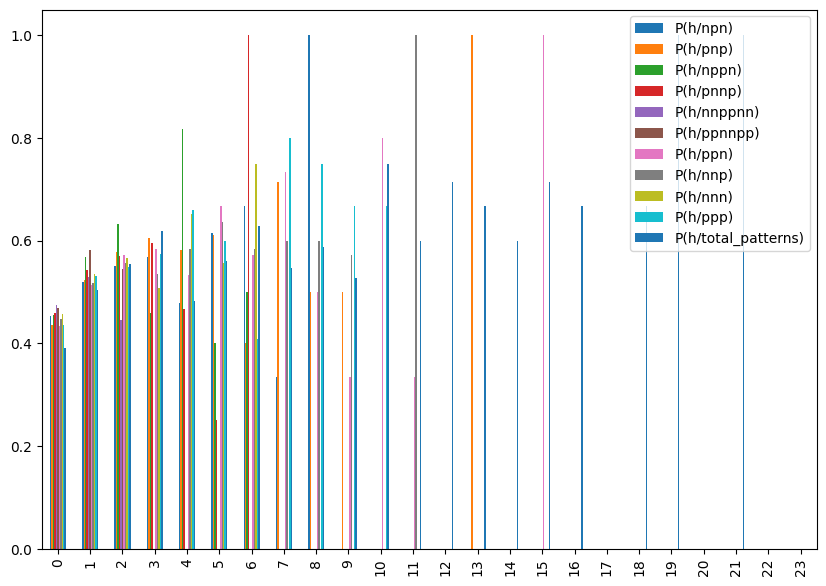

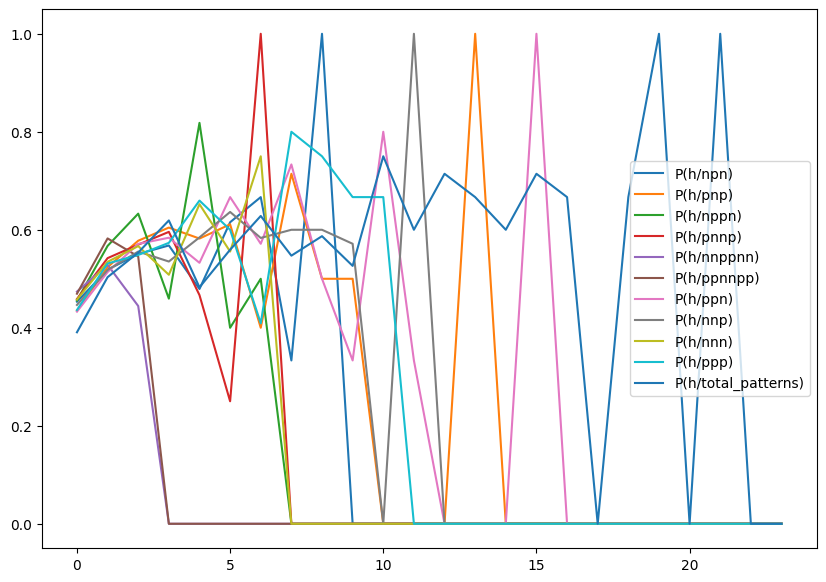

In [ ]:
percent_pat1.plot(kind='bar',figsize=(10,7))
percent_pat1.plot(kind='line',figsize=(10,7))

<Axes: >

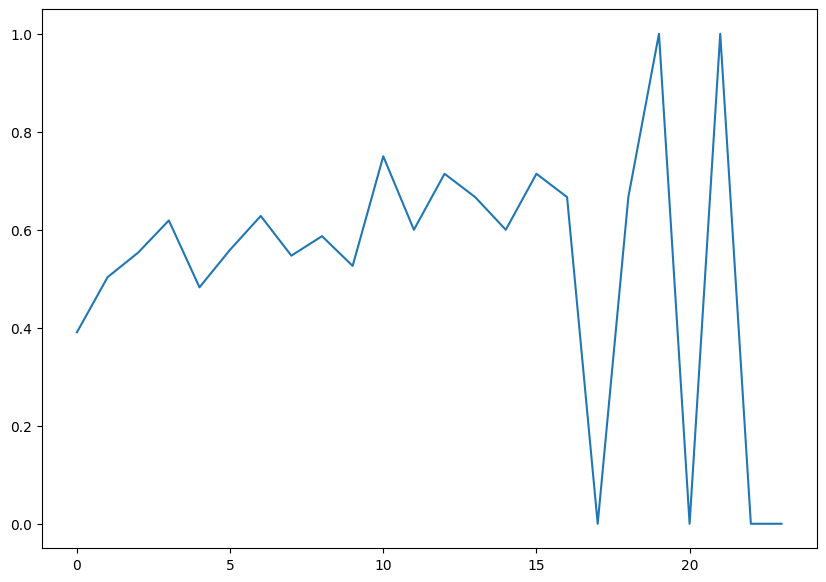

In [3820]:

percent_pat1['P(h/total_patterns)'].plot(kind='line',figsize=(10,7))

In [ ]:
len(data_amazon[data_amazon['helpfulness']==1])/len(data_amazon)

0.4752857142857143

In [ ]:
resultant_helpfulness[pattern_list_helpful].corr()

npn       pnp      nppn      pnnp    nnppnn    ppnnpp  \
npn             1.000000  0.654317  0.428125  0.574854  0.218158  0.198785   
pnp             0.654317  1.000000  0.598520  0.416696  0.164183  0.265648   
nppn            0.428125  0.598520  1.000000  0.478249  0.493045  0.422320   
pnnp            0.574854  0.416696  0.478249  1.000000  0.384626  0.592936   
nnppnn          0.218158  0.164183  0.493045  0.384626  1.000000  0.348339   
ppnnpp          0.198785  0.265648  0.422320  0.592936  0.348339  1.000000   
ppn             0.491242  0.753267  0.746619  0.571175  0.355495  0.520454   
nnp             0.701042  0.457063  0.531933  0.799802  0.452714  0.457331   
nnn             0.499447  0.302085  0.367335  0.277430  0.346033  0.157826   
ppp             0.320230  0.526761  0.268305  0.397195  0.134234  0.407513   
helpfulness     0.129586  0.151642  0.137313  0.119509  0.053035  0.077031   
total_patterns  0.754263  0.789207  0.719139  0.741985  0.432533  0.536105   

                     ppn       nnp       nnn       ppp  helpfulness  \
npn             0.491242  0.701042  0.499447  0.320230     0.129586   
pnp             0.753267  0.457063  0.302085  0.526761     0.151642   
nppn            0.746619  0.531933  0.367335  0.268305     0.137313   
pnnp            0.571175  0.799802  0.277430  0.397195     0.119509   
nnppnn          0.355495  0.452714  0.346033  0.134234     0.053035   
ppnnpp          0.520454  0.457331  0.157826  0.407513     0.077031   
ppn             1.000000  0.608383  0.410442  0.654612     0.160052   
nnp             0.608383  1.000000  0.663518  0.427493     0.143661   
nnn             0.410442  0.663518  1.000000  0.273448     0.117297   
ppp             0.654612  0.427493  0.273448  1.000000     0.133900   
helpfulness     0.160052  0.143661  0.117297  0.133900     1.000000   
total_patterns  0.885683  0.846288  0.602814  0.676191     0.180146   

                total_patterns  
npn                   0.754263  
pnp                   0.789207  
nppn                  0.719139  
pnnp                  0.741985  
nnppnn                0.432533  
ppnnpp                0.536105  
ppn                   0.885683  
nnp                   0.846288  
nnn                   0.602814  
ppp                   0.676191  
helpfulness           0.180146  
total_patterns        1.000000

In [ ]:
df_percent_pat_help = pd.DataFrame(percent_pat1)

In [ ]:
df_percent_pat_help

0  1         2     3     4
0   P(h/npn)  0  0.475286  3327  7000
1   P(h/npn)  1  0.527299  1101  2088
2   P(h/npn)  2  0.552102   302   547
3   P(h/npn)  3  0.554502   117   211
4   P(h/npn)  4  0.534884    46    86
..       ... ..       ...   ...   ...
80  P(h/ppp)  5  0.567164    38    67
81  P(h/ppp)  6  0.540541    20    37
82  P(h/ppp)  7  0.733333    11    15
83  P(h/ppp)  8  0.700000     7    10
84  P(h/ppp)  9  0.666667     4     6

[85 rows x 5 columns]

In [ ]:
df_help_pat = pd.DataFrame(percent_pat1)

In [ ]:
df_help_pat.to_csv('df_help_pat.csv')

In [ ]:
relevant_helpfulness_df['ppp'].max()

10

In [ ]:
percent_pat1=[]
for pat8 in pattern_list:
    percent_pat1.append({str('helpful_')+str('not_')+pat8: len(relevant_helpfulness_df.query(f"{pat8}=={0} and {'helpfulness'}==1"))  / len(relevant_helpfulness_df.query(f"{pat8}=={0}"))})
percent_pat1

[{'helpful_not_npn': 0.6731176292712429},
 {'helpful_not_pnp': 0.6585623678646935},
 {'helpful_not_nppn': 0.6826577732170344},
 {'helpful_not_pnnp': 0.6849855377333683},
 {'helpful_not_nnppnn': 0.7077565370248297},
 {'helpful_not_ppnnpp': 0.7033016734509272},
 {'helpful_not_ppn': 0.6519316493313522},
 {'helpful_not_nnp': 0.6637483787289234},
 {'helpful_not_nnn': 0.683853459972863},
 {'helpful_not_ppp': 0.6664333216660833}]

In [ ]:
percent_pat1=[]
for pat8 in pattern_list:
    percent_pat1.append({str('prob_')+pat8: len(relevant_helpfulness_df.query(f"{pat8}=={1} ")) / len(relevant_helpfulness_df)})
percent_pat1

[{'prob_npn': 0.21754010695187165},
 {'prob_pnp': 0.28663101604278074},
 {'prob_nppn': 0.1362566844919786},
 {'prob_pnnp': 0.15529411764705883},
 {'prob_nnppnn': 0.025668449197860963},
 {'prob_ppnnpp': 0.051336898395721926},
 {'prob_ppn': 0.2909090909090909},
 {'prob_nnp': 0.2427807486631016},
 {'prob_nnn': 0.17005347593582887},
 {'prob_ppp': 0.2862032085561497}]

In [ ]:
percent_pat1=[]
for pat8 in pattern_list:
    percent_pat1.append({str('prob_not_')+pat8: len(relevant_helpfulness_df.query(f"{pat8}=={0} ")) / len(relevant_helpfulness_df)})
percent_pat1

[{'prob_not_npn': 0.707379679144385},
 {'prob_not_pnp': 0.6070588235294118},
 {'prob_not_nppn': 0.8337967914438502},
 {'prob_not_pnnp': 0.813475935828877},
 {'prob_not_nnppnn': 0.973475935828877},
 {'prob_not_ppnnpp': 0.9458823529411765},
 {'prob_not_ppn': 0.5758288770053476},
 {'prob_not_nnp': 0.6596791443850267},
 {'prob_not_nnn': 0.788235294117647},
 {'prob_not_ppp': 0.6111229946524064}]

#### Balanced helpful dataset
So far we have been comparing with the overall result, on the original dataset we have approx 44% helpful data, but there are many who have not marked the reviews at all, ie [0,0] meaning zero ofut of zero people foud the reviews to be helpful. Therefore we need to see only relevant helpful dataset. Now among the relevant helpful +1 and -1 dataset we decide a threshold of 0.5. We get approx 71% reviews as helpful. We therefore need a balanced set to anaylse any tangible info gain in case we want to use emotions. Thus we randomly select a dataset with 50% helpful category and see the performance.

In [3842]:
help_index = relevant_helpfulness_df[relevant_helpfulness_df['helpfulness']==1].index
no_help_index = relevant_helpfulness_df[relevant_helpfulness_df['helpfulness']==0].index

In [3849]:
help_index_bal = np.random.choice(help_index,size = len(no_help_index),replace = False)

In [3850]:
help_index_bal.size

1348

In [3855]:
relevant_bal_index = np.append(help_index_bal,no_help_index,axis=0)

In [3856]:
relevant_bal_index = np.array(relevant_bal_index)

In [3858]:
relevant_bal_data = relevant_helpfulness_df.loc[relevant_bal_index]

In [3859]:
relevant_bal_data.size

70096

In [3860]:
relevant_bal_data['total_patterns'] = relevant_bal_data[['pnnp','nppn','ppp','nnn']].sum(axis=1)
pattern_list_help = pattern_list + ['total_patterns']
percent_pat1= {}
for pat8 in pattern_list_help: #['total_patterns']: #pattern_list:
    xcx = str(str('P(h/')+pat8+str(')'))
    temp_list = []
    for measure in range (0,int(relevant_bal_data[pattern_list_help].max().max())):
        percent  =  len(relevant_bal_data.query(f"{pat8}=={measure} and {'helpfulness'}==1"))  / len(relevant_bal_data.query(f"{pat8}=={measure}")) if len(relevant_bal_data.query(f"{pat8}=={measure}")) >0 else 0
        temp_list.append(percent)
        
    percent_pat1[xcx] = temp_list
    percent_pat1

In [3862]:
percent_pat1 = pd.DataFrame(percent_pat1)
percent_pat1

P(h/npn)  P(h/pnp)  P(h/nppn)  P(h/pnnp)  P(h/nnppnn)  P(h/ppnnpp)  \
0   0.448188  0.437935   0.465889   0.467556     0.495448     0.488100   
1   0.612789  0.575798   0.678457   0.653747     0.700000     0.726562   
2   0.681818  0.685714   0.854545   0.675000     0.000000     0.800000   
3   0.789474  0.810811   0.666667   0.833333     0.000000     0.000000   
4   0.800000  0.714286   0.857143   1.000000     0.000000     0.000000   
5   0.625000  0.875000   1.000000   0.500000     0.000000     0.000000   
6   1.000000  0.500000   0.000000   1.000000     0.000000     0.000000   
7   0.000000  1.000000   0.000000   0.000000     0.000000     0.000000   
8   1.000000  1.000000   0.000000   0.000000     0.000000     0.000000   
9   0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
10  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
11  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
12  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
13  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
14  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
15  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
16  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
17  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
18  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
19  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   
20  0.000000  0.000000   0.000000   0.000000     0.000000     0.000000   

    P(h/ppn)  P(h/nnp)  P(h/nnn)  P(h/ppp)  P(h/total_patterns)  
0   0.433837  0.441272  0.463875  0.452299             0.381771  
1   0.557641  0.593193  0.624709  0.548117             0.515521  
2   0.697297  0.719178  0.757576  0.679487             0.657807  
3   0.693548  0.704545  0.812500  0.690909             0.710843  
4   0.857143  0.833333  0.750000  0.857143             0.631579  
5   0.900000  0.750000  0.500000  0.714286             0.805556  
6   0.777778  0.666667  1.000000  1.000000             0.833333  
7   1.000000  0.750000  0.000000  1.000000             0.812500  
8   1.000000  1.000000  0.000000  1.000000             0.692308  
9   0.000000  1.000000  0.000000  0.000000             0.750000  
10  1.000000  0.000000  0.000000  0.000000             1.000000  
11  1.000000  1.000000  0.000000  0.000000             1.000000  
12  0.000000  0.000000  0.000000  0.000000             1.000000  
13  0.000000  0.000000  0.000000  0.000000             0.500000  
14  0.000000  0.000000  0.000000  0.000000             0.000000  
15  0.000000  0.000000  0.000000  0.000000             1.000000  
16  0.000000  0.000000  0.000000  0.000000             0.000000  
17  0.000000  0.000000  0.000000  0.000000             0.000000  
18  0.000000  0.000000  0.000000  0.000000             1.000000  
19  0.000000  0.000000  0.000000  0.000000             1.000000  
20  0.000000  0.000000  0.000000  0.000000             0.000000

<Axes: >

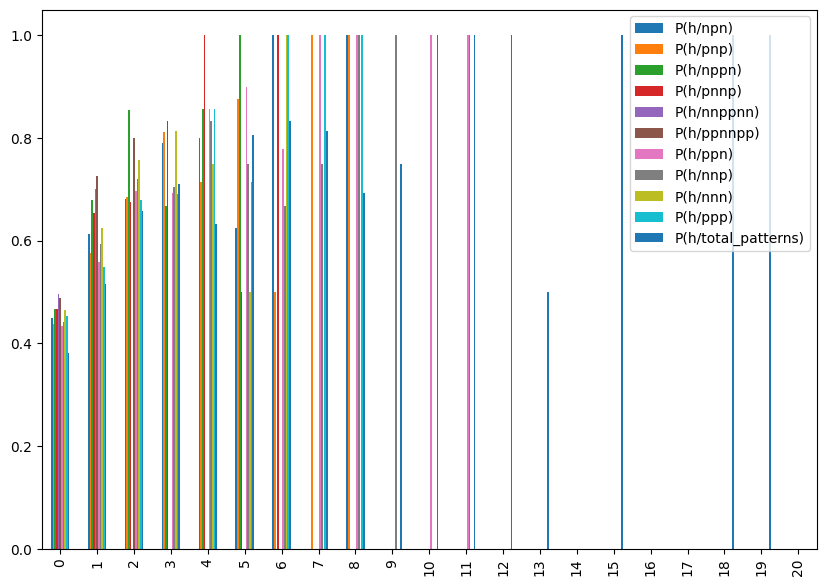

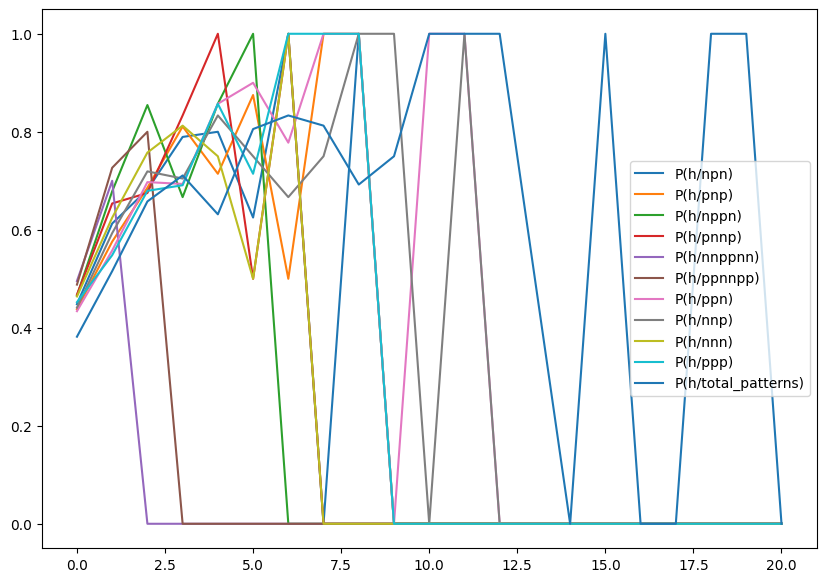

In [3863]:
percent_pat1.plot(kind='bar',figsize=(10,7))
percent_pat1.plot(kind='line',figsize=(10,7))

<Axes: >

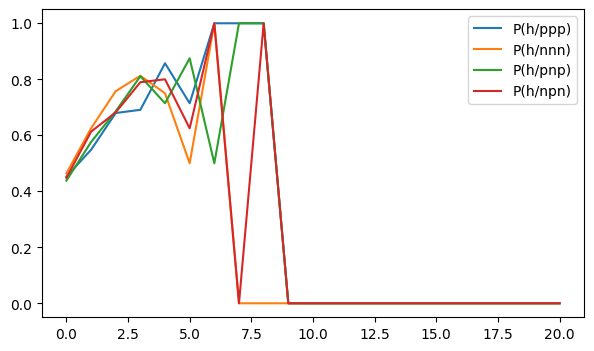

In [3868]:

percent_pat1[['P(h/ppp)','P(h/nnn)','P(h/pnp)','P(h/npn)']].plot(kind='line',figsize=(7,4))

In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

# Assuming you have two arrays or lists representing your variables
# For example, let's say variable A and B

# Example data (replace these with your actual data)
A = np.array(relevant_helpfulness_df['helpfulness'])
B = np.array(relevant_helpfulness_df['total_patterns'])

# Create a contingency table
contingency_table = np.array([[sum(np.logical_and(A, B)), sum(np.logical_and(A, [not i for i in B]))],
                              [sum(np.logical_and([not i for i in A], B)), sum(np.logical_and([not i for i in A], [not i for i in B]))]])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)



Chi-Square Statistic: 126.9627142638863
P-value: 1.892967187696154e-29
Degrees of Freedom: 1
Expected Frequencies:
[[2640.25026738  686.74973262]
 [1069.74973262  278.25026738]]


In [3869]:

from scipy.stats import chi2_contingency



A = np.array(relevant_helpfulness_df['helpfulness'])
B = np.array(relevant_helpfulness_df['pnp'])

contingency_table = np.array([[sum(np.logical_and(A, B)), sum(np.logical_and(A, [not i for i in B]))],
                              [sum(np.logical_and([not i for i in A], B)), sum(np.logical_and([not i for i in A], [not i for i in B]))]])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

Chi-Square Statistic: 98.56710970590233
P-value: 3.141945025947091e-23
Degrees of Freedom: 1
Expected Frequencies:
[[1307.31529412 2019.68470588]
 [ 529.68470588  818.31529412]]


In [3901]:
categories = [i for i in range(0,45)]
categories = np.array(categories)
categories = categories.tolist()
categories[35]

35

In [3874]:
B

array([ 2,  5,  5, ...,  3,  5, 11])

In [ ]:
confusion_matrix

[[0, 0], [0, 0]]

In [ ]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

In [ ]:
from scipy.stats import pointbiserialr

def phi_coefficient(x, y):
    return pointbiserialr(x, y)[0]

# Example usage
A = np.array(relevant_helpfulness_df['ppp'])
B = np.array(relevant_helpfulness_df['nnn'])

phi = phi_coefficient(A, B)
print(f"Phi Coefficient: {phi}")

Phi Coefficient: 0.2734475490906123


In [ ]:

df = relevant_helpfulness_df

# Function to calculate Phi coefficient
def phi_coefficient(x, y):
    return pointbiserialr(x, y)[0]

# Calculate Phi correlation matrix
binary_columns = df.columns[df.nunique() == 2]  # Identify binary columns
phi_matrix = pd.DataFrame(index=binary_columns, columns=binary_columns)

for col1 in binary_columns:
    for col2 in binary_columns:
        if col1 != col2:
            phi = phi_coefficient(df[col1], df[col2])
            phi_matrix.loc[col1, col2] = phi

# Fill diagonal with 1 (since a variable is perfectly correlated with itself)
phi_matrix = phi_matrix.fillna(1)

# Print Phi correlation matrix
#print("Phi Correlation Matrix:")
#print(phi_matrix)
phi_matrix




helpfulness
helpfulness            1

In [ ]:
phi_matrix = pd.DataFrame(phi_matrix)


In [ ]:
phi_matrix.drop(columns='helpfulness',inplace=True)

IndexError: index 0 is out of bounds for axis 0 with size 0

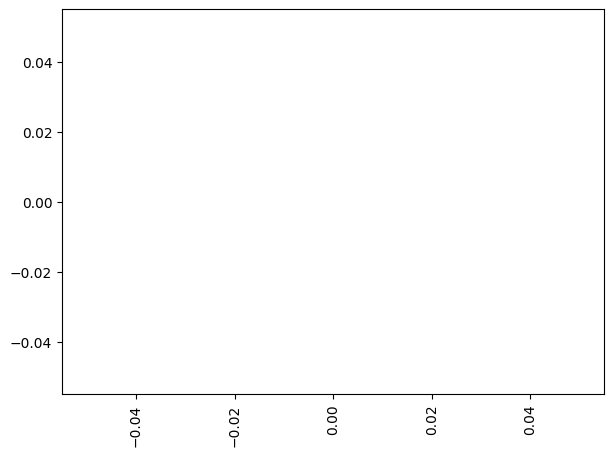

In [ ]:
#plt.bar(phi_matrix[pattern_list].loc['helpfulness'].index , phi_matrix[pattern_list].loc['helpfulness'])

ax = phi_matrix.loc['helpfulness'].plot(kind='bar', y=['helpfulness'], x= phi_matrix.index , figsize=(7,5),color = 'orange',legend=False)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), 
                (p.get_x() + p.get_width() / 2., round(p.get_height(),3)), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.xticks(rotation=35)
plt.grid(True)
plt.xlabel('Emotion')
plt.ylabel('Helpfulness')
plt.show()

In [ ]:
pattern_list

['npn', 'pnp', 'nppn', 'pnnp', 'nnppnn', 'ppnnpp', 'ppn', 'nnp', 'nnn', 'ppp']

In [ ]:
data_amazon_json_df_pat

Unnamed: 0             reviewerID        asin  \
0              0  A10000012B7CGYKOMPQ4L  000100039X   
1              1         A2S166WSCFIFP5  000100039X   
2              2         A1BM81XB4QHOA3  000100039X   
3              3         A1MOSTXNIO5MPJ  000100039X   
4              4         A2XQ5LZHTD4AFT  000100039X   
...          ...                    ...         ...   
6995        6995         A2Q3D3CC9HT0S5  000612609X   
6996        6996         A2DG7FHNHVX0Q8  000612609X   
6997        6997         A2B1RCJ5JJ42M5  000612609X   
6998        6998         A1UQ0R3JYNMPJJ  000612609X   
6999        6999         A3U4FCEAT75XLS  000612609X   

                                         reviewerName helpful  \
0                                                Adam  [0, 0]   
1     adead_poet@hotmail.com "adead_poet@hotmail.com"  [0, 2]   
2                         Ahoro Blethends "Seriously"  [0, 0]   
3                                           Alan Krug  [0, 0]   
4                                            Alaturka  [7, 9]   
...                                               ...     ...   
6995                                       C. Hurwitz  [0, 0]   
6996                                          Colin R  [0, 0]   
6997                                        Comfort55  [0, 0]   
6998                                  C. Star "C R E"  [0, 0]   
6999                                         Cynesige  [3, 3]   

                                             reviewText  overall  \
0     Spiritually and mentally inspiring! A book tha...      5.0   
1     This is one my must have books. It is a master...      5.0   
2     This book provides a reflection that you can a...      5.0   
3     I first read THE PROPHET in college back in th...      5.0   
4     A timeless classic.  It is a very demanding an...      5.0   
...                                                 ...      ...   
6995  Everything you could ask for in a novel; inter...      5.0   
6996  Written in a different style to more modern wr...      4.0   
6997  THIS IS A WELL WRITTEN HISTORICAL FICTIONAL AC...      4.0   
6998  As many others have said, this is an epic book...      5.0   
6999  This AMAZING book, written in the 1940s, trans...      5.0   

                                                summary  unixReviewTime  \
0                                            Wonderful!      1355616000   
1                                          close to god      1071100800   
2                       Must Read for Life Afficianados      1390003200   
3     Timeless for every good and bad time in your l...      1317081600   
4                                         A Modern Rumi      1033948800   
...                                                 ...             ...   
6995                                   Simply excellent      1359504000   
6996  however once got in to the writing style it wa...      1398556800   
6997                      GREAT FOR READERS OF THIS ERA      1355961600   
6998                                  When men were men      1386633600   
6999  Just about the most fun you can have reading a...      1295654400   

       reviewTime  ... ppp  nnn  nnp  ppn  pnnp  nppn  nnppnn  ppnnpp  \
0     12 16, 2012  ...   0    0    0    0     0     0       0       0   
1     12 11, 2003  ...   1    0    0    1     0     0       0       0   
2     01 18, 2014  ...   0    0    0    0     0     0       0       0   
3     09 27, 2011  ...   0    0    1    1     0     1       0       0   
4      10 7, 2002  ...   0    0    0    1     0     1       0       0   
...           ...  ...  ..  ...  ...  ...   ...   ...     ...     ...   
6995  01 30, 2013  ...   0    0    0    0     0     0       0       0   
6996  04 27, 2014  ...   0    0    0    0     0     0       0       0   
6997  12 20, 2012  ...   0    0    0    0     0     0       0       0   
6998  12 10, 2013  ...   1    1    1    1     0     0       0       0   
6999  01 22, 2011  ...   2    0    0    3  

In [ ]:
data_amazon_json_df_pat_nrc = pd.concat([data_amazon_json_df_pat,data_amazon_json_df['reviewText'].apply(return_nrc_emo)],axis=1)

In [ ]:
data_amazon_json_df_pat_nrc['helpfulness'] = data_amazon_json_df_pat['helpful'].apply(lambda x : find_helpfulness(x))

NameError: name 'input_value' is not defined

In [ ]:
data_amazon_json_df_pat_nrc[emo_list].corr()

anger     trust  surprise  positive  negative   sadness  \
anger         1.000000 -0.221815 -0.085816 -0.329229  0.363784  0.311937   
trust        -0.221815  1.000000 -0.055563  0.009530 -0.272660 -0.257627   
surprise     -0.085816 -0.055563  1.000000 -0.125014 -0.194393 -0.119690   
positive     -0.329229  0.009530 -0.125014  1.000000 -0.404198 -0.318421   
negative      0.363784 -0.272660 -0.194393 -0.404198  1.000000  0.409109   
sadness       0.311937 -0.257627 -0.119690 -0.318421  0.409109  1.000000   
disgust       0.445483 -0.213522 -0.082474 -0.286394  0.288947  0.382189   
joy          -0.257320  0.026739  0.222298  0.126434 -0.361338 -0.250694   
anticipation -0.339535 -0.161914 -0.102318 -0.178252 -0.165984 -0.325963   

               disgust       joy  anticipation  
anger         0.445483 -0.257320     -0.339535  
trust        -0.213522  0.026739     -0.161914  
surprise     -0.082474  0.222298     -0.102318  
positive     -0.286394  0.126434     -0.178252  
negative      0.288947 -0.361338     -0.165984  
sadness       0.382189 -0.250694     -0.325963  
disgust       1.000000 -0.227372     -0.289560  
joy          -0.227372  1.000000     -0.138592  
anticipation -0.289560 -0.138592      1.000000

In [4176]:
temo_df = data_amazon[emo_list1]
temo_df = temo_df.query(f"{'helpfulness'}==1 or {'helpfulness'}==-1")
temo_df['helpfulness'] = temo_df['helpfulness'].apply(lambda x : 1 if x>0 else 0)
temo_df['helpfulness'].value_counts()

helpfulness
1    3327
0    1348
Name: count, dtype: int64

In [4177]:
temo_df[emo_list1].corr()

anger     trust  surprise  positive  negative   sadness  \
anger         1.000000 -0.228358 -0.087270 -0.333426  0.355732  0.301222   
trust        -0.228358  1.000000 -0.050252 -0.003987 -0.289880 -0.267768   
surprise     -0.087270 -0.050252  1.000000 -0.120631 -0.198505 -0.125535   
positive     -0.333426 -0.003987 -0.120631  1.000000 -0.408276 -0.312537   
negative      0.355732 -0.289880 -0.198505 -0.408276  1.000000  0.383214   
sadness       0.301222 -0.267768 -0.125535 -0.312537  0.383214  1.000000   
disgust       0.459981 -0.223891 -0.088305 -0.287086  0.274511  0.378404   
joy          -0.252251  0.033876  0.228166  0.125285 -0.374576 -0.250812   
anticipation -0.215211 -0.129439  0.037474 -0.216415 -0.090825 -0.218414   
helpfulness   0.033525 -0.096763  0.074743  0.073449 -0.047018  0.045889   

               disgust       joy  anticipation  helpfulness  
anger         0.459981 -0.252251     -0.215211     0.033525  
trust        -0.223891  0.033876     -0.129439    -0.096763  
surprise     -0.088305  0.228166      0.037474     0.074743  
positive     -0.287086  0.125285     -0.216415     0.073449  
negative      0.274511 -0.374576     -0.090825    -0.047018  
sadness       0.378404 -0.250812     -0.218414     0.045889  
disgust       1.000000 -0.218669     -0.190893     0.016416  
joy          -0.218669  1.000000     -0.020738     0.092372  
anticipation -0.190893 -0.020738      1.000000    -0.065979  
helpfulness   0.016416  0.092372     -0.065979     1.000000

In [ ]:
result_main = data_amazon_json_df_pat_nrc[data_amazon_json_df_pat_nrc['helpfulness'] !=0]

In [ ]:
result_main['helpfulness'] = result_main['helpfulness'].apply(lambda x : 1 if x>0 else 0)

In [ ]:
result_main['helpfulness'].value_counts()

helpfulness
1    3327
0    1348
Name: count, dtype: int64

In [4336]:
result_balanced = result_main

In [ ]:
emo_list1 = emo_list + ['helpfulness']

In [ ]:
corr_emotions = pd.DataFrame(result_main[emo_list1].corr())

In [ ]:
corr_emotions.drop(columns='helpfulness',inplace=True)

In [ ]:
corr_emotions

anger     trust  surprise  positive  negative   sadness  \
anger         1.000000 -0.228358 -0.087270 -0.333426  0.355732  0.301222   
trust        -0.228358  1.000000 -0.050252 -0.003987 -0.289880 -0.267768   
surprise     -0.087270 -0.050252  1.000000 -0.120631 -0.198505 -0.125535   
positive     -0.333426 -0.003987 -0.120631  1.000000 -0.408276 -0.312537   
negative      0.355732 -0.289880 -0.198505 -0.408276  1.000000  0.383214   
sadness       0.301222 -0.267768 -0.125535 -0.312537  0.383214  1.000000   
disgust       0.459981 -0.223891 -0.088305 -0.287086  0.274511  0.378404   
joy          -0.252251  0.033876  0.228166  0.125285 -0.374576 -0.250812   
anticipation -0.357446 -0.145563 -0.114794 -0.185202 -0.129740 -0.326486   
helpfulness   0.033525 -0.096763  0.074743  0.073449 -0.047018  0.045889   

               disgust       joy  anticipation  
anger         0.459981 -0.252251     -0.357446  
trust        -0.223891  0.033876     -0.145563  
surprise     -0.088305  0.228166     -0.114794  
positive     -0.287086  0.125285     -0.185202  
negative      0.274511 -0.374576     -0.129740  
sadness       0.378404 -0.250812     -0.326486  
disgust       1.000000 -0.218669     -0.300295  
joy          -0.218669  1.000000     -0.155185  
anticipation -0.300295 -0.155185      1.000000  
helpfulness   0.016416  0.092372     -0.148352

In [ ]:
corr_emotions.loc['helpfulness'][emo_list]

anger           0.033525
trust          -0.096763
surprise        0.074743
positive        0.073449
negative       -0.047018
sadness         0.045889
disgust         0.016416
joy             0.092372
anticipation   -0.148352
Name: helpfulness, dtype: float64

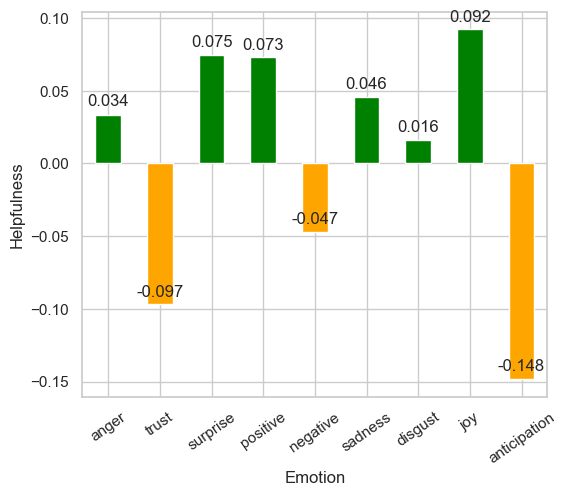

In [4158]:
sns.color_palette('bright')
colors = ['green' if val > 0 else 'orange' for val in corr_emotions.loc['helpfulness'][emo_list]]
ax = corr_emotions.loc['helpfulness'].plot(kind='bar', y='helpfulness', x= corr_emotions.index , figsize=(6,5),legend=False,color = colors)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), 
                (p.get_x() + p.get_width() / 2., round(p.get_height(),3)), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.xticks(rotation=35)
plt.grid(True)
plt.xlabel('Emotion')
plt.ylabel('Helpfulness')
plt.show()

In [ ]:
result_main

Unnamed: 0      reviewerID        asin  \
1              1  A2S166WSCFIFP5  000100039X   
4              4  A2XQ5LZHTD4AFT  000100039X   
14            14  A19N3FCQCLJYUA  000100039X   
15            15  A3FFNE1DR5SI1W  000100039X   
17            17  A2X4HE21JTAL98  000100039X   
...          ...             ...         ...   
6984        6984  A3N920W8AIH6NB  000612609X   
6989        6989   AMB648K7UW4U7  000612609X   
6992        6992  A2WLOLLYLMZVJC  000612609X   
6993        6993  A1UI13G1X0AMKK  000612609X   
6999        6999  A3U4FCEAT75XLS  000612609X   

                                         reviewerName helpful  \
1     adead_poet@hotmail.com "adead_poet@hotmail.com"  [0, 2]   
4                                            Alaturka  [7, 9]   
14                                    Amazon Customer  [1, 1]   
15                                         A. Morelli  [1, 1]   
17                                        Antiquarian  [3, 5]   
...                                               ...     ...   
6984                                            bet33  [1, 1]   
6989                                       Book lover  [5, 6]   
6992                       C. Dean Andersson "writer"  [1, 2]   
6993                                       Cenk Sumen  [5, 6]   
6999                                         Cynesige  [3, 3]   

                                             reviewText  overall  \
1     This is one my must have books. It is a master...      5.0   
4     A timeless classic.  It is a very demanding an...      5.0   
14    I discovered The Prophet fifty years ago in co...      5.0   
15    Can't say enough about Kahlil Gibran's work am...      5.0   
17    Anything I've read by Gibran is, in my mind, f...      5.0   
...                                                 ...      ...   
6984  Loved the characters, and learning more about ...      3.0   
6989  The unique style of this author gives the read...      3.0   
6992  I first read this book many years ago. It was ...      5.0   
6993  War and strife make for good reading, at least...      5.0   
6999  This AMAZING book, written in the 1940s, trans...      5.0   

                                                summary  unixReviewTime  \
1                                          close to god      1071100800   
4                                         A Modern Rumi      1033948800   
14                A book everyone &#34;should&#34; read      1358899200   
15                      phenomenal piece of literature!      1340755200   
17                                             Flawless      1132099200   
...                                                 ...             ...   
6984                          Learned a lot of history!      1357776000   
6989                                  Lengthy but light      1327017600   
6992                                     Red Orm Lives!      1123286400   
6993  laconic sea warriors on the hunt for grand adv...      1176249600   
6999  Just about the most fun you can have reading a...      1295654400   

       reviewTime  ...     anger  anticip     trust  surprise  positive  \
1     12 11, 2003  ...  0.083333      0.0  0.166667  0.000000  0.250000   
4      10 7, 2002  ...  0.000000      0.0  0.302326  0.093023  0.302326   
14    01 23, 2013  ...  0.000000      0.0  0.200000  0.000000  0.400000   
15    06 27, 2012  ...  0.000000      0.0  0.153846  0.076923  0.307692   
17    11 16, 2005  ...  0.076923      0.0  0.153846  0.000000  0.307692   
...           ...  ...       ...      ...       ...       ...       ...   
6984  01 10, 2013  ...  0.000000      0.0  0.142857  0.142857  0.285714   
6989  01 20, 2012  ...  0.000000      0.0  0.214286  0.142857  0.357143   
6992   08 6, 2005  ...  0.000000      0.0  0.200000  0.100000  0.300000   
6993  04 11, 2007  ...  0.074074      0.0  0.111111  0.055556  0.296296   
6999  01 22, 2011  ...  0.088889      0.0  0.124444  0.035556  0.275556   

      negative   sadness   di

In [ ]:
result_main.sort_values(by='anger',ascending=False)

Unnamed: 0      reviewerID        asin                  reviewerName  \
3658        3658   AI345SS1ZPWSK  0002219417               Phyllis Herring   
1376        1376   A8LGCWTOZA9KK  0002007770                  Hollyn Chase   
2320        2320  A3AUJ5V5YHLQE8  0002007770                        Nicole   
5341        5341  A3UKEHDUPZJA1A  0002247399  John B. Henderson "johnbh99"   
2955        2955  A2Y0D709WISMJX  0002007770                   Veggin' Out   
...          ...             ...         ...                           ...   
4451        4451  A32Q5WWHR0QL14  0002247399               Amazon Customer   
2187        2187   AL7NDUMRKUONO  0002007770              M. Hollingsworth   
4457        4457  A1M8KPRMMRP6GG  0002247399               Amazon Customer   
646          646   AG3WWT470R6TZ  0002007770                         Beebo   
3983        3983    ALSUB0PJ2IPF  000224053X   Ms. Serena Steuart "serena"   

      helpful                                         reviewText  overall  \
3658   [1, 1]  I first read the novel 35 years ago. I was ent...      5.0   
1376   [3, 3]  A ninety--or is it ninety-three?--year-old man...      5.0   
2320   [0, 1]  I'm going to stop writing reviews if you keep ...      5.0   
5341   [2, 3]  I don't know why I persisted through these 5 b...      1.0   
2955   [1, 1]  Vivid descriptions transport you to the front ...      5.0   
...       ...                                                ...      ...   
4451   [1, 1]  I don't really care about the majority of the ...      3.0   
2187   [1, 1]  I gave the book 5 stars because I thought it w...      5.0   
4457  [2, 16]  So you feel like the story has failed to advan...      5.0   
646    [1, 1]  This is about a circus around in the 30's. It ...      5.0   
3983   [0, 1]  Now there are private enterprise plans for col...      3.0   

                                        summary  unixReviewTime   reviewTime  \
3658                            One of the best      1209945600   05 5, 2008   
1376  Water for Elephants and Food for the Soul      1155513600  08 14, 2006   
2320                                   Loved it      1371686400  06 20, 2013   
5341                          very disappointed      1398988800   05 2, 2014   
2955            You can almost smell the carnie      1221350400  09 14, 2008   
...                                         ...             ...          ...   
4451                  OK, but not what I wanted      1384560000  11 16, 2013   
2187                                 Great book      1356566400  12 27, 2012   
4457                  I get the complaints; but      1345593600  08 22, 2012   
646                              Very good book      1357776000  01 10, 2013   
3983                       colonisation of Mars      1372550400  06 30, 2013   

      ...     anger  anticip     trust  surprise  positive  negative  sadness  \
3658  ...  0.500000      0.0  0.000000  0.000000  0.000000  0.500000      0.0   
1376  ...  0.500000      0.0  0.000000  0.000000  0.500000  0.000000      0.0   
2320  ...  0.500000      0.0  0.000000  0.000000  0.000000  0.500000      0.0   
5341  ...  0.400000      0.0  0.000000  0.000000  0.200000  0.400000      0.0   
2955  ...  0.333333      0.0  0.000000  0.000000  0.333333  0.333333      0.0   
...   ...       ...      ...       ...       ...       ...       ...      ...   
4451  ...  0.000000      0.0  0.333333  0.000000  0.333333  0.000000      0.0   
2187  ...  0.000000      0.0  0.266667  0.066667  0.266667  0.000000      0.0   
4457  ...  0.000000      0.0  0.142857  0.071429  0.357143  0.035714      0.0   
646   ...  0.000000      0.0  0.200000  0.200000  0.200000  0.000000      0.0   
3983  ...  0.000000      0.0  0.222222  0.055556  0.416667  0.027778      0.0   

       disgust       joy  anticipation  
3658  0.000000  0.000000           NaN  
1376  0.000000  0.000000           NaN  
2320  0.000000  0.000000           NaN  
5341  0.000000  0.000000           NaN  
2955 

In [4330]:
result_main[result_main['anger']>=.3].head()

Unnamed: 0      reviewerID        asin  reviewerName helpful  \
1376        1376   A8LGCWTOZA9KK  0002007770  Hollyn Chase  [3, 3]   
1520        1520   AIKI5ZD72P4LZ  0002007770  Jenny Sutton  [1, 1]   
1624        1624  A2XX9MTW0K32RN  0002007770          jp05  [2, 5]   
2320        2320  A3AUJ5V5YHLQE8  0002007770        Nicole  [0, 1]   
2955        2955  A2Y0D709WISMJX  0002007770   Veggin' Out  [1, 1]   

                                             reviewText  overall  \
1376  A ninety--or is it ninety-three?--year-old man...      5.0   
1520  This well-reasearched book brought the depress...      4.0   
1624  I couldn't finish the book I was so bored and ...      1.0   
2320  I'm going to stop writing reviews if you keep ...      5.0   
2955  Vivid descriptions transport you to the front ...      5.0   

                                        summary  unixReviewTime   reviewTime  \
1376  Water for Elephants and Food for the Soul      1155513600  08 14, 2006   
1520                               Circus Magic      1284422400  09 14, 2010   
1624                                boring.....      1390694400  01 26, 2014   
2320                                   Loved it      1371686400  06 20, 2013   
2955            You can almost smell the carnie      1221350400  09 14, 2008   

      ...     anger  anticip  trust  surprise  positive  negative  sadness  \
1376  ...  0.500000      0.0    0.0       0.0  0.500000  0.000000      0.0   
1520  ...  0.333333      0.0    0.0       0.0  0.333333  0.333333      0.0   
1624  ...  0.333333      0.0    0.0       0.0  0.000000  0.666667      0.0   
2320  ...  0.500000      0.0    0.0       0.0  0.000000  0.500000      0.0   
2955  ...  0.333333      0.0    0.0       0.0  0.333333  0.333333      0.0   

      disgust  joy  anticipation  
1376      0.0  0.0           NaN  
1520      0.0  0.0           NaN  
1624      0.0  0.0           NaN  
2320      0.0  0.0           NaN  
2955      0.0  0.0           NaN  

[5 rows x 37 columns]

In [ ]:
th = .5
len(result_main.query(f"{'surprise'}>={th} and {'helpfulness'}=={1}"))/len(result_main.query(f"{'surprise'}>={th} "))

0.8333333333333334

In [ ]:
data_amazon['helpfulness'].value_counts()

helpfulness
 1    3327
 0    2325
-1    1348
Name: count, dtype: int64

In [ ]:
emo_score_helpful = []
th = .4

for emo7 in emo_list:
    emo_score_helpful.append([str('P(h/')+emo7+str(')') , len(result_main.query(f"{emo7}>={th} and {'helpfulness'}=={1}"))/len(result_main.query(f"{emo7}>={th} "))])

In [ ]:
emo_score_helpful

[['P(h/anger)', 0.75],
 ['P(h/trust)', 0.410958904109589],
 ['P(h/surprise)', 0.8333333333333334],
 ['P(h/positive)', 0.7175675675675676],
 ['P(h/negative)', 0.5529411764705883],
 ['P(h/sadness)', 0.6666666666666666],
 ['P(h/disgust)', 0.0],
 ['P(h/joy)', 0.6666666666666666],
 ['P(h/anticipation)', 0.5374149659863946]]

In [ ]:
xx

0           1              2              3  \
Prob                P(h/anger)  P(h/trust)  P(h/surprise)  P(h/positive)   
0                     0.711658    0.711658       0.711658       0.711658   
0.06                  0.733781    0.726016       0.745445       0.733225   
0.12                  0.636054    0.705396       0.706815       0.740705   
0.18                  0.577465    0.660765       0.710345       0.751833   
0.24                  0.606061    0.573082       0.666667        0.74616   
0.3                   0.615385     0.51105       0.714286       0.740604   
0.36                      0.75    0.442424       0.833333       0.734258   
0.42                  0.666667    0.391667       0.833333       0.708968   
0.48                  0.666667    0.388889       0.833333       0.678082   
0.54                       0.0    0.195122            1.0       0.654206   
0.6                        0.0         0.2            1.0       0.634409   
0.6599999999999999         0.0    0.216216            1.0       0.623377   

                                4             5             6         7  \
Prob                P(h/negative)  P(h/sadness)  P(h/disgust)  P(h/joy)   
0                        0.711658      0.711658      0.711658  0.711658   
0.06                     0.720608      0.746667      0.701695  0.749697   
0.12                     0.696751      0.675926       0.57732  0.736292   
0.18                     0.654524      0.650273      0.563636  0.739541   
0.24                     0.559036      0.642857      0.612903   0.68231   
0.3                      0.492891      0.571429      0.555556  0.637363   
0.36                      0.56044      0.666667           0.0  0.666667   
0.42                     0.508772      0.615385           0.0  0.769231   
0.48                     0.537037      0.615385           0.0  0.727273   
0.54                     0.466667           1.0           0.0       0.0   
0.6                           0.5           1.0           0.0       0.0   
0.6599999999999999       0.416667           1.0           0.0       0.0   

                                    8  
Prob                P(h/anticipation)  
0                            0.732005  
0.06                         0.726592  
0.12                         0.690608  
0.18                          0.61962  
0.24                         0.543119  
0.3                          0.521311  
0.36                         0.542169  
0.42                         0.533333  
0.48                          0.53271  
0.54                         0.617021  
0.6                          0.630435  
0.6599999999999999           0.682927

In [ ]:
len(result_main[result_main['helpfulness']==1]) / len(result_main)

0.7116577540106952

In [4364]:
result_main_balanced = result_main.iloc[balanced_indices]

In [4514]:
len(result_main_balanced)

2696

## Conditional Probability Analysis

In [4390]:
th = 0
emo_score_helpful = []
for emo7 in emo_list:
    emo_score_helpful.append([str('P(h/')+emo7+str(')') , len(result_main_balanced.query(f"{emo7}>={th} and {'helpfulness'}=={0}"))/len(result_main_balanced.query(f"{emo7}>={th} ")) if len(result_main_balanced.query(f"{emo7}>={th} ")) >0 else 0])
emo_score_helpful_df = pd.DataFrame(emo_score_helpful,columns=['Prob',str(th)])
for z in range(1,9):
    emo_score_helpful = []
    th = z*.06
    for emo7 in emo_list:
        emo_score_helpful.append([str('P(h/')+emo7+str(')') , len(result_main_balanced.query(f"{emo7}>={th} and {'helpfulness'}=={0}"))/len(result_main_balanced.query(f"{emo7}>={th} "))if len(result_main_balanced.query(f"{emo7}>={th} ")) >0 else 0])
    xx = pd.DataFrame(emo_score_helpful,columns=['Prob',str(th)])
    emo_score_helpful_df[str(th)] = xx[str(th)]

In [4391]:
emo_score_helpful_df

Prob         0      0.06      0.12      0.18      0.24  \
0         P(h/anger)  0.500000  0.473475  0.569149  0.612245  0.565217   
1         P(h/trust)  0.500000  0.480429  0.503071  0.553118  0.635776   
2      P(h/surprise)  0.500000  0.449385  0.502717  0.538462  0.576923   
3      P(h/positive)  0.500000  0.472062  0.462134  0.444669  0.451503   
4      P(h/negative)  0.500000  0.493007  0.521277  0.576471  0.680297   
5       P(h/sadness)  0.500000  0.466735  0.548589  0.633663  0.638298   
6       P(h/disgust)  0.500000  0.512621  0.635659  0.631579  0.631579   
7           P(h/joy)  0.500000  0.449346  0.454137  0.449883  0.553459   
8  P(h/anticipation)  0.474377  0.481237  0.527473  0.613893  0.682192   

        0.3      0.36      0.42      0.48  
0  0.454545  0.333333  0.500000  0.500000  
1  0.686047  0.766667  0.802198  0.804878  
2  0.571429  0.333333  0.333333  0.333333  
3  0.456121  0.457721  0.492837  0.534091  
4  0.722973  0.655738  0.700000  0.675676  
5  0.692308  0.714286  0.714286  0.714286  
6  0.666667  1.000000  1.000000  0.000000  
7  0.634615  0.636364  0.428571  0.500000  
8  0.695238  0.684685  0.682927  0.675676

In [4392]:
xx =emo_score_helpful_df.T
xx

0           1              2              3              4  \
Prob  P(h/anger)  P(h/trust)  P(h/surprise)  P(h/positive)  P(h/negative)   
0            0.5         0.5            0.5            0.5            0.5   
0.06    0.473475    0.480429       0.449385       0.472062       0.493007   
0.12    0.569149    0.503071       0.502717       0.462134       0.521277   
0.18    0.612245    0.553118       0.538462       0.444669       0.576471   
0.24    0.565217    0.635776       0.576923       0.451503       0.680297   
0.3     0.454545    0.686047       0.571429       0.456121       0.722973   
0.36    0.333333    0.766667       0.333333       0.457721       0.655738   
0.42         0.5    0.802198       0.333333       0.492837            0.7   
0.48         0.5    0.804878       0.333333       0.534091       0.675676   

                 5             6         7                  8  
Prob  P(h/sadness)  P(h/disgust)  P(h/joy)  P(h/anticipation)  
0              0.5           0.5       0.5           0.474377  
0.06      0.466735      0.512621  0.449346           0.481237  
0.12      0.548589      0.635659  0.454137           0.527473  
0.18      0.633663      0.631579  0.449883           0.613893  
0.24      0.638298      0.631579  0.553459           0.682192  
0.3       0.692308      0.666667  0.634615           0.695238  
0.36      0.714286           1.0  0.636364           0.684685  
0.42      0.714286           1.0  0.428571           0.682927  
0.48      0.714286           0.0       0.5           0.675676

In [4393]:
xx.columns = xx.iloc[0]

# Drop the first row
xx = xx[1:]


In [4394]:
xx = xx.astype(float)
xy = xx.round(3)

In [4395]:
xy

Prob  P(h/anger)  P(h/trust)  P(h/surprise)  P(h/positive)  P(h/negative)  \
0          0.500       0.500          0.500          0.500          0.500   
0.06       0.473       0.480          0.449          0.472          0.493   
0.12       0.569       0.503          0.503          0.462          0.521   
0.18       0.612       0.553          0.538          0.445          0.576   
0.24       0.565       0.636          0.577          0.452          0.680   
0.3        0.455       0.686          0.571          0.456          0.723   
0.36       0.333       0.767          0.333          0.458          0.656   
0.42       0.500       0.802          0.333          0.493          0.700   
0.48       0.500       0.805          0.333          0.534          0.676   

Prob  P(h/sadness)  P(h/disgust)  P(h/joy)  P(h/anticipation)  
0            0.500         0.500     0.500              0.474  
0.06         0.467         0.513     0.449              0.481  
0.12         0.549         0.636     0.454              0.527  
0.18         0.634         0.632     0.450              0.614  
0.24         0.638         0.632     0.553              0.682  
0.3          0.692         0.667     0.635              0.695  
0.36         0.714         1.000     0.636              0.685  
0.42         0.714         1.000     0.429              0.683  
0.48         0.714         0.000     0.500              0.676

<Axes: title={'center': "Conditional Prob for Not- helpful (buyer's perspective)"}, xlabel='Emotional Intensity', ylabel='Conditional Probability -  P $\\overline{h}$/emotion)'>

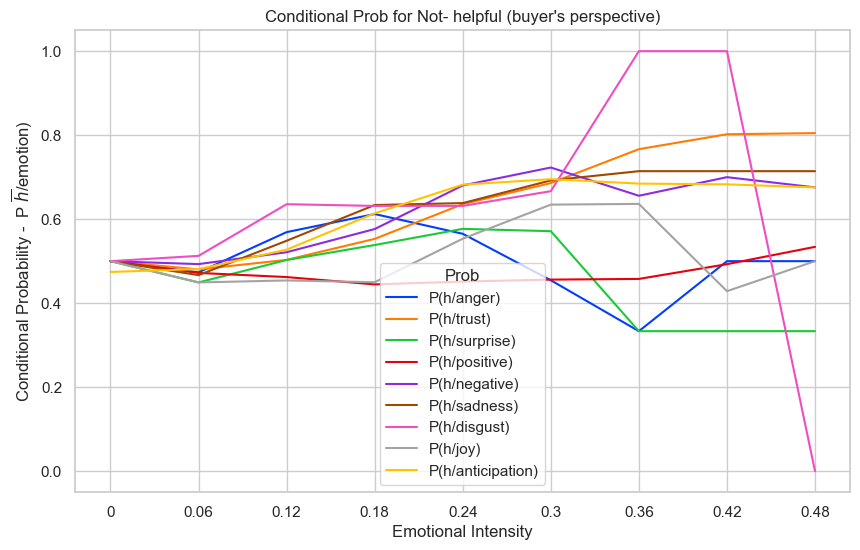

In [4401]:
xx.plot(kind='line', figsize=(10, 6),title='Conditional Prob for Not- helpful (buyer\'s perspective)',xlabel='Emotional Intensity',ylabel='Conditional Probability -  P $\overline{h}$/emotion)')


In [4373]:
xx = xx.apply(pd.to_numeric, errors='coerce')

<Axes: xlabel='Prob'>

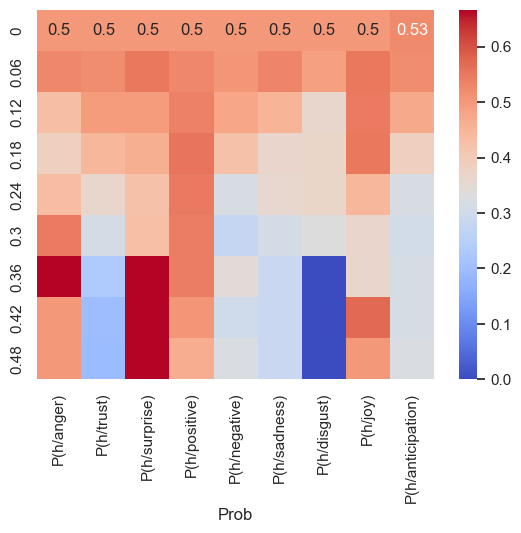

In [4374]:
sns.heatmap(xx,annot=True, cmap='coolwarm')

In [ ]:
data_amazon_json_df_pat

Unnamed: 0             reviewerID        asin  \
0              0  A10000012B7CGYKOMPQ4L  000100039X   
1              1         A2S166WSCFIFP5  000100039X   
2              2         A1BM81XB4QHOA3  000100039X   
3              3         A1MOSTXNIO5MPJ  000100039X   
4              4         A2XQ5LZHTD4AFT  000100039X   
...          ...                    ...         ...   
6995        6995         A2Q3D3CC9HT0S5  000612609X   
6996        6996         A2DG7FHNHVX0Q8  000612609X   
6997        6997         A2B1RCJ5JJ42M5  000612609X   
6998        6998         A1UQ0R3JYNMPJJ  000612609X   
6999        6999         A3U4FCEAT75XLS  000612609X   

                                         reviewerName helpful  \
0                                                Adam  [0, 0]   
1     adead_poet@hotmail.com "adead_poet@hotmail.com"  [0, 2]   
2                         Ahoro Blethends "Seriously"  [0, 0]   
3                                           Alan Krug  [0, 0]   
4                                            Alaturka  [7, 9]   
...                                               ...     ...   
6995                                       C. Hurwitz  [0, 0]   
6996                                          Colin R  [0, 0]   
6997                                        Comfort55  [0, 0]   
6998                                  C. Star "C R E"  [0, 0]   
6999                                         Cynesige  [3, 3]   

                                             reviewText  overall  \
0     Spiritually and mentally inspiring! A book tha...      5.0   
1     This is one my must have books. It is a master...      5.0   
2     This book provides a reflection that you can a...      5.0   
3     I first read THE PROPHET in college back in th...      5.0   
4     A timeless classic.  It is a very demanding an...      5.0   
...                                                 ...      ...   
6995  Everything you could ask for in a novel; inter...      5.0   
6996  Written in a different style to more modern wr...      4.0   
6997  THIS IS A WELL WRITTEN HISTORICAL FICTIONAL AC...      4.0   
6998  As many others have said, this is an epic book...      5.0   
6999  This AMAZING book, written in the 1940s, trans...      5.0   

                                                summary  unixReviewTime  \
0                                            Wonderful!      1355616000   
1                                          close to god      1071100800   
2                       Must Read for Life Afficianados      1390003200   
3     Timeless for every good and bad time in your l...      1317081600   
4                                         A Modern Rumi      1033948800   
...                                                 ...             ...   
6995                                   Simply excellent      1359504000   
6996  however once got in to the writing style it wa...      1398556800   
6997                      GREAT FOR READERS OF THIS ERA      1355961600   
6998                                  When men were men      1386633600   
6999  Just about the most fun you can have reading a...      1295654400   

       reviewTime  ... ppp  nnn  nnp  ppn  pnnp  nppn  nnppnn  ppnnpp  \
0     12 16, 2012  ...   0    0    0    0     0     0       0       0   
1     12 11, 2003  ...   1    0    0    1     0     0       0       0   
2     01 18, 2014  ...   0    0    0    0     0     0       0       0   
3     09 27, 2011  ...   0    0    1    1     0     1       0       0   
4      10 7, 2002  ...   0    0    0    1     0     1       0       0   
...           ...  ...  ..  ...  ...  ...   ...   ...     ...     ...   
6995  01 30, 2013  ...   0    0    0    0     0     0       0       0   
6996  04 27, 2014  ...   0    0    0    0     0     0       0       0   
6997  12 20, 2012  ...   0    0    0    0     0     0       0       0   
6998  12 10, 2013  ...   1    1    1    1     0     0       0       0   
6999  01 22, 2011  ...   2    0    0    3  

In [3]:
#data_amazon  = pd.read_csv('amazon_reviews.csv').sample(5000)
#data_amazon.to_csv("sampled_reviews.csv")
#data_amazon  = pd.read_csv('sampled_reviews.csv')

## We read the data from json file- amazon reviews with helpful scores




In [2489]:
data_amazon

Unnamed: 0             reviewerID        asin  \
0              0  A10000012B7CGYKOMPQ4L  000100039X   
1              1         A2S166WSCFIFP5  000100039X   
2              2         A1BM81XB4QHOA3  000100039X   
3              3         A1MOSTXNIO5MPJ  000100039X   
4              4         A2XQ5LZHTD4AFT  000100039X   
...          ...                    ...         ...   
6995        6995         A2Q3D3CC9HT0S5  000612609X   
6996        6996         A2DG7FHNHVX0Q8  000612609X   
6997        6997         A2B1RCJ5JJ42M5  000612609X   
6998        6998         A1UQ0R3JYNMPJJ  000612609X   
6999        6999         A3U4FCEAT75XLS  000612609X   

                                         reviewerName helpful  \
0                                                Adam  [0, 0]   
1     adead_poet@hotmail.com "adead_poet@hotmail.com"  [0, 2]   
2                         Ahoro Blethends "Seriously"  [0, 0]   
3                                           Alan Krug  [0, 0]   
4                                            Alaturka  [7, 9]   
...                                               ...     ...   
6995                                       C. Hurwitz  [0, 0]   
6996                                          Colin R  [0, 0]   
6997                                        Comfort55  [0, 0]   
6998                                  C. Star "C R E"  [0, 0]   
6999                                         Cynesige  [3, 3]   

                                                 review  overall  \
0     Spiritually and mentally inspiring! A book tha...      5.0   
1     This is one my must have books. It is a master...      5.0   
2     This book provides a reflection that you can a...      5.0   
3     I first read THE PROPHET in college back in th...      5.0   
4     A timeless classic.  It is a very demanding an...      5.0   
...                                                 ...      ...   
6995  Everything you could ask for in a novel; inter...      5.0   
6996  Written in a different style to more modern wr...      4.0   
6997  THIS IS A WELL WRITTEN HISTORICAL FICTIONAL AC...      4.0   
6998  As many others have said, this is an epic book...      5.0   
6999  This AMAZING book, written in the 1940s, trans...      5.0   

                                                summary  unixReviewTime  \
0                                            Wonderful!      1355616000   
1                                          close to god      1071100800   
2                       Must Read for Life Afficianados      1390003200   
3     Timeless for every good and bad time in your l...      1317081600   
4                                         A Modern Rumi      1033948800   
...                                                 ...             ...   
6995                                   Simply excellent      1359504000   
6996  however once got in to the writing style it wa...      1398556800   
6997                      GREAT FOR READERS OF THIS ERA      1355961600   
6998                                  When men were men      1386633600   
6999  Just about the most fun you can have reading a...      1295654400   

       reviewTime  ... ppp  nnn  nnp  ppn  pnnp  nppn  nnppnn  ppnnpp  \
0     12 16, 2012  ...   0    0    0    0     0     0       0       0   
1     12 11, 2003  ...   1    0    0    1     0     0       0       0   
2     01 18, 2014  ...   0    0    0    0     0     0       0       0   
3     09 27, 2011  ...   0    0    1    1     0     1       0       0   
4      10 7, 2002  ...   0    0    0    1     0     1       0       0   
...           ...  ...  ..  ...  ...  ...   ...   ...     ...     ...   
6995  01 30, 2013  ...   0    0    0    0     0     0       0       0   
6996  04 27, 2014  ...   0    0    0    0     0     0       0       0   
6997  12 20, 2012  ...   0    0    0    0     0     0       0       0   
6998  12 10, 2013  ...   1    1    1    1     0     0       0       0   
6999  01 22, 2011  ...   2    0    0    3  

In [8]:
#data_amazon = pd.concat([data_amazon, data_amazon['review'].apply(return_emopattern)], axis=1)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/var/folders/wc/3lttp9mx3ps_jqd1xzsfrct80000gn/T/ipykernel_80929/711246921.py:1: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  data_amazon = pd.concat([data_amazon, data_amazon['review'].apply(return_emopattern)], axis=1)


In [2257]:
#data_amazon.to_csv('data_amazon.csv')
data_amazon = pd.read_csv('data_amazon_json_df.csv') # pd.read_csv('data_amazon.csv')

In [2258]:
data_amazon

Unnamed: 0             reviewerID        asin  \
0              0  A10000012B7CGYKOMPQ4L  000100039X   
1              1         A2S166WSCFIFP5  000100039X   
2              2         A1BM81XB4QHOA3  000100039X   
3              3         A1MOSTXNIO5MPJ  000100039X   
4              4         A2XQ5LZHTD4AFT  000100039X   
...          ...                    ...         ...   
6995        6995         A2Q3D3CC9HT0S5  000612609X   
6996        6996         A2DG7FHNHVX0Q8  000612609X   
6997        6997         A2B1RCJ5JJ42M5  000612609X   
6998        6998         A1UQ0R3JYNMPJJ  000612609X   
6999        6999         A3U4FCEAT75XLS  000612609X   

                                         reviewerName helpful  \
0                                                Adam  [0, 0]   
1     adead_poet@hotmail.com "adead_poet@hotmail.com"  [0, 2]   
2                         Ahoro Blethends "Seriously"  [0, 0]   
3                                           Alan Krug  [0, 0]   
4                                            Alaturka  [7, 9]   
...                                               ...     ...   
6995                                       C. Hurwitz  [0, 0]   
6996                                          Colin R  [0, 0]   
6997                                        Comfort55  [0, 0]   
6998                                  C. Star "C R E"  [0, 0]   
6999                                         Cynesige  [3, 3]   

                                             reviewText  overall  \
0     Spiritually and mentally inspiring! A book tha...      5.0   
1     This is one my must have books. It is a master...      5.0   
2     This book provides a reflection that you can a...      5.0   
3     I first read THE PROPHET in college back in th...      5.0   
4     A timeless classic.  It is a very demanding an...      5.0   
...                                                 ...      ...   
6995  Everything you could ask for in a novel; inter...      5.0   
6996  Written in a different style to more modern wr...      4.0   
6997  THIS IS A WELL WRITTEN HISTORICAL FICTIONAL AC...      4.0   
6998  As many others have said, this is an epic book...      5.0   
6999  This AMAZING book, written in the 1940s, trans...      5.0   

                                                summary  unixReviewTime  \
0                                            Wonderful!      1355616000   
1                                          close to god      1071100800   
2                       Must Read for Life Afficianados      1390003200   
3     Timeless for every good and bad time in your l...      1317081600   
4                                         A Modern Rumi      1033948800   
...                                                 ...             ...   
6995                                   Simply excellent      1359504000   
6996  however once got in to the writing style it wa...      1398556800   
6997                      GREAT FOR READERS OF THIS ERA      1355961600   
6998                                  When men were men      1386633600   
6999  Just about the most fun you can have reading a...      1295654400   

       reviewTime              emopattern  emoscore  
0     12 16, 2012                     spn  0.091968  
1     12 11, 2003                  sppppn  0.603524  
2     01 18, 2014                      sp  0.092623  
3     09 27, 2011               snnppnpnp  0.169401  
4      10 7, 2002              spnppnpnpp  0.097563  
...           ...                     ...       ...  
6995  01 30, 2013                     snp  0.158515  
6996  04 27, 2014                      sp  0.045258  
6997  12 20, 2012                     spn  0.354441  
6998  12 10, 2013             snppppnnnpn  0.039345  
6999  01 22, 2011  sppnppnpnpppppppnpnpnn  0.308493  

[7000 rows x 12 columns]

In [2259]:
import re

In [2260]:
def return_pattern_match(text):
    pattern_pnp = r'pnp'
    pattern_npn = r'npn'
    pattern_ppp = r'ppp'
    pattern_nnn = r'nnn'
    pattern_nnp = r'nnp'
    pattern_ppn = r'ppn'
    pattern_pnpn = r'pnpn'
    pattern_npnp = r'npnp'
    pattern_pnnp = r'pnnp'
    pattern_nppn = r'nppn'
    pattern_nnppnn = r'nnppnn'
    pattern_ppnnpp = r'ppnnpp'
    return pd.Series({'pnp':len(re.findall(pattern_pnp,text)),'npn':len(re.findall(pattern_npn,text)),
                      'pnpn':len(re.findall(pattern_pnpn,text)),'npnp':len(re.findall(pattern_npnp,text)),
                      'ppp':len(re.findall(pattern_ppp,text)),'nnn':len(re.findall(pattern_nnn,text)),
                        'nnp':len(re.findall(pattern_nnp,text)),'ppn':len(re.findall(pattern_ppn,text)),
                        'pnnp':len(re.findall(pattern_pnnp,text)),'nppn':len(re.findall(pattern_nppn,text)),
                        'nnppnn':len(re.findall(pattern_nnppnn,text)),'ppnnpp':len(re.findall(pattern_ppnnpp,text))})

In [2261]:
data_amazon = pd.concat([data_amazon, data_amazon['emopattern'].apply(return_pattern_match)], axis=1)

In [2262]:
data_amazon[data_amazon['pnp']==1].head()

Unnamed: 0      reviewerID        asin     reviewerName helpful  \
3            3  A1MOSTXNIO5MPJ  000100039X        Alan Krug  [0, 0]   
13          13  A2I35JB67U20C0  000100039X  Amazon Customer  [0, 0]   
14          14  A19N3FCQCLJYUA  000100039X  Amazon Customer  [1, 1]   
17          17  A2X4HE21JTAL98  000100039X      Antiquarian  [3, 5]   
18          18   ARDQ9KNB8K22N  000100039X            Anwar  [1, 1]   

                                           reviewText  overall  \
3   I first read THE PROPHET in college back in th...      5.0   
13  When I was in college in the 70's this book ha...      5.0   
14  I discovered The Prophet fifty years ago in co...      5.0   
17  Anything I've read by Gibran is, in my mind, f...      5.0   
18  Cool book, I really like the quality of the pr...      5.0   

                                              summary  unixReviewTime  \
3   Timeless for every good and bad time in your l...      1317081600   
13                     Everyone should have this book       983318400   
14              A book everyone &#34;should&#34; read      1358899200   
17                                           Flawless      1132099200   
18                              "The Prophet" is cool      1329264000   

     reviewTime  ... pnpn  npnp  ppp  nnn  nnp  ppn  pnnp  nppn  nnppnn  \
3   09 27, 2011  ...    1     1    0    0    1    1     0     1       0   
13  02 28, 2001  ...    0     0    0    0    0    1     0     0       0   
14  01 23, 2013  ...    0     1    0    1    1    0     0     0       0   
17  11 16, 2005  ...    0     0    0    0    0    1     0     1       0   
18  02 15, 2012  ...    0     0    2    0    1    2     1     0       0   

    ppnnpp  
3        0  
13       0  
14       0  
17       0  
18       1  

[5 rows x 24 columns]

In [2263]:
data_amazon[data_amazon['npn']==1].head()

Unnamed: 0      reviewerID        asin         reviewerName   helpful  \
3            3  A1MOSTXNIO5MPJ  000100039X            Alan Krug    [0, 0]   
4            4  A2XQ5LZHTD4AFT  000100039X             Alaturka    [7, 9]   
23          23  A1KQ80Y692CDOI  000100039X                Atown    [2, 9]   
34          34  A1NPNGWBVD9AK3  000100039X  Bruce Kendall "BEK"  [81, 92]   
41          41  A3BHSR8LON67NA  000100039X            chemgrl08    [0, 0]   

                                           reviewText  overall  \
3   I first read THE PROPHET in college back in th...      5.0   
4   A timeless classic.  It is a very demanding an...      5.0   
23  I read this about a year ago and can't recall ...      2.0   
34  This is one of the first (literary) books I re...      5.0   
41  This book was great; each chapter was a nugget...      5.0   

                                              summary  unixReviewTime  \
3   Timeless for every good and bad time in your l...      1317081600   
4                                       A Modern Rumi      1033948800   
23                                           Eloquent      1206057600   
34                                      Simple Wisdom       961804800   
41                    Deserves the title of "Classic"      1380758400   

     reviewTime  ... pnpn  npnp  ppp  nnn  nnp  ppn  pnnp  nppn  nnppnn  \
3   09 27, 2011  ...    1     1    0    0    1    1     0     1       0   
4    10 7, 2002  ...    1     1    0    0    0    1     0     1       0   
23  03 21, 2008  ...    1     1    1    0    0    1     0     0       0   
34  06 24, 2000  ...    0     0    2    1    2    2     0     0       0   
41   10 3, 2013  ...    1     1    0    0    0    1     0     0       0   

    ppnnpp  
3        0  
4        0  
23       0  
34       0  
41       0  

[5 rows x 24 columns]

In [2264]:
data_amazon[data_amazon['ppp']==1].head()

Unnamed: 0      reviewerID        asin  \
1            1  A2S166WSCFIFP5  000100039X   
15          15  A3FFNE1DR5SI1W  000100039X   
16          16  A1TT4CY55WLHAR  000100039X   
23          23  A1KQ80Y692CDOI  000100039X   
29          29  A2RC16D2R9LXGW  000100039X   

                                       reviewerName helpful  \
1   adead_poet@hotmail.com "adead_poet@hotmail.com"  [0, 2]   
15                                       A. Morelli  [1, 1]   
16                                        anonymous  [0, 0]   
23                                            Atown  [2, 9]   
29                         Bertram Telemaque "Flex"  [0, 0]   

                                           reviewText  overall  \
1   This is one my must have books. It is a master...      5.0   
15  Can't say enough about Kahlil Gibran's work am...      5.0   
16  I have the 1972 version, bought in 1974. The 1...      5.0   
23  I read this about a year ago and can't recall ...      2.0   
29  I bought this book to supplement a recording I...      5.0   

                                              summary  unixReviewTime  \
1                                        close to god      1071100800   
15                    phenomenal piece of literature!      1340755200   
16  textured paper, old-style typography, and leat...      1342396800   
23                                           Eloquent      1206057600   
29                        A Book of Great Inspiration      1390694400   

     reviewTime  ... pnpn  npnp  ppp  nnn  nnp  ppn  pnnp  nppn  nnppnn  \
1   12 11, 2003  ...    0     0    1    0    0    1     0     0       0   
15  06 27, 2012  ...    0     0    1    0    0    0     0     0       0   
16  07 16, 2012  ...    0     0    1    0    0    0     0     0       0   
23  03 21, 2008  ...    1     1    1    0    0    1     0     0       0   
29  01 26, 2014  ...    0     0    1    0    0    0     0     0       0   

    ppnnpp  
1        0  
15       0  
16       0  
23       0  
29       0  

[5 rows x 24 columns]

In [2265]:
data_amazon[data_amazon['nnn']==1].head()

Unnamed: 0      reviewerID        asin  \
8            8  A3FI0744PG1WYG  000100039X   
14          14  A19N3FCQCLJYUA  000100039X   
25          25   AF7CSSGV93RXN  000100039X   
34          34  A1NPNGWBVD9AK3  000100039X   
38          38  A393EJD130USD6  000100039X   

                               reviewerName   helpful  \
8                      Always Reading "tkm"    [0, 0]   
14                          Amazon Customer    [1, 1]   
25  A. William Benitez "A. William Benitez"    [5, 6]   
34                      Bruce Kendall "BEK"  [81, 92]   
38                      C. Doke "crayt1024"    [0, 0]   

                                           reviewText  overall  \
8   This is a timeless classic.  Over the years I'...      5.0   
14  I discovered The Prophet fifty years ago in co...      5.0   
25  I first read The Prophet by Kahlil Gibran over...      5.0   
34  This is one of the first (literary) books I re...      5.0   
38  Intrinsically, this book utilizes a flowing a ...      5.0   

                                  summary  unixReviewTime   reviewTime  ...  \
8                             The Prophet      1390953600  01 29, 2014  ...   
14  A book everyone &#34;should&#34; read      1358899200  01 23, 2013  ...   
25                    A Great Little Gift      1331510400  03 12, 2012  ...   
34                          Simple Wisdom       961804800  06 24, 2000  ...   
38                                Elegant       992908800  06 19, 2001  ...   

   pnpn  npnp  ppp  nnn  nnp  ppn  pnnp  nppn  nnppnn  ppnnpp  
8     0     0    0    1    0    0     0     0       0       0  
14    0     1    0    1    1    0     0     0       0       0  
25    0     0    0    1    1    0     0     0       0       0  
34    0     0    2    1    2    2     0     0       0       0  
38    0     0    0    1    0    0     0     0       0       0  

[5 rows x 24 columns]

In [2266]:
data_amazon[data_amazon['pnpn']==1].head()

Unnamed: 0      reviewerID        asin              reviewerName  helpful  \
3            3  A1MOSTXNIO5MPJ  000100039X                 Alan Krug   [0, 0]   
4            4  A2XQ5LZHTD4AFT  000100039X                  Alaturka   [7, 9]   
23          23  A1KQ80Y692CDOI  000100039X                     Atown   [2, 9]   
41          41  A3BHSR8LON67NA  000100039X                 chemgrl08   [0, 0]   
43          43  A3IS4WGMFR4X65  000100039X  Colin Lewis "WisdomNote"  [8, 10]   

                                           reviewText  overall  \
3   I first read THE PROPHET in college back in th...      5.0   
4   A timeless classic.  It is a very demanding an...      5.0   
23  I read this about a year ago and can't recall ...      2.0   
41  This book was great; each chapter was a nugget...      5.0   
43  The Prophet is Kahlil Gibran's best known work...      5.0   

                                              summary  unixReviewTime  \
3   Timeless for every good and bad time in your l...      1317081600   
4                                       A Modern Rumi      1033948800   
23                                           Eloquent      1206057600   
41                    Deserves the title of "Classic"      1380758400   
43                  The most loving book ever written      1256601600   

     reviewTime  ... pnpn  npnp  ppp  nnn  nnp  ppn  pnnp  nppn  nnppnn  \
3   09 27, 2011  ...    1     1    0    0    1    1     0     1       0   
4    10 7, 2002  ...    1     1    0    0    0    1     0     1       0   
23  03 21, 2008  ...    1     1    1    0    0    1     0     0       0   
41   10 3, 2013  ...    1     1    0    0    0    1     0     0       0   
43  10 27, 2009  ...    1     1    0    1    3    0     1     0       0   

    ppnnpp  
3        0  
4        0  
23       0  
41       0  
43       0  

[5 rows x 24 columns]

In [2267]:
data_amazon[data_amazon['npnp']==1].head()

Unnamed: 0      reviewerID        asin     reviewerName helpful  \
3            3  A1MOSTXNIO5MPJ  000100039X        Alan Krug  [0, 0]   
4            4  A2XQ5LZHTD4AFT  000100039X         Alaturka  [7, 9]   
14          14  A19N3FCQCLJYUA  000100039X  Amazon Customer  [1, 1]   
23          23  A1KQ80Y692CDOI  000100039X            Atown  [2, 9]   
41          41  A3BHSR8LON67NA  000100039X        chemgrl08  [0, 0]   

                                           reviewText  overall  \
3   I first read THE PROPHET in college back in th...      5.0   
4   A timeless classic.  It is a very demanding an...      5.0   
14  I discovered The Prophet fifty years ago in co...      5.0   
23  I read this about a year ago and can't recall ...      2.0   
41  This book was great; each chapter was a nugget...      5.0   

                                              summary  unixReviewTime  \
3   Timeless for every good and bad time in your l...      1317081600   
4                                       A Modern Rumi      1033948800   
14              A book everyone &#34;should&#34; read      1358899200   
23                                           Eloquent      1206057600   
41                    Deserves the title of "Classic"      1380758400   

     reviewTime  ... pnpn  npnp  ppp  nnn  nnp  ppn  pnnp  nppn  nnppnn  \
3   09 27, 2011  ...    1     1    0    0    1    1     0     1       0   
4    10 7, 2002  ...    1     1    0    0    0    1     0     1       0   
14  01 23, 2013  ...    0     1    0    1    1    0     0     0       0   
23  03 21, 2008  ...    1     1    1    0    0    1     0     0       0   
41   10 3, 2013  ...    1     1    0    0    0    1     0     0       0   

    ppnnpp  
3        0  
4        0  
14       0  
23       0  
41       0  

[5 rows x 24 columns]

In [2268]:
import matplotlib.pyplot as plt

In [2269]:
data_amazon['Total_deep_patterns']= data_amazon['npn']+data_amazon['pnp']+data_amazon['nppn']+data_amazon['pnnp']+data_amazon['nnppnn']+data_amazon['ppnnpp']


In [2270]:
pattern_list = ['npn','pnp','nppn','pnnp','nnppnn','ppnnpp','ppn','nnp','nnn','ppp']

In [2271]:
data_amazon.sort_values(by = 'Total_deep_patterns', ascending= False).head()

Unnamed: 0      reviewerID        asin  \
5743        5743  A2YUZKPLUYQDKV  0002247399   
5900        5900  A26KR9L8E16F2X  0002247399   
5666        5666  A3E8SA59I60VYX  0002247399   
5360        5360  A3HBNOC6ANFNSK  0002247399   
5585        5585   APSPHFJV4X85P  0002247399   

                                          reviewerName   helpful  \
5743                                 Michael Battaglia  [15, 41]   
5900  Patrick St-Denis "editor of Pat's Fantasy Hot...   [3, 20]   
5666                               Mark Andrew Edwards   [9, 11]   
5360                                  Jonathan C. Pike  [10, 10]   
5585                       Little Angie "Little Angie"    [5, 7]   

                                             reviewText  overall  \
5743  Wow, that's a pretty even spread of reviews, i...      5.0   
5900  Yes, it's been a long wait. To tell the truth,...      4.0   
5666  It's hard to overstate just how much I have be...      4.0   
5360  So, like most here, I'm a big GRRM fan.  We al...      1.0   
5585  I want to start by saying that whenever I fini...      3.0   

                                                summary  unixReviewTime  \
5743  The problem is the dragons want to start a mos...      1313452800   
5900                                  Hard to put down!      1344643200   
5666                           Sex and Death and Horror      1311638400   
5360   A Dance through night soil... from a leal reader      1362700800   
5585  Epic Saga of How House Targaryen Got its Thron...      1313107200   

       reviewTime  ... npnp  ppp  nnn  nnp  ppn  pnnp  nppn  nnppnn  ppnnpp  \
5743  08 16, 2011  ...    5    6    5   13   12     7     6       2       2   
5900  08 11, 2012  ...    5   10    4    8   15     4     6       1       1   
5666  07 26, 2011  ...    2    7    1    9   10     6     4       1       2   
5360   03 8, 2013  ...    4    3    2    6    9     4     5       0       0   
5585  08 12, 2011  ...    3    6    5   11    8     6     2       1       1   

      Total_deep_patterns  
5743                   35  
5900                   32  
5666                   27  
5360                   24  
5585                   23  

[5 rows x 25 columns]

In [2272]:
data_amazon[pattern_list].sum()

npn       2992
pnp       3993
nppn      1455
pnnp      1660
nnppnn     211
ppnnpp     403
ppn       4676
nnp       3684
nnn       1950
ppp       3879
dtype: int64

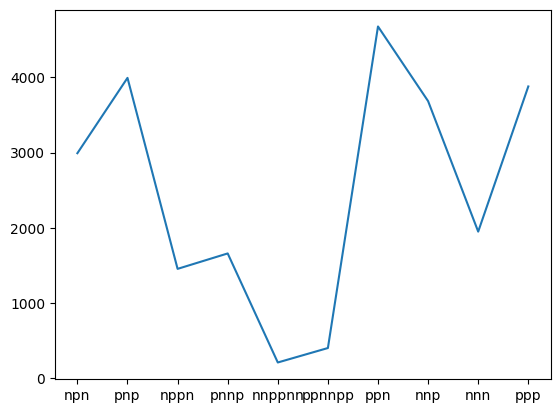

In [2273]:
plt.plot(data_amazon[pattern_list].sum())


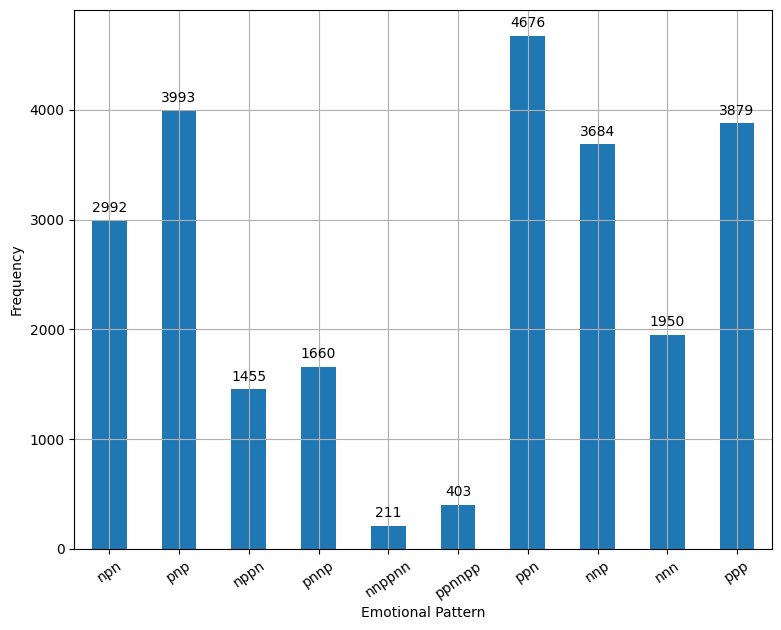

In [2274]:
data_analysis = pd.DataFrame(data_amazon[pattern_list].sum())
data_analysis1 = data_analysis.reset_index()
df_patt1 = data_analysis1.rename(columns={'index':'pattern',0:'freq'})
#ax = plt.bar(data_analysis.index,data_analysis[0])
ax = df_patt1.plot(kind='bar', x='pattern', y='freq', figsize=(9,7),legend=False)
data = {'Category': ['A', 'B', 'C', 'D'],
        'Values': [10, 20, 15, 30]}
for p in ax.patches:
    ax.annotate(format(p.get_height(), ''), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.xticks(rotation=35)
plt.grid(True)
plt.xlabel('Emotional Pattern')
plt.ylabel('Frequency')
plt.show()



In [2279]:
data_amazon = data_amazon.rename(columns = {'reviewText':'review'})

## Wordcloud analysis

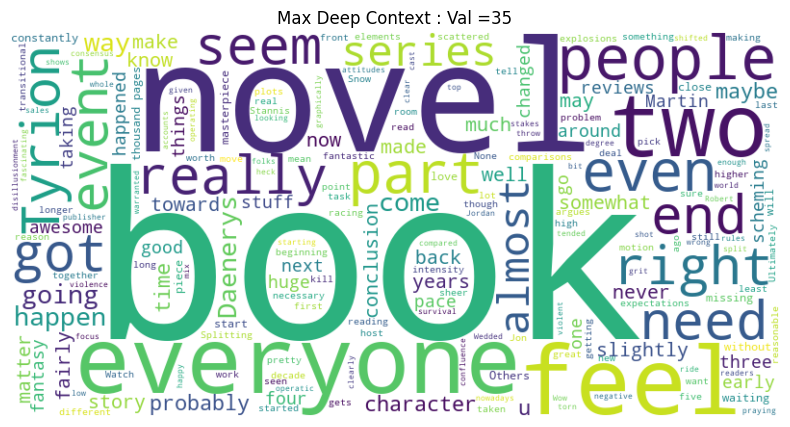

In [2280]:
from wordcloud import WordCloud
text_column = data_amazon['review'][data_amazon['Total_deep_patterns']>=data_amazon['Total_deep_patterns'].max()]
# Combine the text from the column into a single string
text_corpus = ' '.join(text_column)
# Create a WordCloud object with optional customization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Max Deep Context : Val =' +str(data_amazon['Total_deep_patterns'].max()))
plt.axis('off')  # Turn off the axis labels
plt.show()

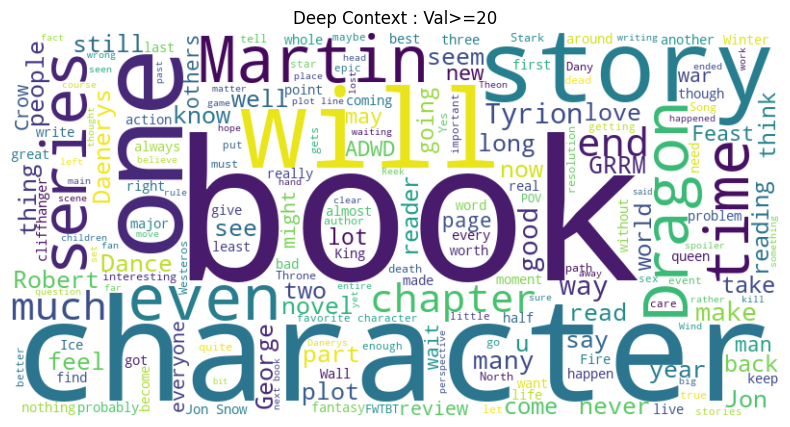

In [2285]:
text_column = data_amazon['review'][data_amazon['Total_deep_patterns']>=20]
# Combine the text from the column into a single string
text_corpus = ' '.join(text_column)
# Create a WordCloud object with optional customization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Deep Context : Val>=20')
plt.axis('off')  # Turn off the axis labels
plt.show()

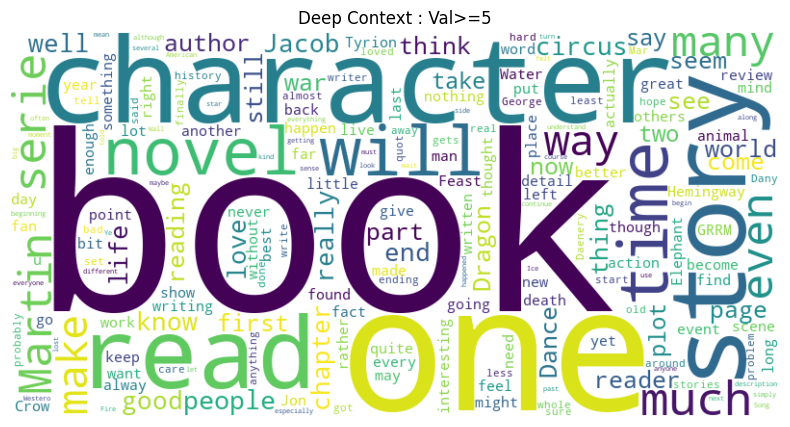

In [2286]:
text_column = data_amazon['review'][data_amazon['Total_deep_patterns']>=5]
# Combine the text from the column into a single string
text_corpus = ' '.join(text_column)
# Create a WordCloud object with optional customization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Deep Context : Val>=5')
plt.axis('off')  # Turn off the axis labels
plt.show()

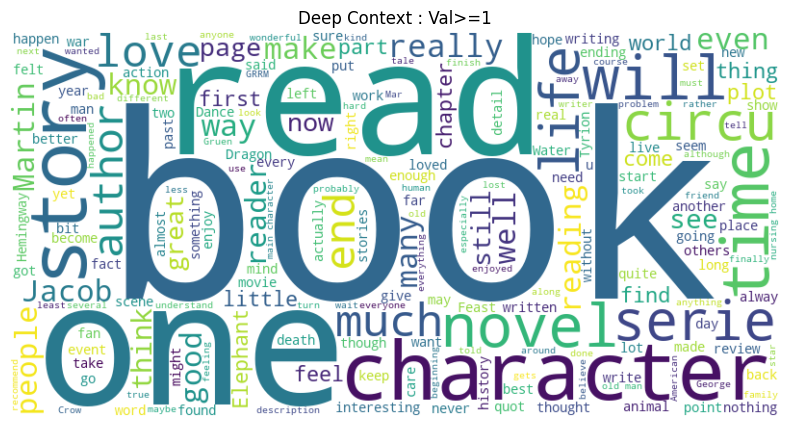

In [2287]:
text_column = data_amazon['review'][data_amazon['Total_deep_patterns']>=1]
# Combine the text from the column into a single string
text_corpus = ' '.join(text_column)
# Create a WordCloud object with optional customization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Deep Context : Val>=1')
plt.axis('off')  # Turn off the axis labels
plt.show()

# Find Emotions in the Patterns 
## Using NRC Lexicon

In [34]:
!pip install nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [35]:
!pip install nrcLex

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [36]:
from nrclex import NRCLex

In [37]:
import nltk

In [38]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amitobe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/amitobe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
!pip install spacy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [41]:
import spacy


In [42]:
from nltk.corpus import stopwords
#from nltk.corpus import NRC_Emotion
from collections import defaultdict

In [43]:
# Load the spaCy English model
nlp = spacy
# Load the NRC Emotion Lexicon
nrc_lexicon = NRCLex

In [44]:
def return_nrc_emo (txt):
    emo = nrc_lexicon(txt)
    return pd.Series(emo.affect_frequencies)

In [2361]:
data_amazon_nrc = pd.concat([data_amazon,data_amazon['review'].apply(return_nrc_emo)],axis=1)

data_amazon_nrc = pd.concat([data_amazon,data_amazon['review'].apply(return_sen_level_nrc_emo)],axis=1)

In [2362]:
data_amazon_nrc.columns

Index(['Unnamed: 0', 'reviewerID', 'asin', 'reviewerName', 'helpful', 'review',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'emopattern',
       'emoscore', 'pnp', 'npn', 'pnpn', 'npnp', 'ppp', 'nnn', 'nnp', 'ppn',
       'pnnp', 'nppn', 'nnppnn', 'ppnnpp', 'Total_deep_patterns', 'fear',
       'anger', 'anticip', 'trust', 'surprise', 'positive', 'negative',
       'sadness', 'disgust', 'joy', 'anticipation'],
      dtype='object')

In [2363]:
data_amazon_nrc.fillna(0, inplace=True)

In [2364]:
data_amazon_nrc.head()

Unnamed: 0             reviewerID        asin  \
0           0  A10000012B7CGYKOMPQ4L  000100039X   
1           1         A2S166WSCFIFP5  000100039X   
2           2         A1BM81XB4QHOA3  000100039X   
3           3         A1MOSTXNIO5MPJ  000100039X   
4           4         A2XQ5LZHTD4AFT  000100039X   

                                      reviewerName helpful  \
0                                             Adam  [0, 0]   
1  adead_poet@hotmail.com "adead_poet@hotmail.com"  [0, 2]   
2                      Ahoro Blethends "Seriously"  [0, 0]   
3                                        Alan Krug  [0, 0]   
4                                         Alaturka  [7, 9]   

                                              review  overall  \
0  Spiritually and mentally inspiring! A book tha...      5.0   
1  This is one my must have books. It is a master...      5.0   
2  This book provides a reflection that you can a...      5.0   
3  I first read THE PROPHET in college back in th...      5.0   
4  A timeless classic.  It is a very demanding an...      5.0   

                                             summary  unixReviewTime  \
0                                         Wonderful!      1355616000   
1                                       close to god      1071100800   
2                    Must Read for Life Afficianados      1390003200   
3  Timeless for every good and bad time in your l...      1317081600   
4                                      A Modern Rumi      1033948800   

    reviewTime  ...     anger  anticip     trust  surprise  positive  \
0  12 16, 2012  ...  0.125000      0.0  0.125000  0.125000  0.250000   
1  12 11, 2003  ...  0.083333      0.0  0.166667  0.000000  0.250000   
2  01 18, 2014  ...  0.000000      0.0  0.000000  0.000000  0.000000   
3  09 27, 2011  ...  0.023256      0.0  0.186047  0.046512  0.232558   
4   10 7, 2002  ...  0.000000      0.0  0.302326  0.093023  0.302326   

   negative   sadness   disgust       joy  anticipation  
0  0.000000  0.000000  0.125000  0.125000      0.125000  
1  0.000000  0.000000  0.083333  0.250000      0.083333  
2  0.000000  0.000000  0.000000  0.000000      1.000000  
3  0.069767  0.046512  0.000000  0.139535      0.162791  
4  0.023256  0.023256  0.000000  0.139535      0.069767  

[5 rows x 36 columns]

In [2365]:
emo_list = ['anger','trust','surprise','positive','negative','sadness','disgust','joy','anticipation']

In [2366]:
data_amazon_nrc[data_amazon_nrc['Total_deep_patterns']>=25][emo_list].mean()

anger           0.051505
trust           0.133962
surprise        0.046922
positive        0.213365
negative        0.147588
sadness         0.080715
disgust         0.040412
joy             0.077333
anticipation    0.134997
dtype: float64

In [2367]:
data_amazon_nrc.to_csv('data_amazon_nrc.csv')

In [2368]:
data_amazon_bala

Unnamed: 0             reviewerID        asin  \
0              0  A10000012B7CGYKOMPQ4L  000100039X   
1              1         A2S166WSCFIFP5  000100039X   
2              2         A1BM81XB4QHOA3  000100039X   
3              3         A1MOSTXNIO5MPJ  000100039X   
4              4         A2XQ5LZHTD4AFT  000100039X   
...          ...                    ...         ...   
6995        6995         A2Q3D3CC9HT0S5  000612609X   
6996        6996         A2DG7FHNHVX0Q8  000612609X   
6997        6997         A2B1RCJ5JJ42M5  000612609X   
6998        6998         A1UQ0R3JYNMPJJ  000612609X   
6999        6999         A3U4FCEAT75XLS  000612609X   

                                         reviewerName helpful  \
0                                                Adam  [0, 0]   
1     adead_poet@hotmail.com "adead_poet@hotmail.com"  [0, 2]   
2                         Ahoro Blethends "Seriously"  [0, 0]   
3                                           Alan Krug  [0, 0]   
4                                            Alaturka  [7, 9]   
...                                               ...     ...   
6995                                       C. Hurwitz  [0, 0]   
6996                                          Colin R  [0, 0]   
6997                                        Comfort55  [0, 0]   
6998                                  C. Star "C R E"  [0, 0]   
6999                                         Cynesige  [3, 3]   

                                                 review  overall  \
0     Spiritually and mentally inspiring! A book tha...      5.0   
1     This is one my must have books. It is a master...      5.0   
2     This book provides a reflection that you can a...      5.0   
3     I first read THE PROPHET in college back in th...      5.0   
4     A timeless classic.  It is a very demanding an...      5.0   
...                                                 ...      ...   
6995  Everything you could ask for in a novel; inter...      5.0   
6996  Written in a different style to more modern wr...      4.0   
6997  THIS IS A WELL WRITTEN HISTORICAL FICTIONAL AC...      4.0   
6998  As many others have said, this is an epic book...      5.0   
6999  This AMAZING book, written in the 1940s, trans...      5.0   

                                                summary  unixReviewTime  \
0                                            Wonderful!      1355616000   
1                                          close to god      1071100800   
2                       Must Read for Life Afficianados      1390003200   
3     Timeless for every good and bad time in your l...      1317081600   
4                                         A Modern Rumi      1033948800   
...                                                 ...             ...   
6995                                   Simply excellent      1359504000   
6996  however once got in to the writing style it wa...      1398556800   
6997                      GREAT FOR READERS OF THIS ERA      1355961600   
6998                                  When men were men      1386633600   
6999  Just about the most fun you can have reading a...      1295654400   

       reviewTime  ...     anger  anticip     trust  surprise  positive  \
0     12 16, 2012  ...  0.125000      0.0  0.125000  0.125000  0.250000   
1     12 11, 2003  ...  0.083333      0.0  0.166667  0.000000  0.250000   
2     01 18, 2014  ...  0.000000      0.0  0.000000  0.000000  0.000000   
3     09 27, 2011  ...  0.023256      0.0  0.186047  0.046512  0.232558   
4      10 7, 2002  ...  0.000000      0.0  0.302326  0.093023  0.302326   
...           ...  ...       ...      ...       ...       ...       ...   
6995  01 30, 2013  ...  0.000000      0.0  0.166667  0.166667  0.333333   
6996  04 27, 2014  ...  0.000000      0.0  0.200000  0.200000  0.200000   
6997  12 20, 2012  ...  0.000000      0.0  0.000000  0.000000  0.000000   
6998  12 10, 2013  ...  0.068966      0.0  0.172414  0.068966  0.379310   
6999  01 22, 2011  ..

In [2369]:
threshold_no_pats = 0
coln_lst = ['Emopattern']+emo_list
df = pd.DataFrame(columns=coln_lst)
for pat in pattern_list:
    df1 = pd.DataFrame(data_amazon_nrc[data_amazon_nrc[pat]>=threshold_no_pats][emo_list].mean())
    df2 = df1.T
    df2['Emopattern'] = pat
    df = pd.concat([df,df2],axis=0)
df

Emopattern     anger     trust  surprise  positive  negative   sadness  \
0        npn  0.036852  0.148267  0.053445  0.275181  0.105548  0.050793   
0        pnp  0.036852  0.148267  0.053445  0.275181  0.105548  0.050793   
0       nppn  0.036852  0.148267  0.053445  0.275181  0.105548  0.050793   
0       pnnp  0.036852  0.148267  0.053445  0.275181  0.105548  0.050793   
0     nnppnn  0.036852  0.148267  0.053445  0.275181  0.105548  0.050793   
0     ppnnpp  0.036852  0.148267  0.053445  0.275181  0.105548  0.050793   
0        ppn  0.036852  0.148267  0.053445  0.275181  0.105548  0.050793   
0        nnp  0.036852  0.148267  0.053445  0.275181  0.105548  0.050793   
0        nnn  0.036852  0.148267  0.053445  0.275181  0.105548  0.050793   
0        ppp  0.036852  0.148267  0.053445  0.275181  0.105548  0.050793   

    disgust      joy  anticipation  
0  0.028625  0.10448      0.126268  
0  0.028625  0.10448      0.126268  
0  0.028625  0.10448      0.126268  
0  0.028625  0.10448      0.126268  
0  0.028625  0.10448      0.126268  
0  0.028625  0.10448      0.126268  
0  0.028625  0.10448      0.126268  
0  0.028625  0.10448      0.126268  
0  0.028625  0.10448      0.126268  
0  0.028625  0.10448      0.126268

In [2370]:
threshold_no_pats = 5
coln_lst = ['Emopattern']+emo_list
df7 = pd.DataFrame(columns=coln_lst)
for pat in pattern_list:
    df1 = pd.DataFrame(data_amazon_nrc[data_amazon_nrc[pat]>=threshold_no_pats][emo_list].mean())
    df2 = df1.T
    df2['Emopattern'] = pat
    df7 = pd.concat([df7,df2],axis=0)
df7

Emopattern     anger     trust  surprise  positive  negative   sadness  \
0        npn  0.067247  0.125258  0.051007  0.221436  0.140348  0.071662   
0        pnp  0.062431  0.131434  0.054172  0.217578  0.137616  0.072816   
0       nppn  0.054696  0.132706  0.048647  0.242412  0.143373  0.067374   
0       pnnp  0.054705  0.126086  0.049700  0.228085  0.141787  0.074347   
0     nnppnn       NaN       NaN       NaN       NaN       NaN       NaN   
0     ppnnpp       NaN       NaN       NaN       NaN       NaN       NaN   
0        ppn  0.065092  0.130201  0.051528  0.219432  0.141937  0.074735   
0        nnp  0.069114  0.124095  0.051253  0.215088  0.148595  0.074279   
0        nnn  0.062464  0.135590  0.052390  0.210294  0.144798  0.072866   
0        ppp  0.063940  0.129682  0.053057  0.224425  0.139373  0.074403   

    disgust       joy  anticipation  
0  0.042594  0.084200      0.107877  
0  0.041588  0.088662      0.111257  
0  0.040834  0.084037      0.113922  
0  0.042087  0.077914      0.117875  
0       NaN       NaN           NaN  
0       NaN       NaN           NaN  
0  0.044126  0.082877      0.106075  
0  0.044735  0.081039      0.104673  
0  0.041862  0.082812      0.118047  
0  0.043069  0.084719      0.104990

In [2371]:
def exponentiate(value):
    return np.exp(4*value)
df[emo_list] = df[emo_list].applymap(exponentiate)

In [2372]:
df

Emopattern     anger     trust  surprise  positive  negative   sadness  \
0        npn  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0        pnp  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0       nppn  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0       pnnp  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0     nnppnn  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0     ppnnpp  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0        ppn  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0        nnp  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0        nnn  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0        ppp  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   

    disgust       joy  anticipation  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107

In [2691]:
data_amazon.query(f"{'helpfulness'}==1 and {'npn'}>=5")

Unnamed: 0      reviewerID        asin  \
1509        1509  A1X1TY8AT7E03H  0002007770   
2162        2162  A16HSHYI8SHJKW  0002007770   
2172        2172  A1F3PBBSHAA2Y9  0002007770   
3072        3072  A313LJLZT8646J  0002051850   
3115        3115   ACU94F93TR1T8  0002051850   
3167        3167  A356HRZZFCEGL1  0002051850   
3197        3197  A343Q4B573AMGT  0002051850   
3244        3244  A21VR7M8O55EF6  0002051850   
3415        3415   ACEXWBDOIIG2H  000215725X   
4214        4214  A2NJO6YE954DBH  0002242052   
4325        4325  A1EBOEB2DXOMIK  0002243768   
4614        4614  A2JIBBB0R21VE5  0002247399   
4843        4843  A3N9B4N4ZSKY26  0002247399   
5585        5585   APSPHFJV4X85P  0002247399   
5621        5621  A25KKXUQQ0OLWB  0002247399   
5666        5666  A3E8SA59I60VYX  0002247399   
5699        5699  A3HU32AOI8DOIS  0002247399   
5900        5900  A26KR9L8E16F2X  0002247399   
6043        6043  A29R3EFOHN7QJD  0002247399   
6210        6210  A3ENNC8IZPXCVM  0002247399   
6325        6325  A1QUO19DK6U83X  0002247399   
6369        6369  A18B73UPS98XNM  0002247399   
6724        6724  A3CVVJ0Y6SN20X  0002555166   

                                          reviewerName  helpful  \
1509                                Jennifer "Jenners"   [1, 2]   
2162                                          Melisann   [2, 2]   
2172                                          Mel Rose   [2, 3]   
3072                                         Benn Bell   [6, 6]   
3115                     D. M. Paine "Renaissance Man"   [2, 4]   
3167      John Panagopoulos "John Andrew Panagopoulos"   [1, 1]   
3197                                      Marti Ceijas   [2, 3]   
3244                                    Robin Friedman   [2, 2]   
3415                          Raghu Nathan "Ragsraghu"   [2, 2]   
4214                               Lawrance M. Bernabo   [4, 4]   
4325                 Amazon Customer "C. Dennis Moore"   [3, 3]   
4614                           Bellaherna "Bellaherna"   [1, 1]   
4843                                  Cory John Stoker  [4, 22]   
5585                       Little Angie "Little Angie"   [5, 7]   
5621                Lynn Ellingwood "The ESOL Teacher"  [5, 18]   
5666                               Mark Andrew Edwards  [9, 11]   
5699                                              Matt  [6, 30]   
5900  Patrick St-Denis "editor of Pat's Fantasy Hot...  [3, 20]   
6043                                            Ron S.  [8, 13]   
6210                                       S. Tibbetts  [2, 31]   
6325                                        Twark Main   [2, 2]   
6369                                    W.F. Aspenwall  [8, 11]   
6724                                       Gerard Reed   [6, 8]   

                                                 review  overall  \
1509  Story OverviewJacob Jankowski is 90--or possib...      4.0   
2162  I admit that I didn't pay much attention to th...      4.0   
2172  WARNING: SOME SPOILERS!Water for Elephants is ...      3.0   
3072  For Whom The Bell Tolls by Ernest HemingwayBoo...      5.0   
3115  I'm a middle-aged middle-class guy. I read thi...      5.0   
3167  ***This review may contain spoilers.***The tit...      5.0   
3197  I have just finished reading the Kindle editio...      5.0   
3244  Hemingway's novel "For Whom the Bell Tolls" (1...      5.0   
3415  'City of Djinns: a year in Delhi" is probably ...      5.0   
4214  I fully admit it took me a while to get over m...      4.0   
4325  Halfway through reading Muriel Gray's novel "F...      4.0   
4614  I absolutely love these books!  I have not com...      3.0   
4843  Deep, deep breath. I have been among the legio...      5.0   
5585  I want to start by saying that whenever I fini...      3.0   
5621  Unlike many readers, I found A Feast for Crows...      5.0   
5666  It's hard to overstate just how much I have be...      4.0   
5699  Strange things have happened with the reviews ...      5.0   
5900  Yes, it's been

In [2316]:
helpfulness_score_patterns = []
for pat in pattern_list:
    for threshold in range (0,10):
        helpfulness_score_patterns.append([pat,threshold,len(data_amazon[data_amazon[pat]>=threshold]),len(data_amazon.query(f"{'helpfulness'}==1 and {pat}>={threshold}"))/len(data_amazon[data_amazon[pat]>=threshold]) if len(data_amazon[data_amazon[pat]>=threshold]) > 0 else 0 ])
helpfulness_score_patterns

UndefinedVariableError: name 'helpfulness' is not defined

In [2374]:
def convert_to_int(x):
    try:
        result = int(x)
        return result
    except ValueError:
        return 0
    
def find_helpfulness(x):
    if convert_to_int(x[4]) == 0:
        return 0
    elif (convert_to_int(x[1])/convert_to_int(x[4]) >= .5) :
        return 1
    else:
        return -1

In [2375]:
result_help = data_amazon['helpful'].apply(lambda x : find_helpfulness(x))
data_amazon['helpfulness']=result

Text(0.5, 1.0, 'Emotional Pattern Analysis for Threshold No Patterns = 5')

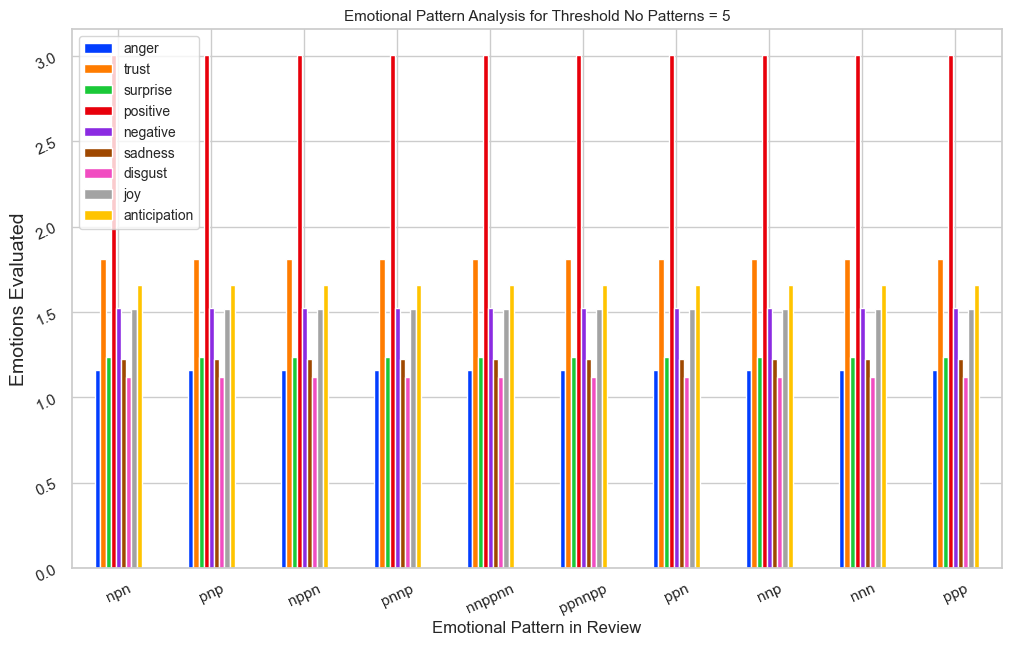

In [4211]:
ax =df.plot(x= "Emopattern", y=["anger",	"trust","surprise",	"positive",	"negative",	"sadness",	"disgust",	"joy",	"anticipation"], kind="bar",figsize=(12,7))
ax.legend(["anger",	"trust","surprise",	"positive",	"negative",	"sadness",	"disgust",	"joy",	"anticipation"],loc = 'upper left', fontsize=10)
ax.set_xlabel('Emotional Pattern in Review')  # Change label and font size
ax.set_ylabel('Emotions Evaluated', fontsize=14)  # Change label and font size
#y_ticks = [(i*.05) for i in range(0,20)]
#ax.set_yticks(y_ticks)
ax.yaxis.grid(True)
# Increase font size of tick labels
ax.tick_params(rotation = 25,axis='both', labelsize=11)
plt.grid(True)

plt.title('Emotional Pattern Analysis for Threshold No Patterns = '+str(threshold_no_pats), fontsize=11)

Text(0.5, 1.0, 'Emotional Pattern Analysis for Threshold No Patterns = 5')

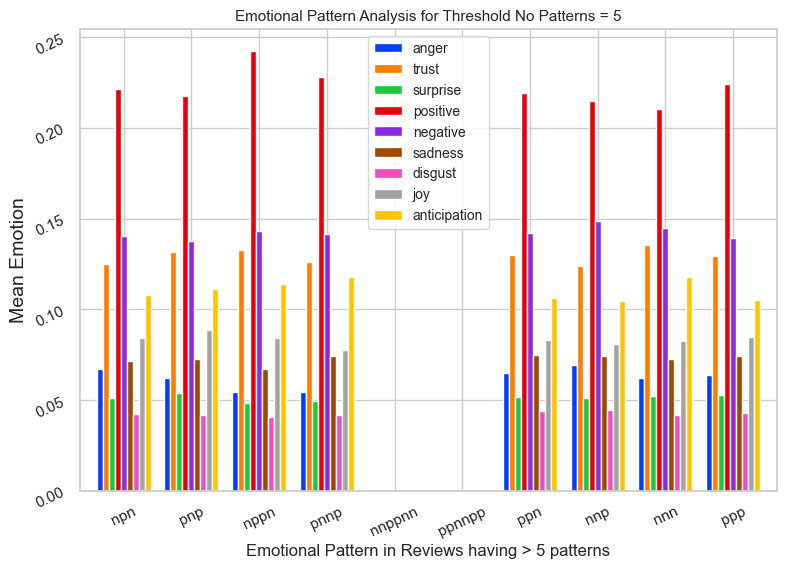

In [4226]:
sns.color_palette('deep')
ax =df7.plot(x= "Emopattern", y=["anger",	"trust","surprise",	"positive",	"negative",	"sadness",	"disgust",	"joy",	"anticipation"], kind="bar",width = .8, figsize=(9,6))
ax.legend(["anger",	"trust","surprise",	"positive",	"negative",	"sadness",	"disgust",	"joy",	"anticipation"],loc = 'upper center', fontsize=10)
ax.set_xlabel('Emotional Pattern in Reviews having > 5 patterns')  # Change label and font size
ax.set_ylabel('Mean Emotion', fontsize=14)  # Change label and font size
#y_ticks = [(i*.05) for i in range(0,10)]
#ax.set_yticks(y_ticks)
ax.yaxis.grid(True)
# Increase font size of tick labels
ax.tick_params(rotation = 25,axis='both', labelsize=11)
plt.grid(True)

plt.title('Emotional Pattern Analysis for Threshold No Patterns = '+str(threshold_no_pats), fontsize=11)

In [2310]:
type(data_amazon_nrc[data_amazon_nrc['ppp']>=1][emo_list].mean())

pandas.core.series.Series

In [2311]:
data_amazon_nrc.sort_values(by = ['pnp','anger'],ascending=False).to_csv('pnp_anger.csv')

In [2312]:
data_amazon_nrc.sort_values(by = ['npn','anger'],ascending=False).to_csv('npn_anger.csv')

In [2313]:
data_amazon_nrc.sort_values(by = ['pnp','surprise'],ascending=[False,True]).to_csv('pnp_surprise_lowest.csv')

In [2314]:
data_amazon_nrc.sort_values(by = ['pnpn','anger'],ascending=False).to_csv('pnpn_anger.csv')

In [2315]:
data_amazon_nrc.to_csv('data_amazon_nrc.csv')

In [2089]:
len(df)

10

In [2090]:
df['Mean_Emotion_Score'] = df[emo_list].mean(axis=1)

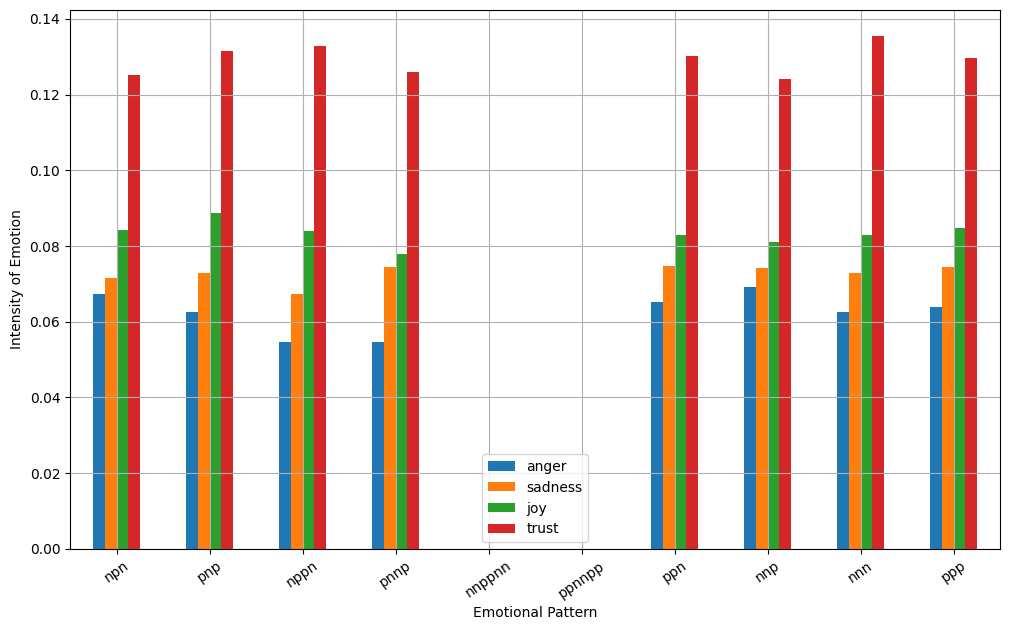

In [2091]:
ax =df.plot(x= "Emopattern", y=["anger","sadness","joy","trust"], kind="bar",figsize=(12,7))

plt.xticks(rotation=35)
plt.grid(True)
plt.xlabel('Emotional Pattern')
plt.ylabel('Intensity of Emotion')
plt.show()

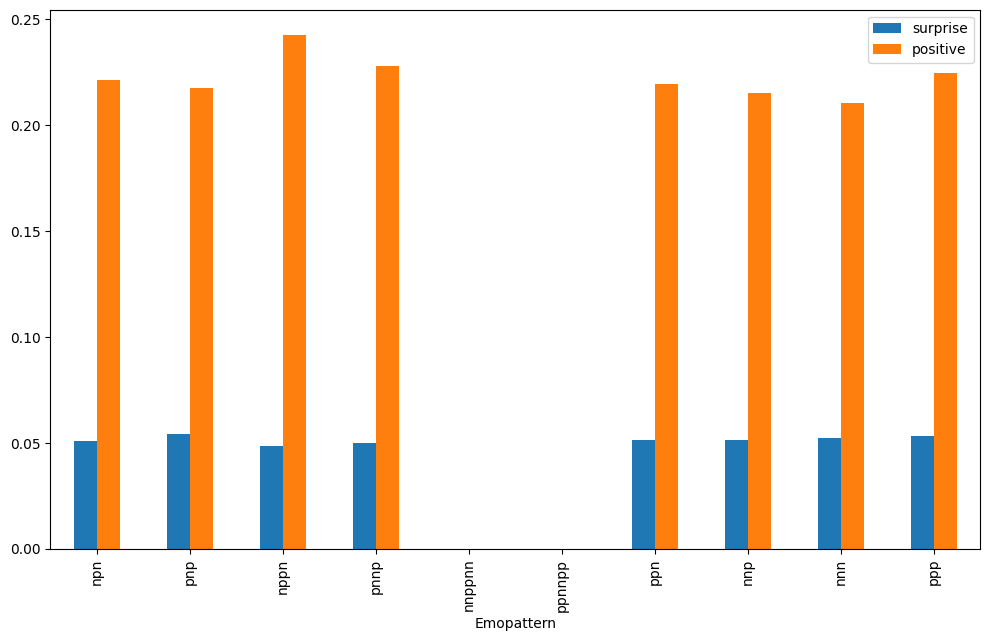

In [2092]:
ax =df.plot(x= "Emopattern", y=["surprise","positive"], kind="bar",figsize=(12,7))

In [2378]:
data_amazon_nrc[emo_list].corr()

anger     trust  surprise  positive  negative   sadness  \
anger         1.000000 -0.221815 -0.085816 -0.329229  0.363784  0.311937   
trust        -0.221815  1.000000 -0.055563  0.009530 -0.272660 -0.257627   
surprise     -0.085816 -0.055563  1.000000 -0.125014 -0.194393 -0.119690   
positive     -0.329229  0.009530 -0.125014  1.000000 -0.404198 -0.318421   
negative      0.363784 -0.272660 -0.194393 -0.404198  1.000000  0.409109   
sadness       0.311937 -0.257627 -0.119690 -0.318421  0.409109  1.000000   
disgust       0.445483 -0.213522 -0.082474 -0.286394  0.288947  0.382189   
joy          -0.257320  0.026739  0.222298  0.126434 -0.361338 -0.250694   
anticipation -0.199574 -0.132326  0.052729 -0.214384 -0.107786 -0.211820   

               disgust       joy  anticipation  
anger         0.445483 -0.257320     -0.199574  
trust        -0.213522  0.026739     -0.132326  
surprise     -0.082474  0.222298      0.052729  
positive     -0.286394  0.126434     -0.214384  
negative      0.288947 -0.361338     -0.107786  
sadness       0.382189 -0.250694     -0.211820  
disgust       1.000000 -0.227372     -0.178208  
joy          -0.227372  1.000000     -0.014109  
anticipation -0.178208 -0.014109      1.000000

In [2379]:
df

Emopattern     anger     trust  surprise  positive  negative   sadness  \
0        npn  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0        pnp  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0       nppn  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0       pnnp  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0     nnppnn  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0     ppnnpp  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0        ppn  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0        nnp  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0        nnn  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   
0        ppp  1.158824  1.809535   1.23835  3.006341  1.525301  1.225284   

    disgust       joy  anticipation  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107  
0  1.121311  1.518798      1.657107

In [2095]:
emo_list_patt = pattern_list+emo_list

In [2096]:
emo_list_patt

['npn',
 'pnp',
 'nppn',
 'pnnp',
 'nnppnn',
 'ppnnpp',
 'ppn',
 'nnp',
 'nnn',
 'ppp',
 'anger',
 'trust',
 'surprise',
 'positive',
 'negative',
 'sadness',
 'disgust',
 'joy',
 'anticipation']

In [2345]:
corr_data = data_amazon_nrc[emo_list_patt].corr()


In [2346]:
corr_data

npn       pnp      nppn      pnnp    nnppnn    ppnnpp  \
npn           1.000000  0.669033  0.441619  0.575712  0.228057  0.203393   
pnp           0.669033  1.000000  0.597651  0.434955  0.170382  0.264860   
nppn          0.441619  0.597651  1.000000  0.510538  0.508960  0.421238   
pnnp          0.575712  0.434955  0.510538  1.000000  0.402211  0.607371   
nnppnn        0.228057  0.170382  0.508960  0.402211  1.000000  0.359830   
ppnnpp        0.203393  0.264860  0.421238  0.607371  0.359830  1.000000   
ppn           0.512673  0.757931  0.746416  0.600400  0.372949  0.533457   
nnp           0.706174  0.471557  0.553699  0.804807  0.473980  0.478160   
nnn           0.515148  0.311334  0.368632  0.287585  0.353086  0.182400   
ppp           0.353902  0.551173  0.284302  0.423210  0.155433  0.423602   
anger         0.165306  0.149369  0.123035  0.137335  0.070780  0.077581   
trust        -0.045974 -0.046403 -0.036781 -0.038006 -0.016224 -0.018905   
surprise      0.006952  0.012555 -0.000036 -0.002614 -0.008023 -0.003168   
positive     -0.074592 -0.074757 -0.066557 -0.067190 -0.039237 -0.040908   
negative      0.102849  0.091504  0.074458  0.087526  0.047221  0.049837   
sadness       0.100246  0.098278  0.080377  0.094851  0.052805  0.057978   
disgust       0.109443  0.104924  0.076867  0.097242  0.048271  0.062609   
joy          -0.051193 -0.040370 -0.043586 -0.048554 -0.037751 -0.030857   
anticipation -0.059779 -0.043200 -0.033637 -0.049902 -0.027821 -0.034726   

                   ppn       nnp       nnn       ppp     anger     trust  \
npn           0.512673  0.706174  0.515148  0.353902  0.165306 -0.045974   
pnp           0.757931  0.471557  0.311334  0.551173  0.149369 -0.046403   
nppn          0.746416  0.553699  0.368632  0.284302  0.123035 -0.036781   
pnnp          0.600400  0.804807  0.287585  0.423210  0.137335 -0.038006   
nnppnn        0.372949  0.473980  0.353086  0.155433  0.070780 -0.016224   
ppnnpp        0.533457  0.478160  0.182400  0.423602  0.077581 -0.018905   
ppn           1.000000  0.629236  0.419163  0.673402  0.159545 -0.051741   
nnp           0.629236  1.000000  0.664101  0.451520  0.169118 -0.044943   
nnn           0.419163  0.664101  1.000000  0.288870  0.141367 -0.033279   
ppp           0.673402  0.451520  0.288870  1.000000  0.123363 -0.039095   
anger         0.159545  0.169118  0.141367  0.123363  1.000000 -0.221815   
trust        -0.051741 -0.044943 -0.033279 -0.039095 -0.221815  1.000000   
surprise      0.007896 -0.001169  0.003729  0.017724 -0.085816 -0.055563   
positive     -0.082618 -0.077872 -0.051062 -0.079625 -0.329229  0.009530   
negative      0.097839  0.106952  0.078626  0.081250  0.363784 -0.272660   
sadness       0.111644  0.108747  0.083344  0.086938  0.311937 -0.257627   
disgust       0.112629  0.113165  0.083983  0.091270  0.445483 -0.213522   
joy          -0.050780 -0.064118 -0.047737 -0.025489 -0.257320  0.026739   
anticipation -0.047639 -0.060379 -0.055281 -0.031590 -0.199574 -0.132326   

              surprise  positive  negative   sadness   disgust       joy  \
npn           0.006952 -0.074592  0.102849  0.100246  0.109443 -0.051193   
pnp           0.012555 -0.074757  0.091504  0.098278  0.104924 -0.040370   
nppn         -0.000036 -0.066557  0.074458  0.080377  0.076867 -0.043586   
pnnp         -0.002614 -0.067190  0.087526  0.094851  0.097242 -0.048554   
nnppnn       -0.008023 -0.039237  0.047221  0.052805  0.048271 -0.037751   
ppnnpp       -0.003168 -0.040908  0.049837  0.057978  0.062609 -0.030857   
ppn           0.007896 -0.082618  0.097839  0.111644  0.112629 -0.050780   
nnp          -0.001169 -0.077872  0.106952  0.108747  0.113165 -0.064118   
nnn           0.003729 -0.051062  0.078626  0.083344  0.083983 -0.047737   
ppp           0.017724 -0.079625  0.081250  0.086938  0.091270 -0.025489   
anger        -0.085816 -0.329229  0.363784  0.311937  0.445483 -0.257320   
trust        -0.055563  0.009530 -0.272660 -0.257627 -0.213522  0

In [2347]:
corr_data_cleaned = corr_data.dropna(how = 'all')

In [2348]:
corr_data_cleaned1 = corr_data_cleaned.dropna(axis=1)

In [2351]:
corr_data_cleaned1

npn       pnp      nppn      pnnp    nnppnn    ppnnpp  \
npn           1.000000  0.669033  0.441619  0.575712  0.228057  0.203393   
pnp           0.669033  1.000000  0.597651  0.434955  0.170382  0.264860   
nppn          0.441619  0.597651  1.000000  0.510538  0.508960  0.421238   
pnnp          0.575712  0.434955  0.510538  1.000000  0.402211  0.607371   
nnppnn        0.228057  0.170382  0.508960  0.402211  1.000000  0.359830   
ppnnpp        0.203393  0.264860  0.421238  0.607371  0.359830  1.000000   
ppn           0.512673  0.757931  0.746416  0.600400  0.372949  0.533457   
nnp           0.706174  0.471557  0.553699  0.804807  0.473980  0.478160   
nnn           0.515148  0.311334  0.368632  0.287585  0.353086  0.182400   
ppp           0.353902  0.551173  0.284302  0.423210  0.155433  0.423602   
anger         0.165306  0.149369  0.123035  0.137335  0.070780  0.077581   
trust        -0.045974 -0.046403 -0.036781 -0.038006 -0.016224 -0.018905   
surprise      0.006952  0.012555 -0.000036 -0.002614 -0.008023 -0.003168   
positive     -0.074592 -0.074757 -0.066557 -0.067190 -0.039237 -0.040908   
negative      0.102849  0.091504  0.074458  0.087526  0.047221  0.049837   
sadness       0.100246  0.098278  0.080377  0.094851  0.052805  0.057978   
disgust       0.109443  0.104924  0.076867  0.097242  0.048271  0.062609   
joy          -0.051193 -0.040370 -0.043586 -0.048554 -0.037751 -0.030857   
anticipation -0.059779 -0.043200 -0.033637 -0.049902 -0.027821 -0.034726   

                   ppn       nnp       nnn       ppp     anger     trust  \
npn           0.512673  0.706174  0.515148  0.353902  0.165306 -0.045974   
pnp           0.757931  0.471557  0.311334  0.551173  0.149369 -0.046403   
nppn          0.746416  0.553699  0.368632  0.284302  0.123035 -0.036781   
pnnp          0.600400  0.804807  0.287585  0.423210  0.137335 -0.038006   
nnppnn        0.372949  0.473980  0.353086  0.155433  0.070780 -0.016224   
ppnnpp        0.533457  0.478160  0.182400  0.423602  0.077581 -0.018905   
ppn           1.000000  0.629236  0.419163  0.673402  0.159545 -0.051741   
nnp           0.629236  1.000000  0.664101  0.451520  0.169118 -0.044943   
nnn           0.419163  0.664101  1.000000  0.288870  0.141367 -0.033279   
ppp           0.673402  0.451520  0.288870  1.000000  0.123363 -0.039095   
anger         0.159545  0.169118  0.141367  0.123363  1.000000 -0.221815   
trust        -0.051741 -0.044943 -0.033279 -0.039095 -0.221815  1.000000   
surprise      0.007896 -0.001169  0.003729  0.017724 -0.085816 -0.055563   
positive     -0.082618 -0.077872 -0.051062 -0.079625 -0.329229  0.009530   
negative      0.097839  0.106952  0.078626  0.081250  0.363784 -0.272660   
sadness       0.111644  0.108747  0.083344  0.086938  0.311937 -0.257627   
disgust       0.112629  0.113165  0.083983  0.091270  0.445483 -0.213522   
joy          -0.050780 -0.064118 -0.047737 -0.025489 -0.257320  0.026739   
anticipation -0.047639 -0.060379 -0.055281 -0.031590 -0.199574 -0.132326   

              surprise  positive  negative   sadness   disgust       joy  \
npn           0.006952 -0.074592  0.102849  0.100246  0.109443 -0.051193   
pnp           0.012555 -0.074757  0.091504  0.098278  0.104924 -0.040370   
nppn         -0.000036 -0.066557  0.074458  0.080377  0.076867 -0.043586   
pnnp         -0.002614 -0.067190  0.087526  0.094851  0.097242 -0.048554   
nnppnn       -0.008023 -0.039237  0.047221  0.052805  0.048271 -0.037751   
ppnnpp       -0.003168 -0.040908  0.049837  0.057978  0.062609 -0.030857   
ppn           0.007896 -0.082618  0.097839  0.111644  0.112629 -0.050780   
nnp          -0.001169 -0.077872  0.106952  0.108747  0.113165 -0.064118   
nnn           0.003729 -0.051062  0.078626  0.083344  0.083983 -0.047737   
ppp           0.017724 -0.079625  0.081250  0.086938  0.091270 -0.025489   
anger        -0.085816 -0.329229  0.363784  0.311937  0.445483 -0.257320   
trust        -0.055563  0.009530 -0.272660 -0.257627 -0.213522  0

In [2352]:
import seaborn as sns

<Axes: >

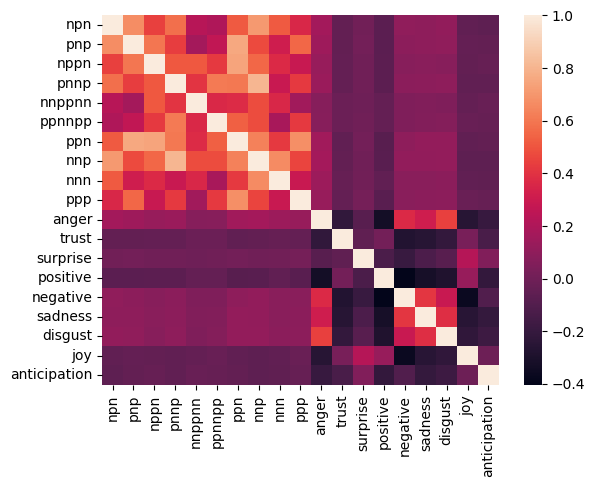

In [2353]:
sns.heatmap(corr_data_cleaned1)

In [2354]:
for i in range(len(corr_data_cleaned1)):
    corr_data_cleaned1.iloc[i,i]=0


In [2355]:
len(corr_data_cleaned1)

19

In [2356]:
corr_data_cleaned1

npn       pnp      nppn      pnnp    nnppnn    ppnnpp  \
npn           0.000000  0.669033  0.441619  0.575712  0.228057  0.203393   
pnp           0.669033  0.000000  0.597651  0.434955  0.170382  0.264860   
nppn          0.441619  0.597651  0.000000  0.510538  0.508960  0.421238   
pnnp          0.575712  0.434955  0.510538  0.000000  0.402211  0.607371   
nnppnn        0.228057  0.170382  0.508960  0.402211  0.000000  0.359830   
ppnnpp        0.203393  0.264860  0.421238  0.607371  0.359830  0.000000   
ppn           0.512673  0.757931  0.746416  0.600400  0.372949  0.533457   
nnp           0.706174  0.471557  0.553699  0.804807  0.473980  0.478160   
nnn           0.515148  0.311334  0.368632  0.287585  0.353086  0.182400   
ppp           0.353902  0.551173  0.284302  0.423210  0.155433  0.423602   
anger         0.165306  0.149369  0.123035  0.137335  0.070780  0.077581   
trust        -0.045974 -0.046403 -0.036781 -0.038006 -0.016224 -0.018905   
surprise      0.006952  0.012555 -0.000036 -0.002614 -0.008023 -0.003168   
positive     -0.074592 -0.074757 -0.066557 -0.067190 -0.039237 -0.040908   
negative      0.102849  0.091504  0.074458  0.087526  0.047221  0.049837   
sadness       0.100246  0.098278  0.080377  0.094851  0.052805  0.057978   
disgust       0.109443  0.104924  0.076867  0.097242  0.048271  0.062609   
joy          -0.051193 -0.040370 -0.043586 -0.048554 -0.037751 -0.030857   
anticipation -0.059779 -0.043200 -0.033637 -0.049902 -0.027821 -0.034726   

                   ppn       nnp       nnn       ppp     anger     trust  \
npn           0.512673  0.706174  0.515148  0.353902  0.165306 -0.045974   
pnp           0.757931  0.471557  0.311334  0.551173  0.149369 -0.046403   
nppn          0.746416  0.553699  0.368632  0.284302  0.123035 -0.036781   
pnnp          0.600400  0.804807  0.287585  0.423210  0.137335 -0.038006   
nnppnn        0.372949  0.473980  0.353086  0.155433  0.070780 -0.016224   
ppnnpp        0.533457  0.478160  0.182400  0.423602  0.077581 -0.018905   
ppn           0.000000  0.629236  0.419163  0.673402  0.159545 -0.051741   
nnp           0.629236  0.000000  0.664101  0.451520  0.169118 -0.044943   
nnn           0.419163  0.664101  0.000000  0.288870  0.141367 -0.033279   
ppp           0.673402  0.451520  0.288870  0.000000  0.123363 -0.039095   
anger         0.159545  0.169118  0.141367  0.123363  0.000000 -0.221815   
trust        -0.051741 -0.044943 -0.033279 -0.039095 -0.221815  0.000000   
surprise      0.007896 -0.001169  0.003729  0.017724 -0.085816 -0.055563   
positive     -0.082618 -0.077872 -0.051062 -0.079625 -0.329229  0.009530   
negative      0.097839  0.106952  0.078626  0.081250  0.363784 -0.272660   
sadness       0.111644  0.108747  0.083344  0.086938  0.311937 -0.257627   
disgust       0.112629  0.113165  0.083983  0.091270  0.445483 -0.213522   
joy          -0.050780 -0.064118 -0.047737 -0.025489 -0.257320  0.026739   
anticipation -0.047639 -0.060379 -0.055281 -0.031590 -0.199574 -0.132326   

              surprise  positive  negative   sadness   disgust       joy  \
npn           0.006952 -0.074592  0.102849  0.100246  0.109443 -0.051193   
pnp           0.012555 -0.074757  0.091504  0.098278  0.104924 -0.040370   
nppn         -0.000036 -0.066557  0.074458  0.080377  0.076867 -0.043586   
pnnp         -0.002614 -0.067190  0.087526  0.094851  0.097242 -0.048554   
nnppnn       -0.008023 -0.039237  0.047221  0.052805  0.048271 -0.037751   
ppnnpp       -0.003168 -0.040908  0.049837  0.057978  0.062609 -0.030857   
ppn           0.007896 -0.082618  0.097839  0.111644  0.112629 -0.050780   
nnp          -0.001169 -0.077872  0.106952  0.108747  0.113165 -0.064118   
nnn           0.003729 -0.051062  0.078626  0.083344  0.083983 -0.047737   
ppp           0.017724 -0.079625  0.081250  0.086938  0.091270 -0.025489   
anger        -0.085816 -0.329229  0.363784  0.311937  0.445483 -0.257320   
trust        -0.055563  0.009530 -0.272660 -0.257627 -0.213522  0

<Axes: >

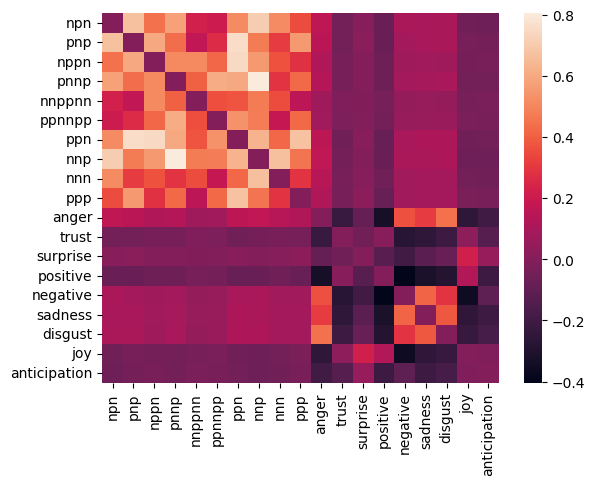

In [2357]:
sns.heatmap(corr_data_cleaned1)

In [2358]:
# Get the number of rows and columns (assuming it's a square matrix)
n = corr_data_cleaned1.shape[0]

# Calculate the index to split the rows and columns
split_index = n // 2

# Create a new DataFrame containing the upper-left quarter
new_df = corr_data_cleaned1.iloc[:split_index, split_index+1:]

new_df

anger     trust  surprise  positive  negative   sadness   disgust  \
npn     0.165306 -0.045974  0.006952 -0.074592  0.102849  0.100246  0.109443   
pnp     0.149369 -0.046403  0.012555 -0.074757  0.091504  0.098278  0.104924   
nppn    0.123035 -0.036781 -0.000036 -0.066557  0.074458  0.080377  0.076867   
pnnp    0.137335 -0.038006 -0.002614 -0.067190  0.087526  0.094851  0.097242   
nnppnn  0.070780 -0.016224 -0.008023 -0.039237  0.047221  0.052805  0.048271   
ppnnpp  0.077581 -0.018905 -0.003168 -0.040908  0.049837  0.057978  0.062609   
ppn     0.159545 -0.051741  0.007896 -0.082618  0.097839  0.111644  0.112629   
nnp     0.169118 -0.044943 -0.001169 -0.077872  0.106952  0.108747  0.113165   
nnn     0.141367 -0.033279  0.003729 -0.051062  0.078626  0.083344  0.083983   

             joy  anticipation  
npn    -0.051193     -0.059779  
pnp    -0.040370     -0.043200  
nppn   -0.043586     -0.033637  
pnnp   -0.048554     -0.049902  
nnppnn -0.037751     -0.027821  
ppnnpp -0.030857     -0.034726  
ppn    -0.050780     -0.047639  
nnp    -0.064118     -0.060379  
nnn    -0.047737     -0.055281

In [2359]:
n //2

9

## Assessment -  we realise Surprise is minimum for Deep Patterns

<Axes: >

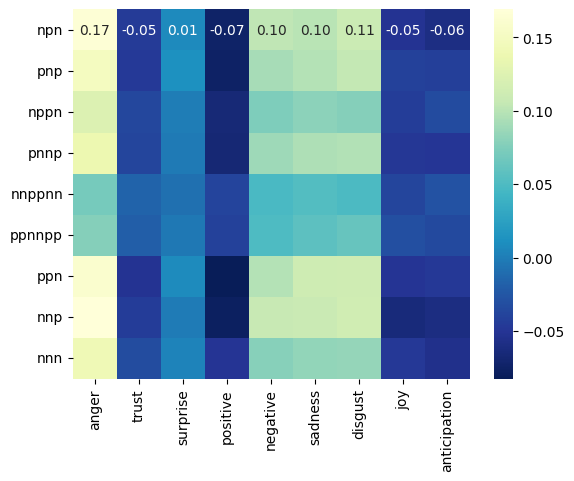

In [2360]:
sns.heatmap(new_df,cmap="YlGnBu_r", annot=True, fmt=".2f", cbar=True)

### From above we realise that Positive and Surprise emotions are most negatively correlated with Deep Emo Patterns

Therefore we look form high frequency of Deep Emo Patterns with low surprise scores

# BERT Embedding 

## Code for embedding BERT Basic 1x768

In [1939]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [1940]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)




In [1941]:
# BERT embedding with CLS Token 1x768
def get_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    zz = last_hidden_states[0,0,:] # uses the CLS Token for Embedding
    zz = zz.reshape((1,768))
    return zz

In [1942]:
# BERT embedding with mean across the sentence 1x768
def get_sentence_embedding_mean(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    zz = torch.mean(last_hidden_states,dim=1) # uses the CLS Token for Embedding
    zz = zz.reshape((1,768))
    #zx= zz.detach().numpy()
    return zz

In [1943]:
# BERT embedding with 1x1536 two concataned embeddings BERT CLS and BERT Mean
def get_spl_sentence_embedding(txt):
    data1 = get_sentence_embedding(txt)
    data2 = get_sentence_embedding_mean(txt)
    data1 = data1.detach().numpy()
    data2 = data2.detach().numpy()
    data3 = np.append(data1,data2, axis=1)
    return data3

In [ ]:
#embedding1 = get_sentence_embedding(data_amazon_nrc['review'].iloc[0])
#docu_embed = embedding1.detach().numpy()
#for i in range(1,len(data_amazon_nrc)):
#    embedding1 = get_sentence_embedding(data_amazon_nrc['review'].iloc[i])
#    embed1 = embedding1.detach().numpy()
#    docu_embed = np.append(docu_embed,embed1,axis=0)

In [1958]:
#embedding1.tofile('embedding1')
#embedding1.shape


(1, 1536)

## Embedding CLS BERT + Mean Pooling BERT 1x1536 per review

In [ ]:
#embedding1 = get_spl_sentence_embedding (data_amazon_nrc['review'].iloc[0])
#docu_embed1 = embedding1
#for i in range(1,len(data_amazon_nrc)):
#    embedding1 = get_spl_sentence_embedding (data_amazon_nrc['review'].iloc[i])
#    #embed1 = embedding1.detach().numpy()
#    docu_embed1 = np.append(docu_embed1,embedding1,axis=0)

In [4179]:
#np.save('docu_embed1.npy',docu_embed1)


In [3913]:
docu_embed1 = np.load('docu_embed1.npy')

In [4178]:
docu_embed1.shape

(7000, 1536)

## Pattern List and Emotions including Feature Importance and Weights

In [3379]:
embed_list=[]
for patt in pattern_:
    for  i in range (pattern_list_weight[patt]):
        embed_list.append(patt+str(i))
embed_list_series = pd.Series(index=embed_list)

In [4280]:
data_amazon_json_df_pat_nrc.loc[xxrel]['helpfulness']

1      -1
4       1
14      1
15      1
17      1
       ..
6984    1
6989    1
6992    1
6993    1
6999    1
Name: helpfulness, Length: 4675, dtype: int64

In [4458]:
## Here we use Feature Importance using Random Forest Regressor to fing the most important emotional patterns which contribute to helpfulness. 
# This will be used as the weight for feature replication for concatanating BERT embedding.

len_pat = 700
pat_wt_embd = {}
pat_wt_df = {}
pat_wt_single = {}

from sklearn.ensemble import RandomForestRegressor

X = data_amazon_json_df_pat_nrc.loc[xxrel][pattern_list]
y = data_amazon_json_df_pat_nrc.loc[xxrel]['helpfulness']

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Train the model
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

# Sort the features by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Print feature importance scores
print("Feature Importance Scores:")
k=1
for i in sorted_indices:
    print(f"{pattern_list[i]} {k}: {round(feature_importances[i],3), round(feature_importances[i]*len_pat,0)}")
    pat_wt_embd.update([(pattern_list[i] , round(feature_importances[i]*len_pat,0))])
    pat_wt_df.update([(pattern_list[i] ,[round(feature_importances[i],3), round(feature_importances[i]*len_pat,0)])])
    pat_wt_single.update([(pattern_list[i] , round(feature_importances[i],3))])
    k = k+1

Feature Importance Scores:
ppn 1: (0.158, 111.0)
ppp 2: (0.152, 106.0)
pnp 3: (0.15, 105.0)
nnp 4: (0.147, 103.0)
npn 5: (0.117, 82.0)
nnn 6: (0.104, 73.0)
pnnp 7: (0.072, 51.0)
nppn 8: (0.063, 44.0)
ppnnpp 9: (0.021, 15.0)
nnppnn 10: (0.016, 11.0)


In [4461]:
sum(pat_wt_embd.values())

700.0

In [4462]:
pat_wt_embd['ppnnpp']=14

In [4463]:
pat_wt_df['ppnnpp'][1]=14

In [4464]:
pat_wt_df = pd.DataFrame(pat_wt_df)

In [4465]:
pat_wt_df.T

0      1
ppn     0.158  111.0
ppp     0.152  106.0
pnp     0.150  105.0
nnp     0.147  103.0
npn     0.117   82.0
nnn     0.104   73.0
pnnp    0.072   51.0
nppn    0.063   44.0
ppnnpp  0.021   14.0
nnppnn  0.016   11.0

In [4472]:
## Here we use Feature Importance using Random Forest Regressor to fing the most important emotional patterns which contribute to helpfulness. 
# This will be used as the weight for feature replication for concatanating BERT embedding.
len_emo = 500
emo_wt_embd = {}
emo_wt_single = {}
emo_wt_df ={}

from sklearn.ensemble import RandomForestRegressor

X = data_amazon.loc[xxrel][emo_list]
y = data_amazon.loc[xxrel]['helpfulness']

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Train the model
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

# Sort the features by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Print feature importance scores
print("Feature Importance Scores:")
k=1
for i in sorted_indices:
    print(f"{emo_list[i]} {k}: {round(feature_importances[i],3), round(feature_importances[i]*len_emo,0)}")
    emo_wt_embd.update([(emo_list[i] , round(feature_importances[i]*len_emo,0))])
    emo_wt_df.update([(emo_list[i] , [round(feature_importances[i],3),round(feature_importances[i]*len_emo,0)])])
    emo_wt_single.update([(emo_list[i] , round(feature_importances[i],3))])
    k = k+1
    

Feature Importance Scores:
positive 1: (0.168, 84.0)
trust 2: (0.141, 71.0)
anticipation 3: (0.125, 63.0)
negative 4: (0.121, 60.0)
joy 5: (0.119, 60.0)
sadness 6: (0.094, 47.0)
surprise 7: (0.09, 45.0)
anger 8: (0.072, 36.0)
disgust 9: (0.069, 35.0)


In [4480]:
emo_wt_df['anger'][1]=35
emo_wt_df['disgust'][1]=34

In [4481]:
emo_wt_df = pd.DataFrame(emo_wt_df)

In [4482]:
emo_wt_df.T

0     1
positive      0.168  84.0
trust         0.141  71.0
anticipation  0.125  63.0
negative      0.121  60.0
joy           0.119  60.0
sadness       0.094  47.0
surprise      0.090  45.0
anger         0.072  35.0
disgust       0.069  34.0

In [4474]:
## Here we use Feature Importance using Random Forest Regressor to fing the most important emotional patterns which contribute to helpfulness. 
# This will be used as the weight for feature replication for concatanating BERT embedding.
len_emo = 700 # we change this for different experiments
emo_wt_embd = {}
emo_wt_single = {}

from sklearn.ensemble import RandomForestRegressor

X = data_amazon.loc[bal_indices][emo_list]
y = data_amazon.loc[bal_indices]['helpfulness']

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Train the model
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

# Sort the features by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Print feature importance scores
print("Feature Importance Scores:")
k=1
for i in sorted_indices:
    print(f"{emo_list[i]} {k}: {round(feature_importances[i],3), round(feature_importances[i]*len_emo,0)}")
    emo_wt_embd.update([(emo_list[i] , round(feature_importances[i]*len_emo,0))])
    emo_wt_single.update([(emo_list[i] , round(feature_importances[i],3))])
    k = k+1
    

Feature Importance Scores:
positive 1: (0.145, 102.0)
trust 2: (0.134, 94.0)
anticipation 3: (0.129, 91.0)
joy 4: (0.124, 87.0)
negative 5: (0.123, 86.0)
surprise 6: (0.104, 73.0)
sadness 7: (0.089, 62.0)
anger 8: (0.08, 56.0)
disgust 9: (0.072, 50.0)


In [4475]:
sum(emo_wt_embd.values())

701.0

In [ ]:
round(feature_importances[i],3)

In [3625]:
emo_wt_single

{'positive': 1,
 'trust': 1,
 'anticipation': 1,
 'negative': 1,
 'joy': 1,
 'surprise': 1,
 'sadness': 1,
 'anger': 1,
 'disgust': 1}

In [3623]:
pat_wt_embd 
pat_wt_single # as per Feature Importance towards helpfulness

{'ppp': 1,
 'pnp': 1,
 'ppn': 1,
 'nnp': 1,
 'npn': 1,
 'nnn': 1,
 'pnnp': 1,
 'nppn': 1,
 'ppnnpp': 1,
 'nnppnn': 1}

In [4051]:
emo_wt_embd['anger']=53
emo_wt_embd['disgust']=51

In [4288]:
emo_wt_embd

{'positive': 118.0,
 'trust': 99.0,
 'anticipation': 88.0,
 'negative': 85.0,
 'joy': 84.0,
 'sadness': 66.0,
 'surprise': 63.0,
 'anger': 50.0,
 'disgust': 48.0}

In [3519]:
pat_wt_single.keys()

dict_keys(['ppp', 'pnp', 'ppn', 'nnp', 'npn', 'nnn', 'pnnp', 'nppn', 'ppnnpp', 'nnppnn'])

In [3642]:
def embed_pat_expand(input_series,weights):
    embed_list=[]
    for patt in weights:
        for  i in range (int(weights[patt])):
            embed_list.append(patt+str(i))
    embed_list_series = pd.Series(index=embed_list)
    for pati in weights:
        for i in range(int(weights[pati])):
            embed_list_series[pati+str(i)]=input_series[pati]
    return np.array(pd.Series(embed_list_series))

In [3643]:
def embed_pat_expand_single(input_series,weights):
    embed_list=[]
    embed_list_series = pd.Series(index=weights.keys())
    for pati in weights:
        embed_list_series[pati]=input_series[pati] * weights[pati]
    return np.array(pd.Series(embed_list_series))

In [3515]:
embedding_pat1 = embed_pat_expand(data_amazon[pattern_list].iloc[0],pat_wt_embd)
embedding_pat1.shape


(100,)

In [3516]:
embedding_pat_emo = embed_pat_expand(data_amazon[pattern_list].iloc[0],pat_wt_embd)
embedding_pat_emo.shape

(100,)

In [3536]:
embed_list_series

positive       NaN
trust          NaN
anticipation   NaN
negative       NaN
joy            NaN
surprise       NaN
sadness        NaN
anger          NaN
disgust        NaN
dtype: float64

In [3603]:
embedding_pat_single = embed_pat_expand_single(data_amazon[emo_list].iloc[0],emo_wt_single)
embedding_pat_single.shape

(9,)

In [3542]:
embedding_emo_single = embed_pat_expand_single(data_amazon[pattern_list].iloc[0],pat_wt_single)
embedding_emo_single.shape

(10,)

In [3512]:
embedding_pat1 = embedding_pat1.reshape(1,len_pat)
embedding_pat_emo = embedding_pat_emo.reshape(1,len_emo)

In [3483]:
data_amazon[emo_list]=data_amazon_nrc[emo_list]

In [3125]:
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()



In [3544]:
len_pat

100

## Embedding with Patterns and Emotions

In [4009]:
# BERT embedding with emotional pattern concatanated # for 500 dim
embedding_pat1 = embed_pat_expand(data_amazon_nrc[pattern_list].iloc[0],pat_wt_embd)
embedding_pat1 = embedding_pat1.reshape(1,len_pat)

docu_embed_pat1 = embedding_pat1
for i in range(1,len(data_amazon_nrc)):
    embedding_pat1 = embed_pat_expand(data_amazon_nrc[pattern_list].iloc[i],pat_wt_embd)
    embedding_pat1 = embedding_pat1.reshape(1,len_pat)
    docu_embed_pat1 = np.append(docu_embed_pat1,embedding_pat1,axis=0)
docu_embed_pat1 = scaler.fit_transform(docu_embed_pat1)



In [4063]:
embedding_emo1 = embed_pat_expand(data_amazon[emo_list].iloc[0],emo_wt_embd)
embedding_emo1 = embedding_emo1.reshape(1,len_emo)
embedding_emo1.shape

(1, 700)

In [4014]:
# NRC lex embedding with emotions  concatanated # for 500 dim
embedding_emo1 = embed_pat_expand(data_amazon[emo_list].iloc[0],emo_wt_embd)
embedding_emo1 = embedding_emo1.reshape(1,len_emo)
docu_embed_emo1 = embedding_emo1
for i in range(1,len(data_amazon_nrc)):
    embedding_emo1 = embed_pat_expand(data_amazon_nrc[emo_list].iloc[i],emo_wt_embd)
    embedding_emo1 = embedding_emo1.reshape(1,len_emo)
    docu_embed_emo1 = np.append(docu_embed_emo1,embedding_emo1,axis=0)
docu_embed_emo1 = scaler.fit_transform(docu_embed_emo1)

In [4069]:
# BERT embedding with emotional pattern concatanated # for 700 dim
embedding_pat1 = embed_pat_expand(data_amazon_nrc[pattern_list].iloc[0],pat_wt_embd)
embedding_pat1 = embedding_pat1.reshape(1,len_pat)

docu_embed_pat2 = embedding_pat1
for i in range(1,len(data_amazon_nrc)):
    embedding_pat1 = embed_pat_expand(data_amazon_nrc[pattern_list].iloc[i],pat_wt_embd)
    embedding_pat1 = embedding_pat1.reshape(1,len_pat)
    docu_embed_pat2 = np.append(docu_embed_pat2,embedding_pat1,axis=0)
docu_embed_pat2 = scaler.fit_transform(docu_embed_pat2)



In [4073]:
docu_embed_pat2.shape

(7000, 700)

In [4074]:
# NRC lex embedding with emotions  concatanated # for 700 dim
embedding_emo1 = embed_pat_expand(data_amazon[emo_list].iloc[0],emo_wt_embd)
embedding_emo1 = embedding_emo1.reshape(1,len_emo)
docu_embed_emo2 = embedding_emo1
for i in range(1,len(data_amazon_nrc)):
    embedding_emo1 = embed_pat_expand(data_amazon_nrc[emo_list].iloc[i],emo_wt_embd)
    embedding_emo1 = embedding_emo1.reshape(1,len_emo)
    docu_embed_emo2 = np.append(docu_embed_emo2,embedding_emo1,axis=0)
docu_embed_emo2 = scaler.fit_transform(docu_embed_emo2)

In [ ]:
embedding_bert_patt1 = np.append(docu_embed1,docu_embed_pat1,axis=1) # for 500 dim run only after generating bert pat 1
embedding_bert_patt2 = np.append(embedding_bert_patt1,docu_embed_emo1,axis=1) #this is 2536ep

In [4089]:
embedding_bert_patt3 = np.append(docu_embed1,docu_embed_pat2,axis=1) # for 700 dim , run only after generating docu embed pat2
embedding_bert_patt3 = np.append(embedding_bert_patt3,docu_embed_emo2,axis=1) #this is 2936ep

In [4016]:
embedding_emo_patt = np.append(docu_embed_emo1,docu_embed_pat1,axis=1)
embedding_emo_patt.shape

(7000, 1000)

In [3657]:
# BERT embedding with emotional pattern concatanated
embedding_pat1 = embed_pat_expand_single(data_amazon[pattern_list].iloc[0],pat_wt_single)
embedding_pat1 = embedding_pat.reshape(1,len(pat_wt_single))

docu_embed_pat1 = embedding_pat1
for i in range(1,len(data_amazon_nrc)):
    embedding_pat1 = embed_pat_expand_single(data_amazon[pattern_list].iloc[i],pat_wt_single)
    embedding_pat1 = embedding_pat1.reshape(1,len(pat_wt_single))
    docu_embed_pat1 = np.append(docu_embed_pat1,embedding_pat1,axis=0)
docu_embed_pat_single = scaler.fit_transform(docu_embed_pat1)

In [3613]:
embedding_pat1 = embed_pat_expand_single(data_amazon[emo_list].iloc[0],emo_wt_single)
x = embedding_pat1.reshape(1,len(emo_wt_single))

In [3658]:
# BERT embedding with emotional pattern concatanated
embedding_pat1 = embed_pat_expand_single(data_amazon[emo_list].iloc[0],emo_wt_single)
embedding_pat1 = embedding_pat1.reshape(1,len(emo_wt_single))

docu_embed_pat1 = embedding_pat1
for i in range(1,len(data_amazon)):
    embedding_pat1 = embed_pat_expand_single(data_amazon[emo_list].iloc[i],emo_wt_single)
    embedding_pat1 = embedding_pat1.reshape(1,len(emo_wt_single))
    docu_embed_pat1 = np.append(docu_embed_pat1,embedding_pat1,axis=0)
docu_embed_emo_single = scaler.fit_transform(docu_embed_pat1)

In [3659]:
docu_embed_emo_pat_single_single = np.append(docu_embed_emo_single,docu_embed_pat_single,axis=1)
docu_embed_emo_pat_single_single.shape

(7000, 19)

## Statistical Tests and Basic Data Visualisation

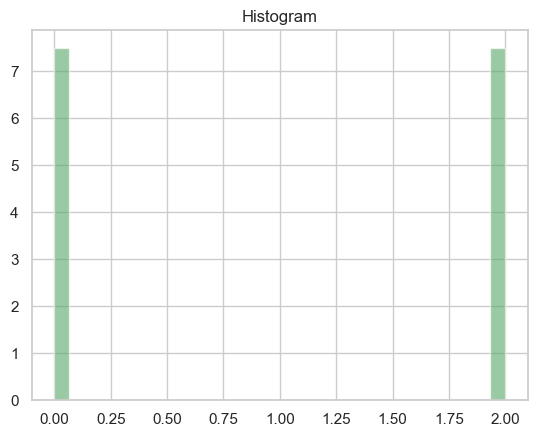


KeyboardInterrupt



In [4180]:
from scipy import stats
data =  docu_embed_pat1[:,7]

# Visualize the data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
plt.title('Histogram')
plt.show()

# Shapiro-Wilk Test
stat, p_value = stats.shapiro(data)
print(f'Shapiro-Wilk Test: Statistic={stat}, p-value={p_value}')

# Kolmogorov-Smirnov Test
stat, p_value = stats.kstest(data, 'norm')
print(f'Kolmogorov-Smirnov Test: Statistic={stat}, p-value={p_value}')

# Anderson-Darling Test
result = stats.anderson(data)
print(f'Anderson-Darling Test: Statistic={result.statistic}, Critical Values={result.critical_values}, Significance Level={result.significance_level}')


## Attempt using Linear Layer

In [ ]:
linear_layer_embed = nn.Linear(in_features=10, out_features=500,dtype = torch.float)
def embed_pat_expand_uselinearlayer (input_seriess):
    inp_tensor = torch.tensor(input_seriess)
    inp_tensor =inp_tensor.float()
    output_tensor = linear_layer_embed(inp_tensor)
    return output_tensor.detach().numpy()

embed_pat_expand_uselinearlayer([1,2,3,4,5,6,7,8,9,0])

In [2553]:
dict_sets = {}
for patt in pattern_list:
    dict_sets[patt]=[]
  
for patt in pattern_list:  
    for i in range(len(data_amazon_nrc)):
        if data_amazon_nrc[patt].iloc[i] >= 1:
            dict_sets[patt].append(i)

In [2561]:
dict_set_helpful = {}
for xxz in [1,0,-1]:
    dict_set_helpful[xxz]=[]
  
for xxz in [1,0,-1]:  
    for i in range(len(data_amazon)):
        if data_amazon['helpfulness'].iloc[i] == xxz:
            dict_set_helpful[xxz].append(i)

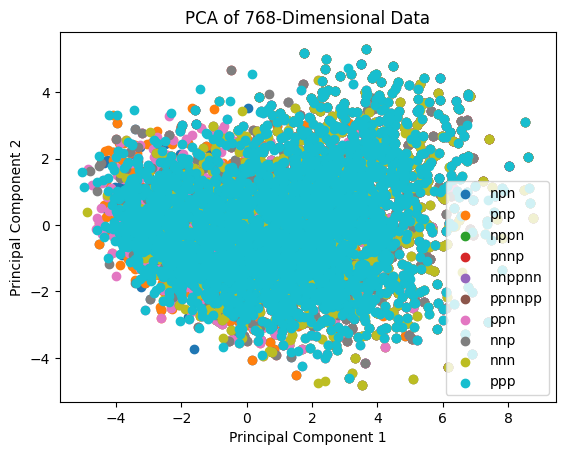

In [1969]:
data = docu_embed
# Perform PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)
pca_df = pd.DataFrame(data=data_2d, columns=['Dimension 1', 'Dimension 2'])
# Create a scatter plot of the reduced-dimensional data
for label in dict_sets:
    subset1 = pca_df.loc[dict_sets[label]]
    plt.scatter(subset1['Dimension 1'], subset1['Dimension 2'], label=label)
#plt.scatter(data_2d[:, 0], data_2d[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 768-Dimensional Data')
plt.legend()
plt.show()

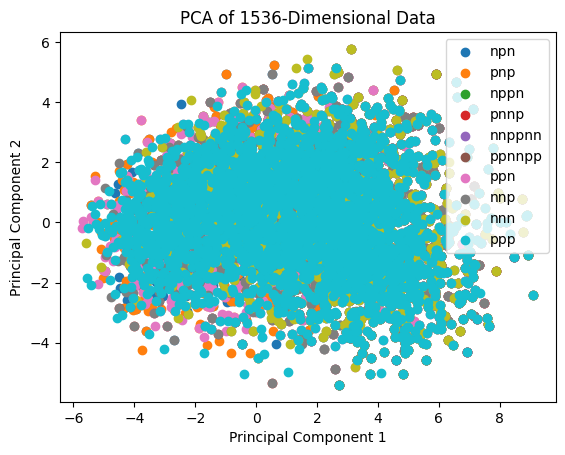

In [1972]:
data = docu_embed1
# Perform PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)
pca_df = pd.DataFrame(data=data_2d, columns=['Dimension 1', 'Dimension 2'])
# Create a scatter plot of the reduced-dimensional data
for label in dict_sets:
    subset1 = pca_df.loc[dict_sets[label]]
    plt.scatter(subset1['Dimension 1'], subset1['Dimension 2'], label=label)
#plt.scatter(data_2d[:, 0], data_2d[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 1536-Dimensional Data')
plt.legend()
plt.show()

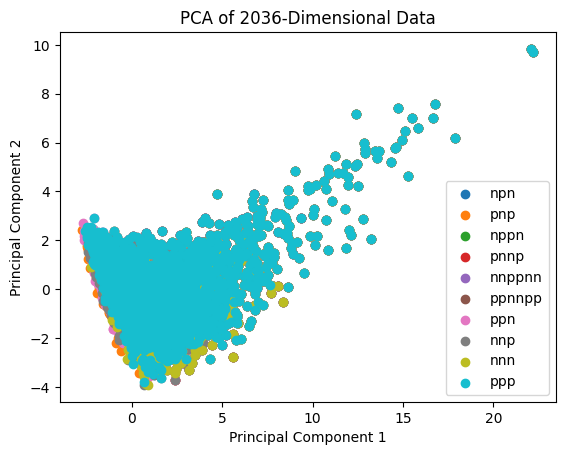

In [3388]:
data = embedding_bert_patt
data = scaler.fit_transform(data)
# Perform PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)
pca_df = pd.DataFrame(data=data_2d, columns=['Dimension 1', 'Dimension 2'])
# Create a scatter plot of the reduced-dimensional data
for label in dict_sets:
    subset1 = pca_df.loc[dict_sets[label]]
    plt.scatter(subset1['Dimension 1'], subset1['Dimension 2'], label=label)
#plt.scatter(data_2d[:, 0], data_2d[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 2036-Dimensional Data')
plt.legend()
plt.show()

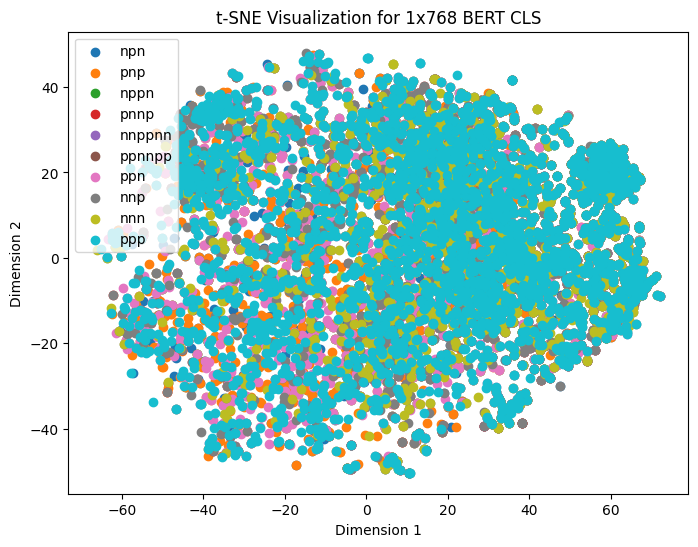

In [1975]:
from sklearn.manifold import TSNE


# Initialize t-SNE model
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
tsne_embeddings = tsne.fit_transform(docu_embed)

# Convert the result to a DataFrame for convenience
tsne_df = pd.DataFrame(data=tsne_embeddings, columns=['Dimension 1', 'Dimension 2'])


# Plot the result with legend
plt.figure(figsize=(8, 6))

# Iterate over unique labels
for label in dict_sets:
    subset = tsne_df.loc[dict_sets[label]]
    plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)

plt.title('t-SNE Visualization for 1x768 BERT CLS')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


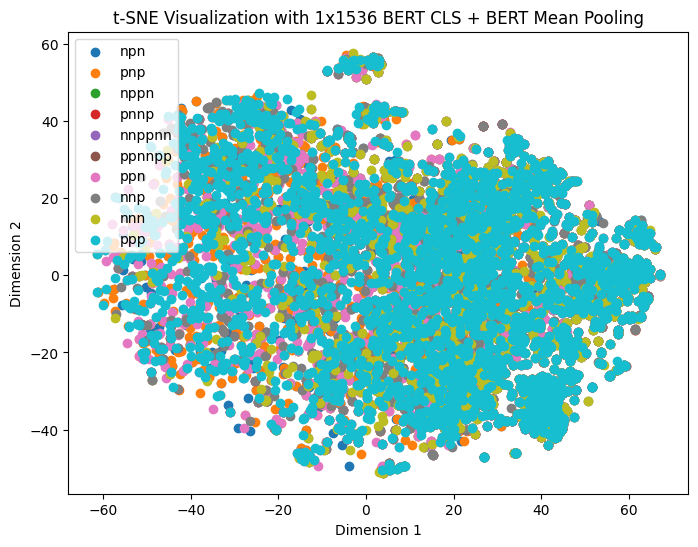

In [1976]:
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
tsne_embeddings1 = tsne.fit_transform(docu_embed1)

# Convert the result to a DataFrame for convenience
tsne_df1 = pd.DataFrame(data=tsne_embeddings1, columns=['Dimension 1', 'Dimension 2'])


# Plot the result with legend
plt.figure(figsize=(8, 6))

# Iterate over unique labels
for label in dict_sets:
    subset = tsne_df1.loc[dict_sets[label]]
    plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)

plt.title('t-SNE Visualization with 1x1536 BERT CLS + BERT Mean Pooling')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

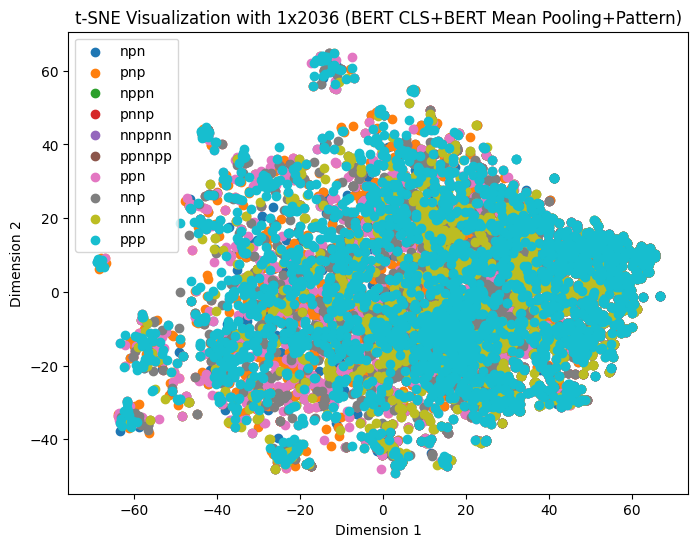

In [4031]:
tsne = TSNE(n_components=2, random_state=42)
tsnex = embedding_bert_patt2
tsnex = scaler.fit_transform(tsnex)
# Fit and transform the data
tsne_embeddings_pat = tsne.fit_transform(tsnex)

# Convert the result to a DataFrame for convenience
tsne_df_pat = pd.DataFrame(data=tsne_embeddings_pat, columns=['Dimension 1', 'Dimension 2'])


# Plot the result with legend
plt.figure(figsize=(8, 6))

# Iterate over unique labels
for label in dict_sets:
    subset = tsne_df_pat.loc[dict_sets[label]]
    plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)

plt.title('t-SNE Visualization with 1x2536 (BERT CLS+BERT Mean Pooling+Pattern+Emotion)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

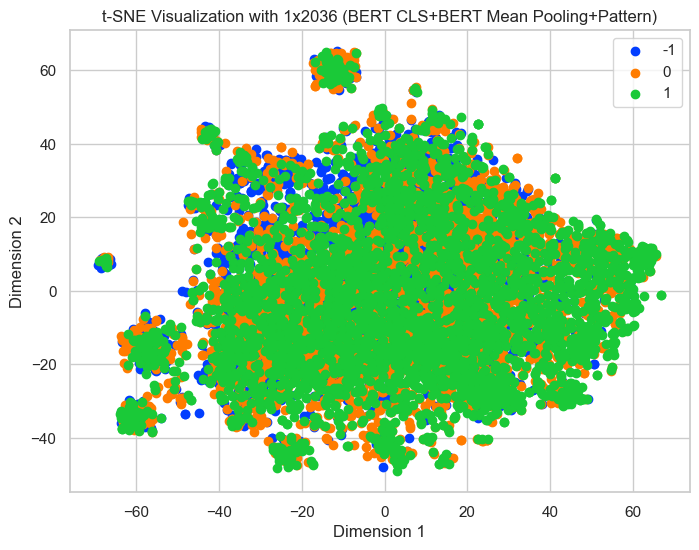

In [4435]:
# Plot the result with legend
plt.figure(figsize=(8, 6))

# Iterate over unique labels
for label in [-1,0,1]:
    subset = tsne_df_pat.loc[dict_set_helpful[label]]
    plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)

plt.title('t-SNE Visualization with 1x2036 (BERT CLS+BERT Mean Pooling+Pattern)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

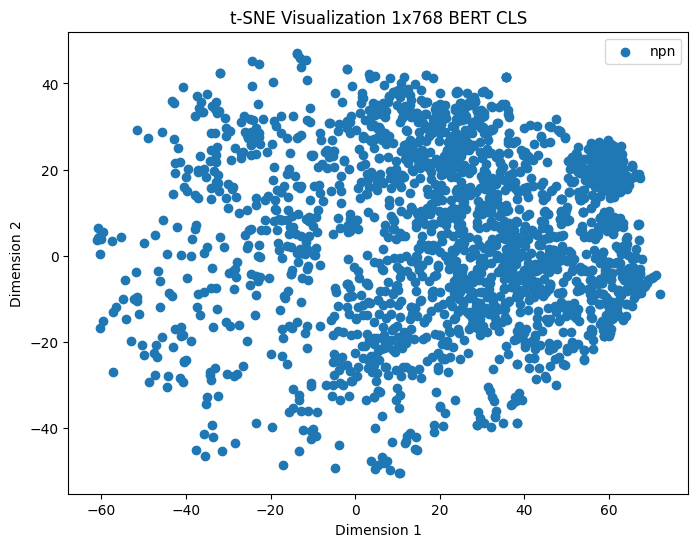

In [3136]:
plt.figure(figsize=(8, 6))
label = 'npn'
subset = tsne_df.loc[dict_sets[label]]
plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)
plt.title('t-SNE Visualization 1x768 BERT CLS')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

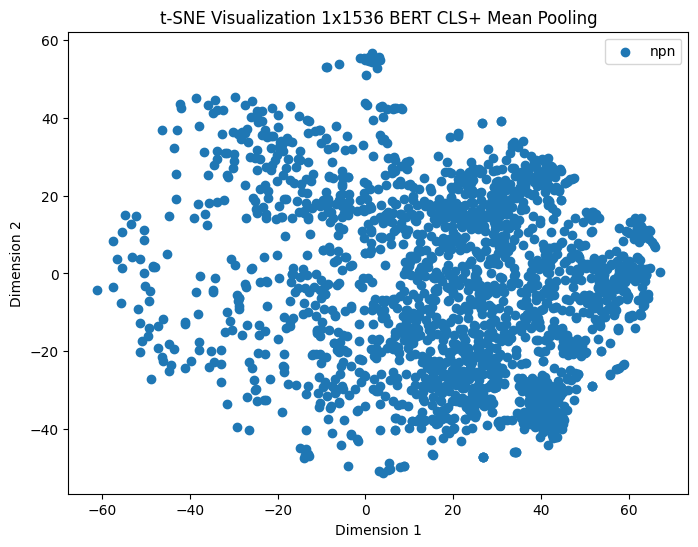

In [3137]:
plt.figure(figsize=(8, 6))
subset = tsne_df1.loc[dict_sets[label]]
plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)
plt.title('t-SNE Visualization 1x1536 BERT CLS+ Mean Pooling')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

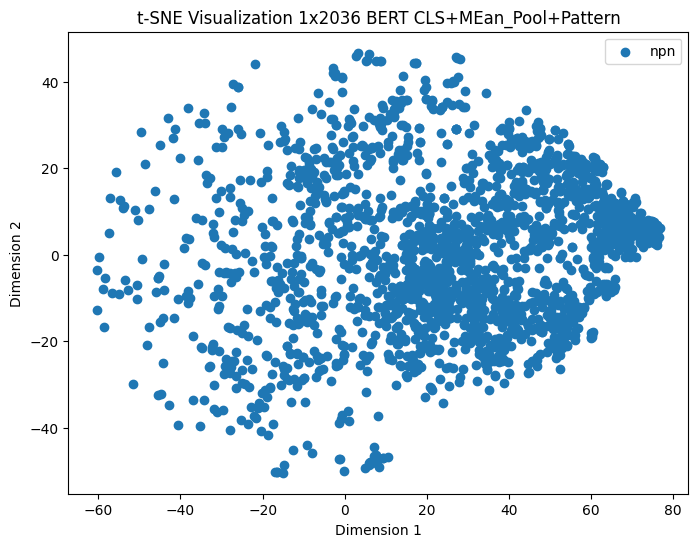

In [3138]:
plt.figure(figsize=(8, 6))
subset = tsne_df_pat.loc[dict_sets[label]]
plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)
plt.title('t-SNE Visualization 1x2036 BERT CLS+MEan_Pool+Pattern')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

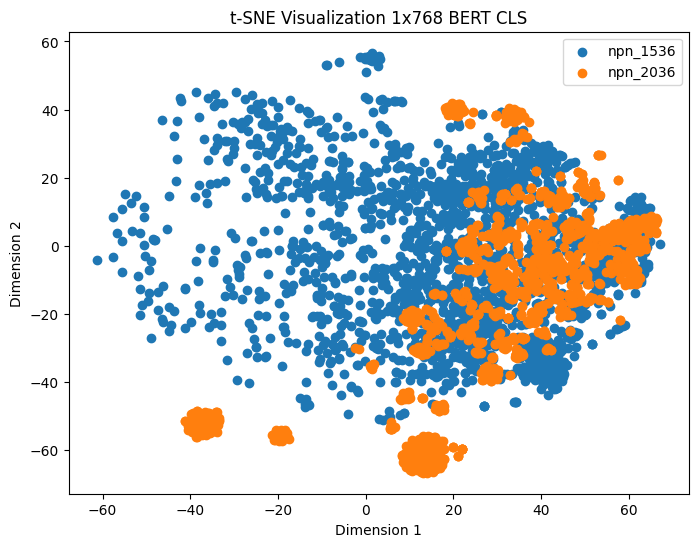

In [1980]:
plt.figure(figsize=(8, 6))
lab = 'npn'
label = 'npn_768'
label1 = 'npn_1536'
label2 = 'npn_2036'
subset = tsne_df.loc[dict_sets[lab]]
subset1 = tsne_df1.loc[dict_sets[lab]]
subset2 = tsne_df_pat.loc[dict_sets[lab]]
#plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)
plt.scatter(subset1['Dimension 1'], subset1['Dimension 2'], label=label1)
plt.scatter(subset2['Dimension 1'], subset2['Dimension 2'], label=label2)
plt.title('t-SNE Visualization 1x768 BERT CLS')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

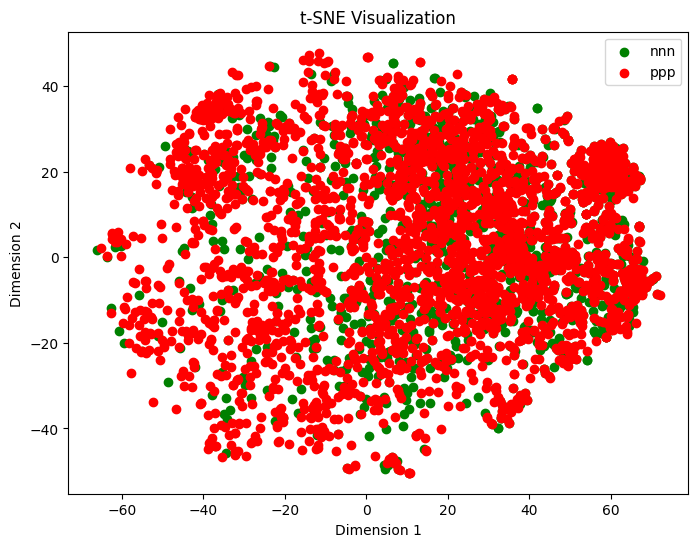

In [1981]:
plt.figure(figsize=(8, 6))
label = 'nnn'
subset = tsne_df.loc[dict_sets[label]]
plt.scatter(subset['Dimension 1'], subset['Dimension 2'], color = 'green',label=label)
label = 'ppp'
subset = tsne_df.loc[dict_sets[label]]
plt.scatter(subset['Dimension 1'], subset['Dimension 2'], color = 'red',label=label)
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

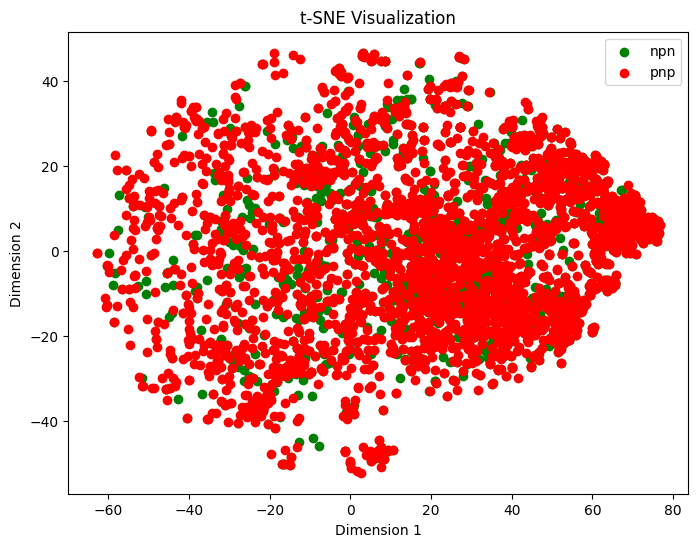

In [3139]:
plt.figure(figsize=(8, 6))
label = 'npn'
subset = tsne_df_pat.loc[dict_sets[label]]
plt.scatter(subset['Dimension 1'], subset['Dimension 2'], color = 'green',label=label)
label = 'pnp'
subset = tsne_df_pat.loc[dict_sets[label]]
plt.scatter(subset['Dimension 1'], subset['Dimension 2'], color = 'red',label=label)
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

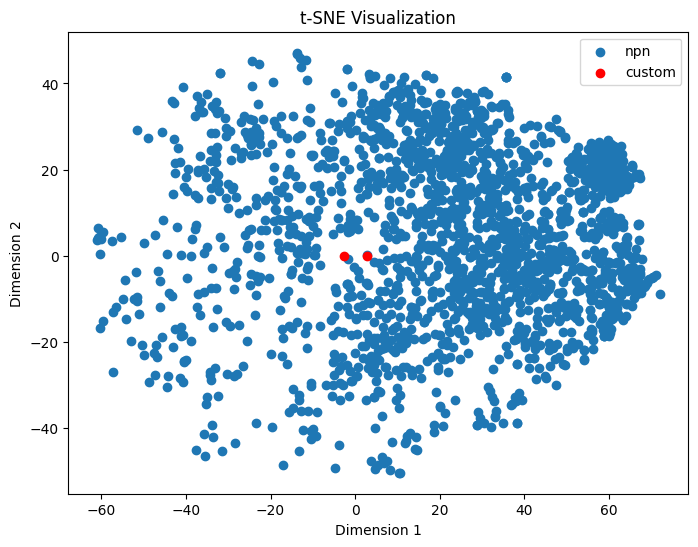

In [1983]:
data1 = get_spl_sentence_embedding("happy")
data2 = get_spl_sentence_embedding("very happy")
#data1 = data1.detach().numpy()
#data2 = data2.detach().numpy()
data3 = np.append(data1,data2,axis=0)
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data3)
plt.figure(figsize=(8, 6))
label = 'npn'
subset = tsne_df.loc[dict_sets[label]]
plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)
label = 'pnp'
subset = tsne_df.loc[dict_sets[label]]
#plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)
label = 'custom'
plt.scatter(data_2d[:, 0], data_2d[:, 1],color = 'red',label = label)

plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [348]:
data1 = get_sentence_embedding("Hi This is good")
data2 = get_sentence_embedding("Hi this is bad. this is good. This is good")
data1 = data1.detach().numpy()
data2 = data2.detach().numpy()
data3 = np.append(data1,data2,axis=0)
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


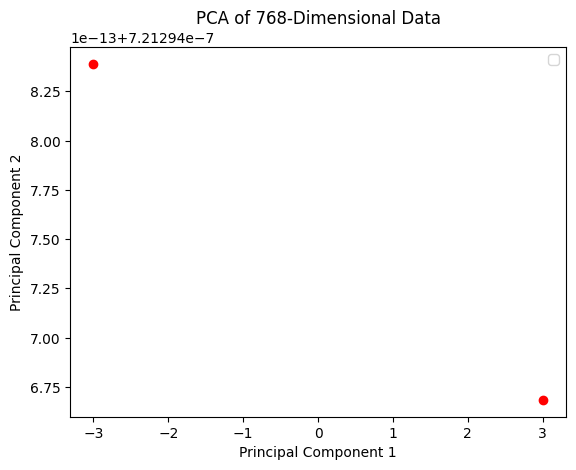

In [349]:

# Perform PCA to reduce the data to 2 dimensions


# Create a scatter plot of the reduced-dimensional data



plt.scatter(data_2d[:, 0], data_2d[:, 1],color = 'red')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 768-Dimensional Data')
plt.legend()
plt.show()

In [350]:
len(data_2d)

2

In [112]:
a = np.array([[1,2,3,4],[6,7,8,9]])

In [113]:
a1 = a.reshape(-4,8)

In [114]:
a1

array([[1, 2, 3, 4, 6, 7, 8, 9]])

In [115]:
from sklearn.metrics.pairwise import cosine_similarity

In [370]:
data1 = get_spl_sentence_embedding(" This is absurd. I am really very happy. The baby looks so beautiful")
data2 = get_spl_sentence_embedding("Moto rally took place on 2011. Surprising Dinasours originated in the sea")
data1 = data1.reshape(1,-1)
data2 = data2.reshape(1,-1)
similarity = cosine_similarity(data1,data2)
similarity[0][0]

0.6678953

In [371]:
data3.shape

(2, 768)

In [372]:
docu_embed1.shape

(5000, 1536)

### K-means Clustering

In [4428]:
from sklearn.cluster import KMeans
num_clusters = 2

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(docu_embed)


Text(0.5, 1.0, 'Value Frequencies in Numpy Array')

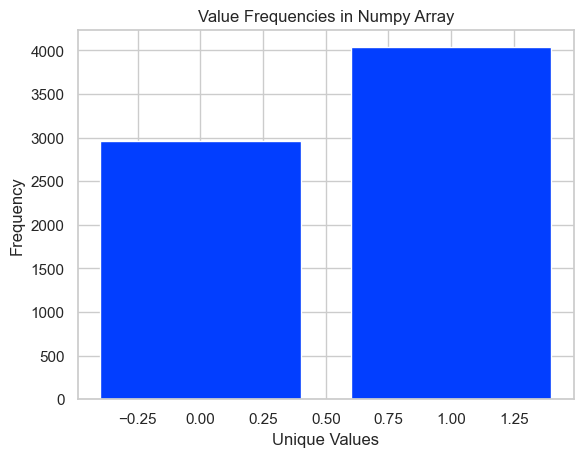

In [4429]:
unique_values, value_counts = np.unique(cluster_labels, return_counts=True)

# Create a bar plot
plt.bar(unique_values, value_counts)

# Set labels and title
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Value Frequencies in Numpy Array')


In [4430]:
cluster_sets = {}
for i in unique_values:
    cluster_sets[i]=[]
for i in unique_values:
    for j in range(len(cluster_labels)):
        if i== cluster_labels[j]:
            cluster_sets[i].append(j)

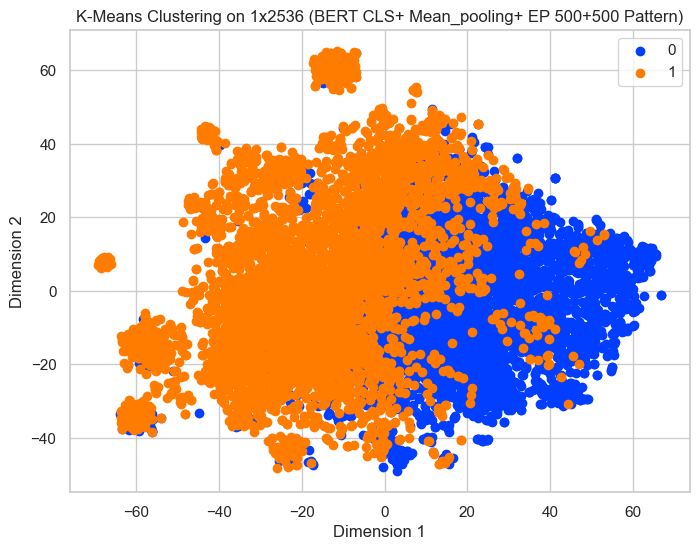

In [4431]:
plt.figure(figsize=(8, 6))
# Iterate over unique labels
for label in cluster_sets:
    subset = tsne_df_pat.loc[cluster_sets[label]]
    plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)

plt.title('K-Means Clustering on 1x2536 (BERT CLS+ Mean_pooling+ EP 500+500 Pattern)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

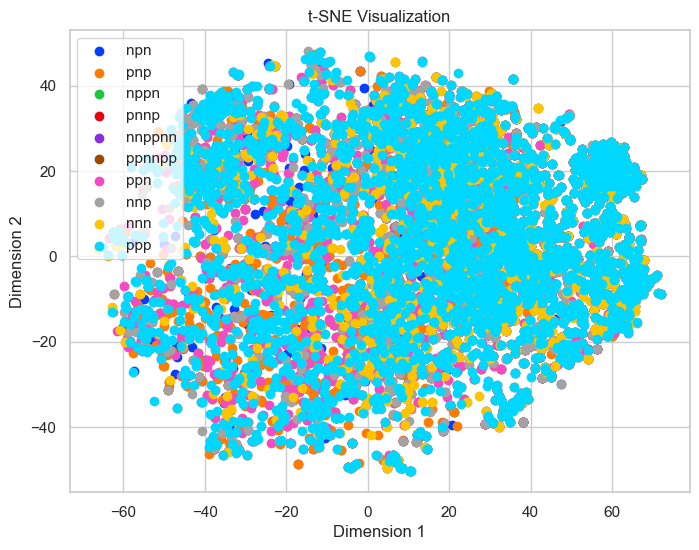

In [4432]:
plt.figure(figsize=(8, 6))
# Iterate over unique labels
for label in dict_sets:
    subset = tsne_df.loc[dict_sets[label]]
    plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)

plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

In [124]:
data1 = docu_embed1[0]
data1 = data1.reshape(1,-1)
similarity = []
for i in range(len(docu_embed1)-4500):
    data2 = docu_embed1[i]
    data2 = data2.reshape(1,-1)
    similarity.append(cosine_similarity(data1,data2))


In [125]:
zz = np.array(similarity)

In [126]:
zx = zz.flatten()

In [127]:
zx[0] = 0

In [128]:
np.argmax(zx.flatten())

118

In [129]:
zx[159]

0.7842881

In [130]:
data_amazon_nrc['review'].iloc[159]

"I loved Ralph's Party so of course I had to read this sophmore effort. Talk about your sophmore slumps! Obvious from the beginning but worse yet not an enjoyable journey to the inevitable. Dig and Nadine weren't even likable characters, their machinations were predictable and the plot thin, if not implausible. I didn't enjoy the long flashbacks, I found them disruptive. Glimpses of their teenage years with more adult reflection would have been more effective. The major plot device that brought about the conclusion is just plain hackneyed.Read Ralph's Party, skip this one and hopefully her next book will be as good as the first!"

In [131]:
data_amazon_nrc['review'].iloc[0]


"I've always been a big fan of WC, especially the music...but this sound track is better than the music for the games. The only thing it's missing is the intro with the Kennedy speech."

## Attempting to add the pattern state with the BERT Vector

In [132]:
data_amazon_nrc

Unnamed: 0  sentiment  \
1097352     1097352          1   
3532118     3532118          1   
3458262     3458262          1   
862749       862749         -1   
2015274     2015274          1   
...             ...        ...   
1905595     1905595          1   
675634       675634          1   
691232       691232          1   
1427758     1427758          1   
3448003     3448003         -1   

                                                    review   emopattern  \
1097352  I've always been a big fan of WC, especially t...          spn   
3532118  Harper stretches himself pretty thin trying to...        snnpp   
3458262  My wife and I have heard a great deal about th...      spnpppp   
862749   I have had wonderful results from Manitoba Har...       spnnnn   
2015274  When it comes to music and lyrics (and life in...       sppppp   
...                                                    ...          ...   
1905595  This is great for astronomy. White flashlight ...          spp   
675634   Well when i first read this i figuerd, wow Bil...          spp   
691232   For me, this is the best single in the 'jason-...        spppp   
1427758  The first story "Breakfast at Tiffany's" is wo...          spp   
3448003  Page 243 of about 300 in this novel brings the...  spnnnnpnnnn   

         emoscore  pnp  npn  pnpn  npnp  ppp  ...     anger  anticip  \
1097352  0.344052    0    0     0     0    0  ...  0.000000      0.0   
3532118  0.950118    0    0     0     0    0  ...  0.033333      0.0   
3458262  0.187985    1    0     0     0    1  ...  0.100000      0.0   
862749   0.827490    0    0     0     0    0  ...  0.055556      0.0   
2015274  0.371711    0    0     0     0    1  ...  0.000000      0.0   
...           ...  ...  ...   ...   ...  ...  ...       ...      ...   
1905595  0.321128    0    0     0     0    0  ...  0.000000      0.0   
675634   0.328725    0    0     0     0    0  ...  0.000000      0.0   
691232   0.975791    0    0     0     0    1  ...  0.000000      0.0   
1427758  0.595648    0    0     0     0    0  ...  0.000000      0.0   
3448003  0.726622    0    1     0     0    0  ...  0.078947      0.0   

            trust  surprise  positive  negative   sadness   disgust       joy  \
1097352  0.000000  0.000000  0.272727  0.090909  0.272727  0.000000  0.181818   
3532118  0.166667  0.100000  0.266667  0.033333  0.000000  0.033333  0.166667   
3458262  0.066667  0.100000  0.100000  0.133333  0.133333  0.033333  0.100000   
862749   0.111111  0.166667  0.111111  0.111111  0.111111  0.000000  0.111111   
2015274  0.250000  0.083333  0.250000  0.083333  0.083333  0.000000  0.166667   
...           ...       ...       ...       ...       ...       ...       ...   
1905595  0.200000  0.000000  0.400000  0.000000  0.000000  0.000000  0.200000   
675634   0.333333  0.000000  0.500000  0.000000  0.000000  0.000000  0.166667   
691232   0.230769  0.153846  0.269231  0.038462  0.000000  0.000000  0.115385   
1427758  0.200000  0.200000  0.400000  0.000000  0.000000  0.000000  0.200000   
3448003  0.026316  0.052632  0.078947  0.184211  0.157895  0.131579  0.052632   

         anticipation  
1097352      0.090909  
3532118      0.200000  
3458262      0.133333  
862749       0.111111  
2015274      0.083333  
...               ...  
1905595      0.200000  
675634       0.000000  
691232       0.153846  
1427758      0.000000  
3448003      0.131579  

[5000 rows x 29 columns]

In [133]:
frequency_distributions = {}

# Iterate through columns
for column in pattern_list:
    frequency_distributions[column] = data_amazon_nrc[column].value_counts()

In [134]:
frequency_distributions = pd.DataFrame(frequency_distributions)

In [135]:
frequency_distributions 

npn     pnp    nppn    pnnp  nnppnn  ppnnpp   ppn   nnp   nnn   ppp
0  4119  4060.0  4728.0  4628.0  4946.0  4935.0  3948  3750  3556  3489
1   817   862.0   261.0   361.0    54.0    65.0   953  1135  1204  1249
2    60    74.0    11.0    11.0     NaN     NaN    93   107   222   223
3     3     4.0     NaN     NaN     NaN     NaN     5     7    15    35
4     1     NaN     NaN     NaN     NaN     NaN     1     1     3     4

In [136]:
frequency_distributions = frequency_distributions.fillna(0)
                                                        

In [137]:
frequency_distributions = frequency_distributions.transpose()

In [138]:
frequency_distributions[np.array(frequency_distributions.columns)]

0       1      2     3    4
npn     4119.0   817.0   60.0   3.0  1.0
pnp     4060.0   862.0   74.0   4.0  0.0
nppn    4728.0   261.0   11.0   0.0  0.0
pnnp    4628.0   361.0   11.0   0.0  0.0
nnppnn  4946.0    54.0    0.0   0.0  0.0
ppnnpp  4935.0    65.0    0.0   0.0  0.0
ppn     3948.0   953.0   93.0   5.0  1.0
nnp     3750.0  1135.0  107.0   7.0  1.0
nnn     3556.0  1204.0  222.0  15.0  3.0
ppp     3489.0  1249.0  223.0  35.0  4.0

In [139]:
np.array(frequency_distributions.index)

array(['npn', 'pnp', 'nppn', 'pnnp', 'nnppnn', 'ppnnpp', 'ppn', 'nnp',
       'nnn', 'ppp'], dtype=object)

In [140]:
embedding1.shape

(1, 1536)

### Adding Pattern Embedding - assuming largest number of frequency for any patter is 5, then we have to convert
We use npn,pnp,nppn,pnnp,nnn,ppp  a 1x6 dimension vector for pattern embedding


In [141]:
pattern_list

['npn', 'pnp', 'nppn', 'pnnp', 'nnppnn', 'ppnnpp', 'ppn', 'nnp', 'nnn', 'ppp']

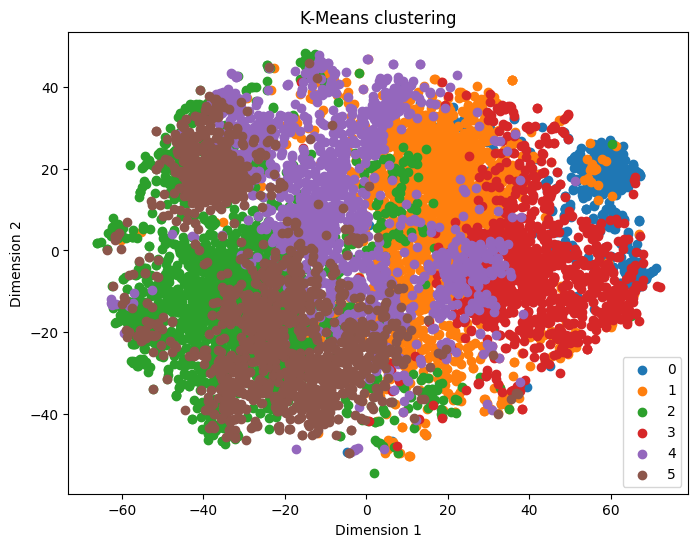

In [3158]:
num_clusters = 6

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(embedding_bert_patt)
unique_values, value_counts = np.unique(cluster_labels, return_counts=True)
cluster_sets = {}
for i in unique_values:
    cluster_sets[i]=[]
for i in unique_values:
    for j in range(len(cluster_labels)):
        if i== cluster_labels[j]:
            cluster_sets[i].append(j)
plt.figure(figsize=(8, 6))
# Iterate over unique labels
for label in cluster_sets:
    subset = tsne_df.loc[cluster_sets[label]]
    plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)
plt.title('K-Means clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()


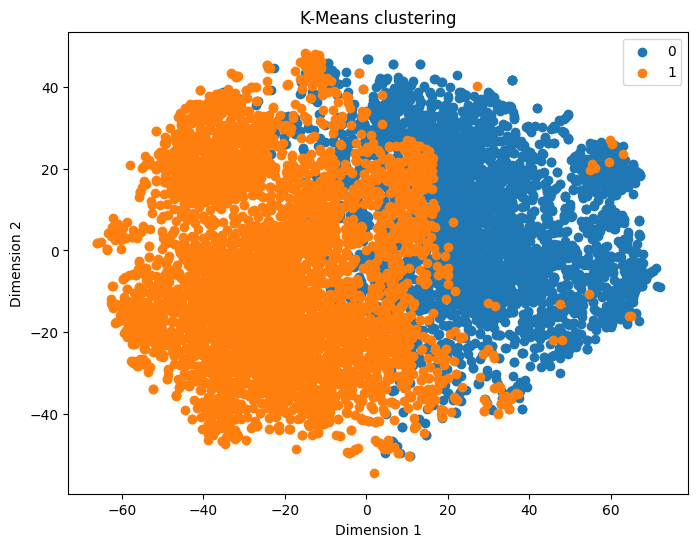

In [3160]:
num_clusters = 2

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(docu_embed)
unique_values, value_counts = np.unique(cluster_labels, return_counts=True)
cluster_sets = {}
for i in unique_values:
    cluster_sets[i]=[]
for i in unique_values:
    for j in range(len(cluster_labels)):
        if i== cluster_labels[j]:
            cluster_sets[i].append(j)
plt.figure(figsize=(8, 6))
# Iterate over unique labels
for label in cluster_sets:
    subset = tsne_df.loc[cluster_sets[label]]
    plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)
plt.title('K-Means clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

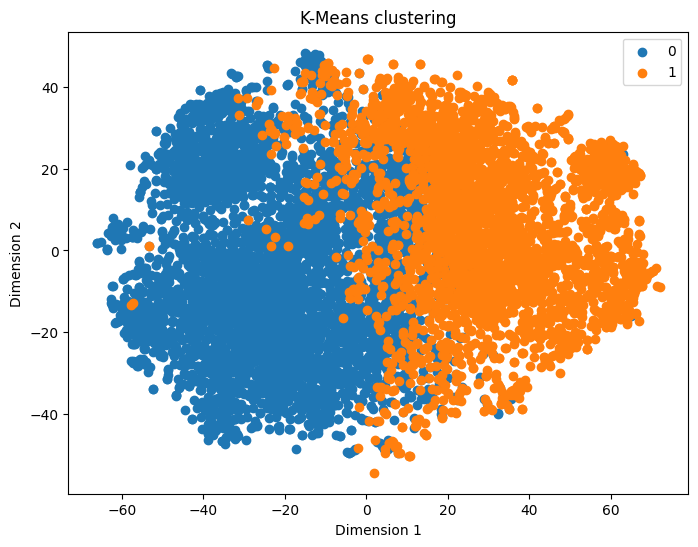

In [3162]:
num_clusters = 2

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(docu_embed1)
unique_values, value_counts = np.unique(cluster_labels, return_counts=True)
cluster_sets = {}
for i in unique_values:
    cluster_sets[i]=[]
for i in unique_values:
    for j in range(len(cluster_labels)):
        if i== cluster_labels[j]:
            cluster_sets[i].append(j)
plt.figure(figsize=(8, 6))
# Iterate over unique labels
for label in cluster_sets:
    subset = tsne_df.loc[cluster_sets[label]]
    plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=label)
plt.title('K-Means clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

In [145]:
tt= str("I am not happy ")
ss = return_emopattern(tt)
return_pattern_match(ss.emopattern)

pnp       0
npn       0
pnpn      0
npnp      0
ppp       0
nnn       0
nnp       0
ppn       0
pnnp      0
nppn      0
nnppnn    0
ppnnpp    0
dtype: int64

In [146]:
ss.emopattern

'sn'

In [147]:
return_sentiment(str(tt))

emopattern_str           n
senti_score       0.210267
dtype: object

In [148]:
blob = TextBlob(tt)
# Access the sentences using the `sentences` attribute
sentences = blob.sentences
for sen in sentences:
    temp = return_sentiment(str(sen))

In [149]:
return_sentiment(str(sentences[0]))

emopattern_str           n
senti_score       0.210267
dtype: object

In [150]:
encoded_input = tokenizer(tt, return_tensors='pt',padding=True,truncation=True)
output = bert_model(**encoded_input)
score = output[0][0].detach().numpy() 
scores = softmax(score)

In [151]:
scores

array([0.21026672, 0.67042446, 0.1193088 ], dtype=float32)

In [152]:
if scores[2] > scores[0]:
    print(scores[2])
else:
    print(-scores[0])

-0.21026672


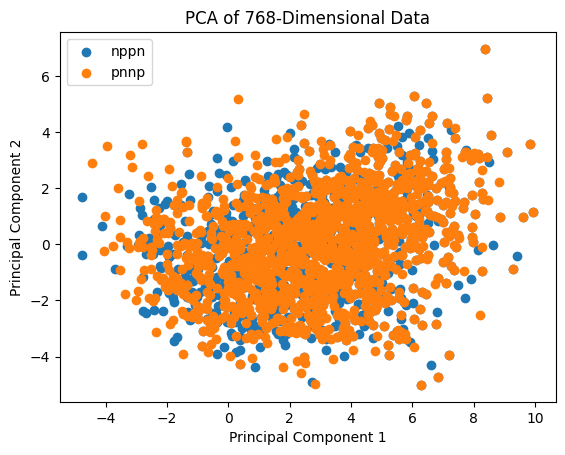

In [3163]:
data = embedding_bert_patt
# Perform PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)
pca_df = pd.DataFrame(data=data_2d, columns=['Dimension 1', 'Dimension 2'])
# Create a scatter plot of the reduced-dimensional data
for label in ['nppn','pnnp']:
    subset1 = pca_df.loc[dict_sets[label]]
    plt.scatter(subset1['Dimension 1'], subset1['Dimension 2'], label=label)
#plt.scatter(data_2d[:, 0], data_2d[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 768-Dimensional Data')
plt.legend()
plt.show()

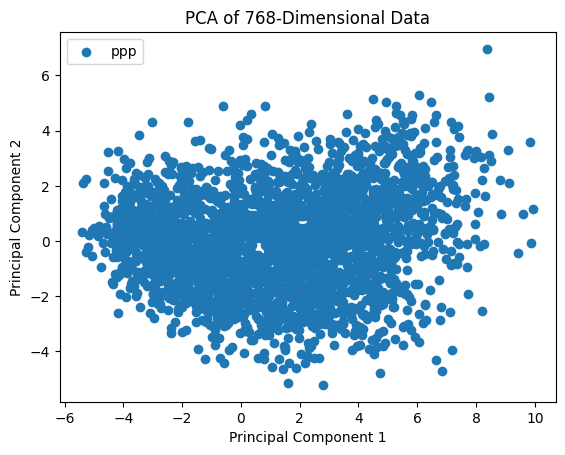

In [3165]:
label = 'ppp'
subset1 = pca_df.loc[dict_sets[label]]
plt.scatter(subset1['Dimension 1'], subset1['Dimension 2'], label=label)
#plt.scatter(data_2d[:, 0], data_2d[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 768-Dimensional Data')
plt.legend()
plt.show()

In [511]:
patt_embedding #This is our Y 
docu_embed1 #This is our X

(5000, 10)

In [619]:
patt_embedding.shape

(5000, 10)

In [531]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the model (as per the previous example)
class EmbeddingMapper(nn.Module):
    def __init__(self, input_size, output_size):
        super(EmbeddingMapper, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 1024),  # Adjust hidden layer size as needed
            nn.Sigmoid(),  # You can use other activation functions as well
            nn.Linear(1024, output_size)
        )
        
    def forward(self, x):
        out = self.fc(x)
        return out






In [615]:
# Hyperparameters
input_size = 1536
output_size = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 40


d_input = docu_embed1
d_output = patt_embedding

# Convert  data to PyTorch tensors
input_data = torch.Tensor(d_input)
output_data = torch.Tensor(d_output)

# Create a DataLoader (for batching, assuming you have more than one sample)
dataset = torch.utils.data.TensorDataset(input_data, output_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = EmbeddingMapper(input_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [617]:
# Train the model
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Note: In this example, we're using Mean Squared Error Loss (MSE) because we're treating this as a regression problem.

Epoch [1/40], Loss: 0.0045
Epoch [2/40], Loss: 0.0044
Epoch [3/40], Loss: 0.0021
Epoch [4/40], Loss: 0.0039
Epoch [5/40], Loss: 0.0039
Epoch [6/40], Loss: 0.0023
Epoch [7/40], Loss: 0.0030
Epoch [8/40], Loss: 0.0035
Epoch [9/40], Loss: 0.0043
Epoch [10/40], Loss: 0.0041
Epoch [11/40], Loss: 0.0023
Epoch [12/40], Loss: 0.0024
Epoch [13/40], Loss: 0.0030
Epoch [14/40], Loss: 0.0029
Epoch [15/40], Loss: 0.0046
Epoch [16/40], Loss: 0.0030
Epoch [17/40], Loss: 0.0018
Epoch [18/40], Loss: 0.0022
Epoch [19/40], Loss: 0.0019
Epoch [20/40], Loss: 0.0015
Epoch [21/40], Loss: 0.0010
Epoch [22/40], Loss: 0.0019
Epoch [23/40], Loss: 0.0016
Epoch [24/40], Loss: 0.0011
Epoch [25/40], Loss: 0.0015
Epoch [26/40], Loss: 0.0008
Epoch [27/40], Loss: 0.0011
Epoch [28/40], Loss: 0.0012
Epoch [29/40], Loss: 0.0007
Epoch [30/40], Loss: 0.0012
Epoch [31/40], Loss: 0.0010
Epoch [32/40], Loss: 0.0007
Epoch [33/40], Loss: 0.0008
Epoch [34/40], Loss: 0.0009
Epoch [35/40], Loss: 0.0007
Epoch [36/40], Loss: 0.0004
E

In [4023]:
embedding_bert_patt.shape

(7000, 2536)

In [620]:
# Hyperparameters
input_size = 2036
output_size = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 40


d_input = embedding_bert_patt
d_output = patt_embedding

# Convert  data to PyTorch tensors
input_data = torch.Tensor(d_input)
output_data = torch.Tensor(d_output)

# Create a DataLoader (for batching, assuming you have more than one sample)
dataset = torch.utils.data.TensorDataset(input_data, output_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = EmbeddingMapper(input_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Note: In this example, we're using Mean Squared Error Loss (MSE) because we're treating this as a regression problem.

Epoch [1/40], Loss: 0.0003
Epoch [2/40], Loss: 0.0001
Epoch [3/40], Loss: 0.0001
Epoch [4/40], Loss: 0.0001
Epoch [5/40], Loss: 0.0000
Epoch [6/40], Loss: 0.0000
Epoch [7/40], Loss: 0.0000
Epoch [8/40], Loss: 0.0000
Epoch [9/40], Loss: 0.0000
Epoch [10/40], Loss: 0.0000
Epoch [11/40], Loss: 0.0001
Epoch [12/40], Loss: 0.0000
Epoch [13/40], Loss: 0.0000
Epoch [14/40], Loss: 0.0000
Epoch [15/40], Loss: 0.0000
Epoch [16/40], Loss: 0.0000
Epoch [17/40], Loss: 0.0001
Epoch [18/40], Loss: 0.0001
Epoch [19/40], Loss: 0.0000
Epoch [20/40], Loss: 0.0000
Epoch [21/40], Loss: 0.0001
Epoch [22/40], Loss: 0.0003
Epoch [23/40], Loss: 0.0000
Epoch [24/40], Loss: 0.0000
Epoch [25/40], Loss: 0.0000
Epoch [26/40], Loss: 0.0000
Epoch [27/40], Loss: 0.0000
Epoch [28/40], Loss: 0.0000
Epoch [29/40], Loss: 0.0000
Epoch [30/40], Loss: 0.0000
Epoch [31/40], Loss: 0.0000
Epoch [32/40], Loss: 0.0000
Epoch [33/40], Loss: 0.0000
Epoch [34/40], Loss: 0.0000
Epoch [35/40], Loss: 0.0000
Epoch [36/40], Loss: 0.0000
E

## BERT Topic and t-SNE and UMAP

In [630]:
!pip install bertopic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [631]:
from bertopic import BERTopic

In [632]:
docs = data_amazon_nrc['review']

In [633]:
type(docs)

pandas.core.series.Series

In [634]:
model = BERTopic()
topics, probs = model.fit_transform(docs)

In [548]:
model.get_topic_freq()

Topic  Count
5       0   1604
3       1    749
0       2    638
6      -1    577
28      3    109
7       4    100
19      5     89
14      6     66
12      7     58
1       8     57
30      9     56
22     10     55
24     11     54
31     12     42
21     13     42
37     14     42
16     15     41
9      16     36
8      17     31
13     18     29
40     19     28
32     20     26
15     21     26
36     22     25
34     23     25
23     24     23
2      25     23
26     26     23
33     27     23
35     28     21
41     29     20
4      30     19
29     31     19
11     32     17
27     33     16
38     34     15
43     35     15
18     36     14
10     37     14
44     38     14
45     39     13
25     40     13
20     41     13
42     42     12
39     43     12
17     44     12
49     45     12
47     46     11
48     47     11
46     48     10

In [635]:
model.get_topic_info()

Topic  Count                                  Name  \
0      -1    616                       -1_it_the_to_my   
1       0   1598                      0_book_the_of_to   
2       1    755                 1_movie_the_film_this   
3       2    632                2_album_cd_music_songs   
4       3    106                       3_toy_it_my_old   
5       4    100                  4_game_games_play_it   
6       5     83              5_item_was_product_order   
7       6     76               6_tool_tools_use_dewalt   
8       7     65                     7_pot_it_oven_the   
9       8     62               8_workout_video_and_for   
10      9     61               9_shoes_them_they_these   
11     10     59                   10_hair_skin_dry_it   
12     11     56                   11_player_it_to_the   
13     12     47            12_light_product_it_seller   
14     13     44           13_taste_licorice_sugar_are   
15     14     42       14_software_computer_xp_windows   
16     15     41           15_camera_pictures_lens_for   
17     16     35               16_seat_carseat_baby_it   
18     17     30                   17_bag_bags_tent_it   
19     18     27                 18_diet_my_product_to   
20     19     27     19_battery_batteries_charge_phone   
21     20     25          20_printer_ink_cartridges_hp   
22     21     24      21_antenna_channels_works_signal   
23     22     23           22_watch_watches_band_timex   
24     23     23      23_coffee_espresso_maker_machine   
25     24     22                  24_gun_scope_mag_bbs   
26     25     22                 25_rack_lock_bike_key   
27     26     21              26_drive_drives_usb_hard   
28     27     21             27_filter_filters_air_fit   
29     28     21        28_cable_cables_the_microphone   
30     29     19    29_phone_answering_cordless_caller   
31     30     18             30_vacuum_stains_dirt_mop   
32     31     18            31_clock_noise_alarm_sleep   
33     32     18          32_diaper_baby_nipple_toilet   
34     33     17          33_headphones_ears_ear_these   
35     34     16        34_spray_products_comb_product   
36     35     16                  35_air_heater_fan_it   
37     36     14                       36_de_que_la_es   
38     37     13            37_mouse_pad_mice_wireless   
39     38     12  38_thermometer_temperature_oven_meat   
40     39     12         39_headset_headsets_they_them   
41     40     11          40_gps_navigator_garmin_nuvi   
42     41     11        41_misaligned_sturdy_after_and   
43     42     11        42_razor_shaver_trimmer_razors   
44     43     10              43_bowl_blender_nut_unit   
45     44     10             44_features_for_deluxe_it   
46     45     10              45_warranty_unit_kaz_pay   

                                       Representation  \
0     [it, the, to, my, and, for, not, is, this, was]   
1   [book, the, of, to, and, this, in, is, read, t...   
2   [movie, the, film, this, is, and, of, was, to,...   
3   [album, cd, music, songs, of, is, this, the, a...   
4    [toy, it, my, old, for, and, she, year, the, we]   
5   [game, games, play, it, the, to, that, and, yo...   
6   [item, was, product, order, not, it, they, ret...   
7   [tool, tools, use, dewalt, it, the, for, have,...   
8   [pot, it, oven, the, toaster, heat, to, use, k...   
9   [workout, video, and, for, yoga, to, my, weigh...   
10  [shoes, them, they, these, wear, size, comfort...   
11  [hair, skin, dry, it, product, my, shampoo, an...   
12  [player, it, to, the, mp3, cd, for, had, have,...   
13  [light, product, it, seller, to, the, was, thi...   
14  [taste, licorice, sugar, are, flavor, soy, the...   
15  [software, computer, xp, windows, to, it, 2005...   
16  [camera, pictures, lens, for, it, and, the, on...   
17  [seat, carseat, baby, it, pillow, my, the, to,...   
18  [bag, bags, tent, it, the, mower, and, we, in,...   
19  [diet, my, product, to, doctors, me, and, anti...   
20  [battery, batterie

In [647]:
!pip install nbformat

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for nbformat from https://files.pythonhosted.org/packages/f4/e7/ef30a90b70eba39e675689b9eaaa92530a71d7435ab8f9cae520814e0caf/nbformat-5.9.2-py3-none-any.whl.metadata
  Obtaining dependency information for fastjsonschema from https://files.pythonhosted.org/packages/9d/93/a3ca3cdeb84065d7d8f8df4cb09ab44405f109183c1d2b915ec17574e6b1/fastjsonschema-2.18.0-py3-none-any.whl.metadata
  Obtaining dependency information for jsonschema>=2.6 from https://files.pythonhosted.org/packages/0f/bf/a84bc75f069f4f156e1c0d9892fb7325945106c6ecaad9f29d24360872af/jsonschema-4.19.

In [651]:
model.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'book | the | of | to | and', 1598],
                                   [1, 'movie | the | film | this | is', 755],
                                   [2, 'album | cd | music | songs | of', 632],
                                   [3, 'toy | it | my | old | for', 106],
                                   [4, 'game | games | play | it | the', 100],
                                   [5, 'item | was | product | order | not', 83],
                                   [6, 'tool | tools | use | dewalt | it', 76],
                                   [7, 'pot | it | oven | the | toaster', 65],
                                   [8, 'workout | video | and | for | yoga', 62],
                                   [9, 'shoes | them | they | these | wear', 61],
                                   [10, 'hair | skin | dry | it | product', 59],
                                   [11, 'player | it | to | the | mp3', 56],
                                   [12, 'light | product | it | seller | to', 47],
                                   [13, 'taste | licorice | sugar | are | flavor', 44],
                                   [14, 'software | computer | xp | windows | to', 42],
                                   [15, 'camera | pictures | lens | for | it', 41],
                                   [16, 'seat | carseat | baby | it | pillow', 35],
                                   [17, 'bag | bags | tent | it | the', 30],
                                   [18, 'diet | my | product | to | doctors', 27],
                                   [19, 'battery | batteries | charge | phone | recharge', 27],
                                   [20, 'printer | ink | cartridges | hp | epson', 25],
                                   [21, 'antenna | channels | works | signal | weather', 24],
                                   [22, 'watch | watches | band | timex | the', 23],
                                   [23, 'coffee | espresso | maker | machine | grinder', 23],
                                   [24, 'gun | scope | mag | bbs | very', 22],
                                   [25, 'rack | lock | bike | key | locks', 22],
                                   [26, 'drive | drives | usb | hard | external', 21],
                                   [27, 'filter | filters | air | fit | for', 21],
                                   [28, 'cable | cables | the | microphone | composite', 21],
                                   [29, 'phone | answering | cordless | caller | skype', 19],
                                   [30, 'vacuum | stains | dirt | mop | suction', 18],
                                   [31, 'clock | noise | alarm | sleep | sound', 18],
                                   [32, 'diaper | baby | nipple | toilet | seat', 18],
                                   [33, 'headphones | ears | ear | these | sound', 17],
                                   [34, 'spray | products | comb | product | flea', 16],
                                   [35, 'air | heater | fan | it | cool', 16],
                                   [36, 'de | que | la | es | en', 14],
                                   [37, 'mouse | pad | mice | wireless | logitech', 13],
                                   [38, 'thermometer | temperature | oven | meat | tester', 12],
                                   [39, 'headset | headsets | they | them | sennheiser', 12],
                                   [40, 'gps | navigator | garmin | nuvi | it', 11],
                                   [41, 'misaligned | sturdy | after | and | broke', 11],
                                   [42, 'razor | shaver | trimmer | razors | braun', 11],
                                   [43, 'bowl | blender | nut | unit | processor', 10],
                                   [44, 'features | for | deluxe | it | bucks', 10],
                                   [45, 'warranty | unit | kaz | pay | it', 10]], dtype=object),
              'hovertemplate': '<b>Topic %{customdata[0]}</b><br>%{customda

In [636]:
from umap import UMAP
 
import matplotlib
import matplotlib.pyplot as plt

 



In [637]:
docs=docs.reset_index(inplace=False)

In [638]:
docs

index                                             review
0     1097352  I've always been a big fan of WC, especially t...
1     3532118  Harper stretches himself pretty thin trying to...
2     3458262  My wife and I have heard a great deal about th...
3      862749  I have had wonderful results from Manitoba Har...
4     2015274  When it comes to music and lyrics (and life in...
...       ...                                                ...
4995  1905595  This is great for astronomy. White flashlight ...
4996   675634  Well when i first read this i figuerd, wow Bil...
4997   691232  For me, this is the best single in the 'jason-...
4998  1427758  The first story "Breakfast at Tiffany's" is wo...
4999  3448003  Page 243 of about 300 in this novel brings the...

[5000 rows x 2 columns]

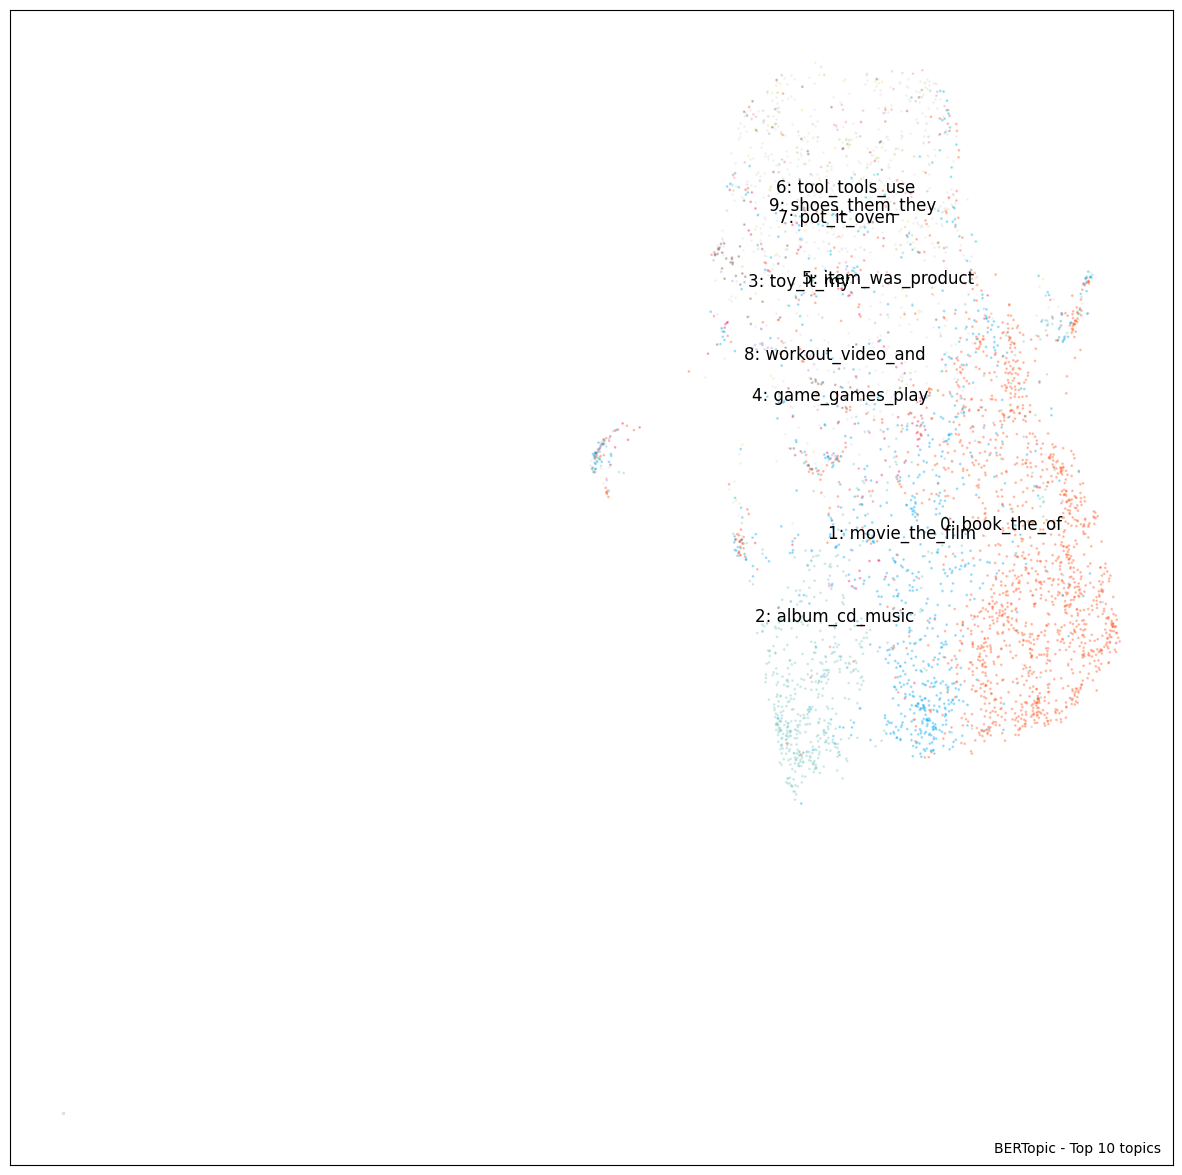

In [639]:
# Prepare data for plotting
embeddings = docu_embed#model._extract_embeddings(docs['review'])
embeddings.shape

umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics
 
# Plot parameters
top_n = 10
fontsize = 12
 
# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]
 
# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                        '#03A9F4', # Blue
                                        '#4CAF50', # Green
                                        '#80CBC4', # FFEB3B
                                        '#673AB7', # Purple
                                        '#795548', # Brown
                                        '#E91E63', # Pink
                                        '#212121', # Black
                                        '#00BCD4', # Light Blue
                                        '#CDDC39', # Yellow/Red
                                        '#AED581', # Light Green
                                        '#FFE082', # Light Orange
                                        '#BCAAA4', # Light Brown
                                        '#B39DDB', # Light Purple
                                        '#F48FB1', # Light Pink
                                        ])
 
# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)
 
# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
   topic = int(row[1].topic)
   text = f"{topic}: " + "_".join([x[0] for x in model.get_topic(topic)[:3]])
   ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')
 
ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.savefig("BERTopic_Example_Cluster_Plot.png")
plt.show()

In [625]:
embedding_bert_patt.shape

(5000, 2036)

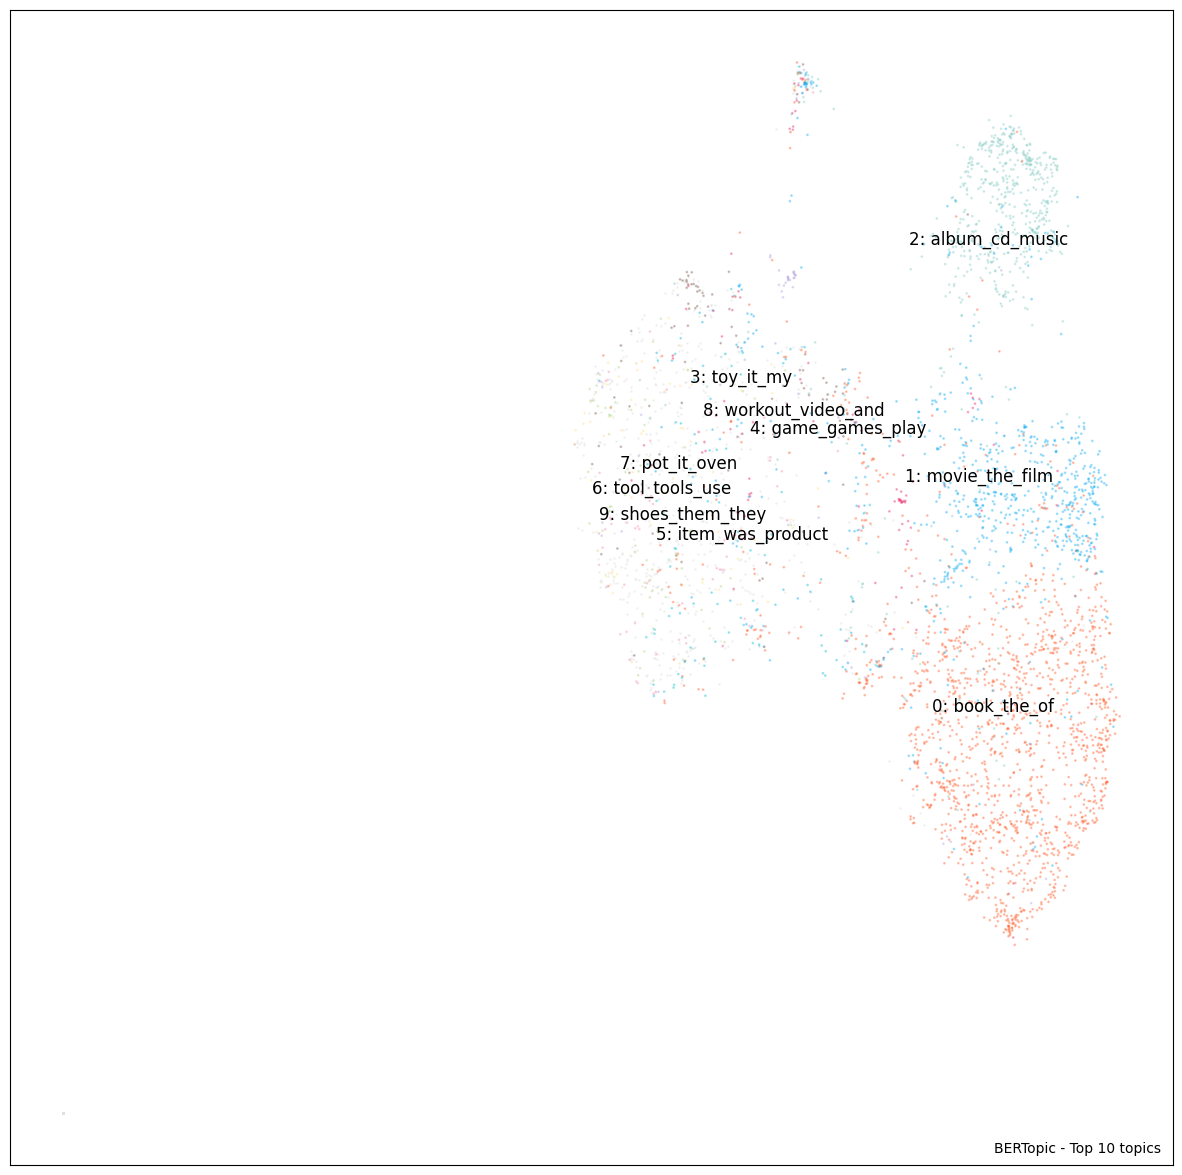

In [640]:
# Prepare data for plotting
embeddings = docu_embed1#model._extract_embeddings(docs['review'])


umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics
 
# Plot parameters
top_n = 10
fontsize = 12
 
# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]
 
# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                        '#03A9F4', # Blue
                                        '#4CAF50', # Green
                                        '#80CBC4', # FFEB3B
                                        '#673AB7', # Purple
                                        '#795548', # Brown
                                        '#E91E63', # Pink
                                        '#212121', # Black
                                        '#00BCD4', # Light Blue
                                        '#CDDC39', # Yellow/Red
                                        '#AED581', # Light Green
                                        '#FFE082', # Light Orange
                                        '#BCAAA4', # Light Brown
                                        '#B39DDB', # Light Purple
                                        '#F48FB1', # Light Pink
                                        ])
 
# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)
 
# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
   topic = int(row[1].topic)
   text = f"{topic}: " + "_".join([x[0] for x in model.get_topic(topic)[:3]])
   ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')
 
ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.savefig("BERTopic_Example_Cluster_Plot.png")
plt.show()

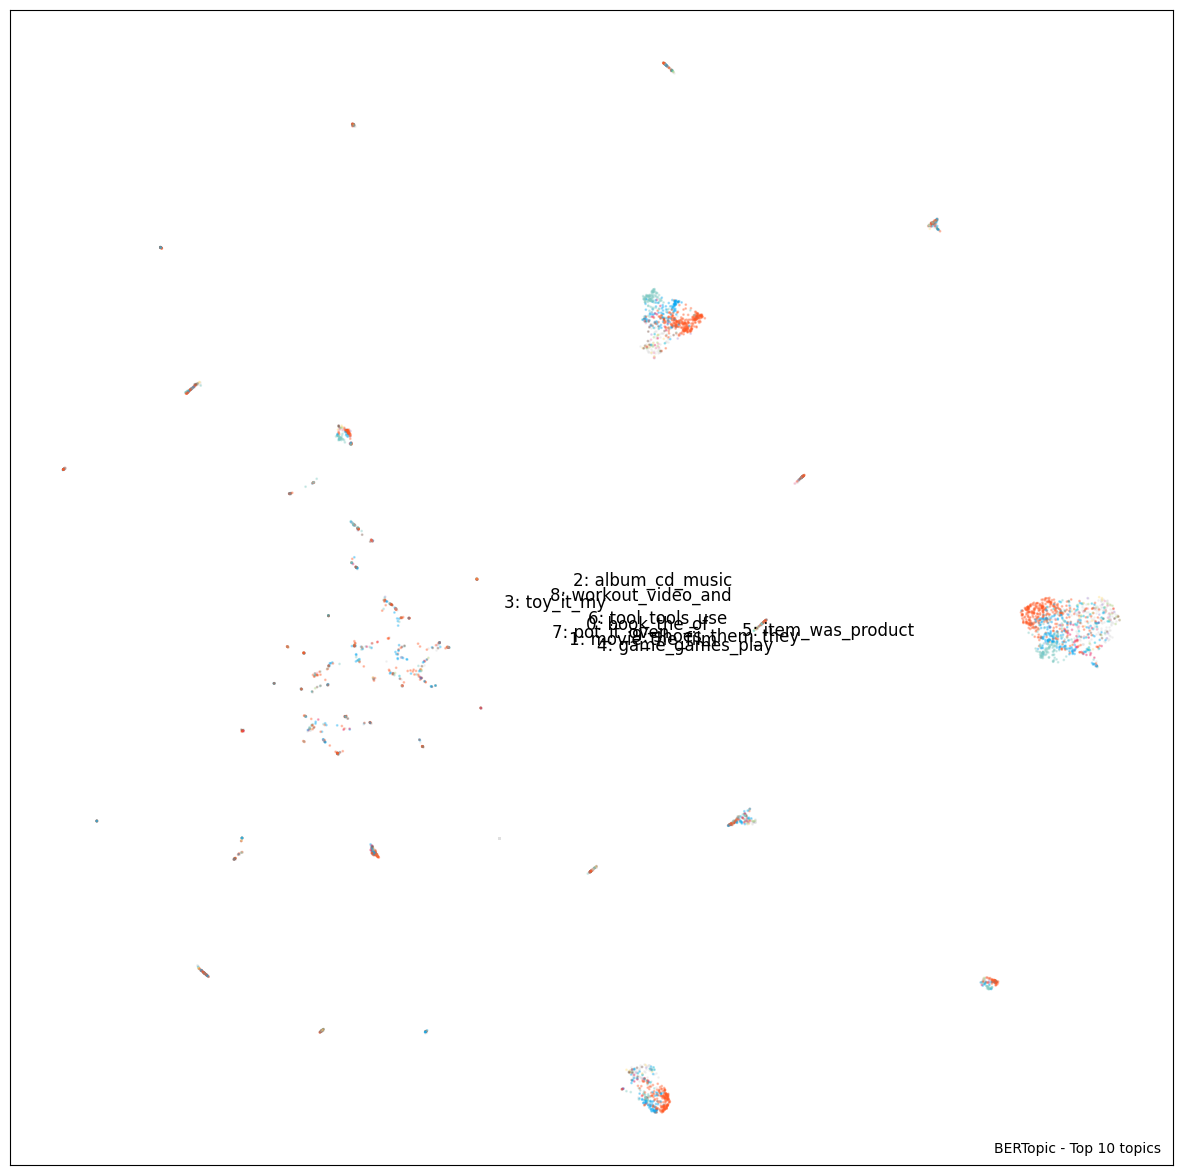

In [641]:
# Prepare data for plotting
embeddings = embedding_bert_patt#model._extract_embeddings(docs['review'])


umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics
 
# Plot parameters
top_n = 10
fontsize = 12
 
# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]
 
# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                        '#03A9F4', # Blue
                                        '#4CAF50', # Green
                                        '#80CBC4', # FFEB3B
                                        '#673AB7', # Purple
                                        '#795548', # Brown
                                        '#E91E63', # Pink
                                        '#212121', # Black
                                        '#00BCD4', # Light Blue
                                        '#CDDC39', # Yellow/Red
                                        '#AED581', # Light Green
                                        '#FFE082', # Light Orange
                                        '#BCAAA4', # Light Brown
                                        '#B39DDB', # Light Purple
                                        '#F48FB1', # Light Pink
                                        ])
 
# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)
 
# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
   topic = int(row[1].topic)
   text = f"{topic}: " + "_".join([x[0] for x in model.get_topic(topic)[:3]])
   ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')
 
ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.savefig("BERTopic_Example_Cluster_Plot.png")
plt.show()

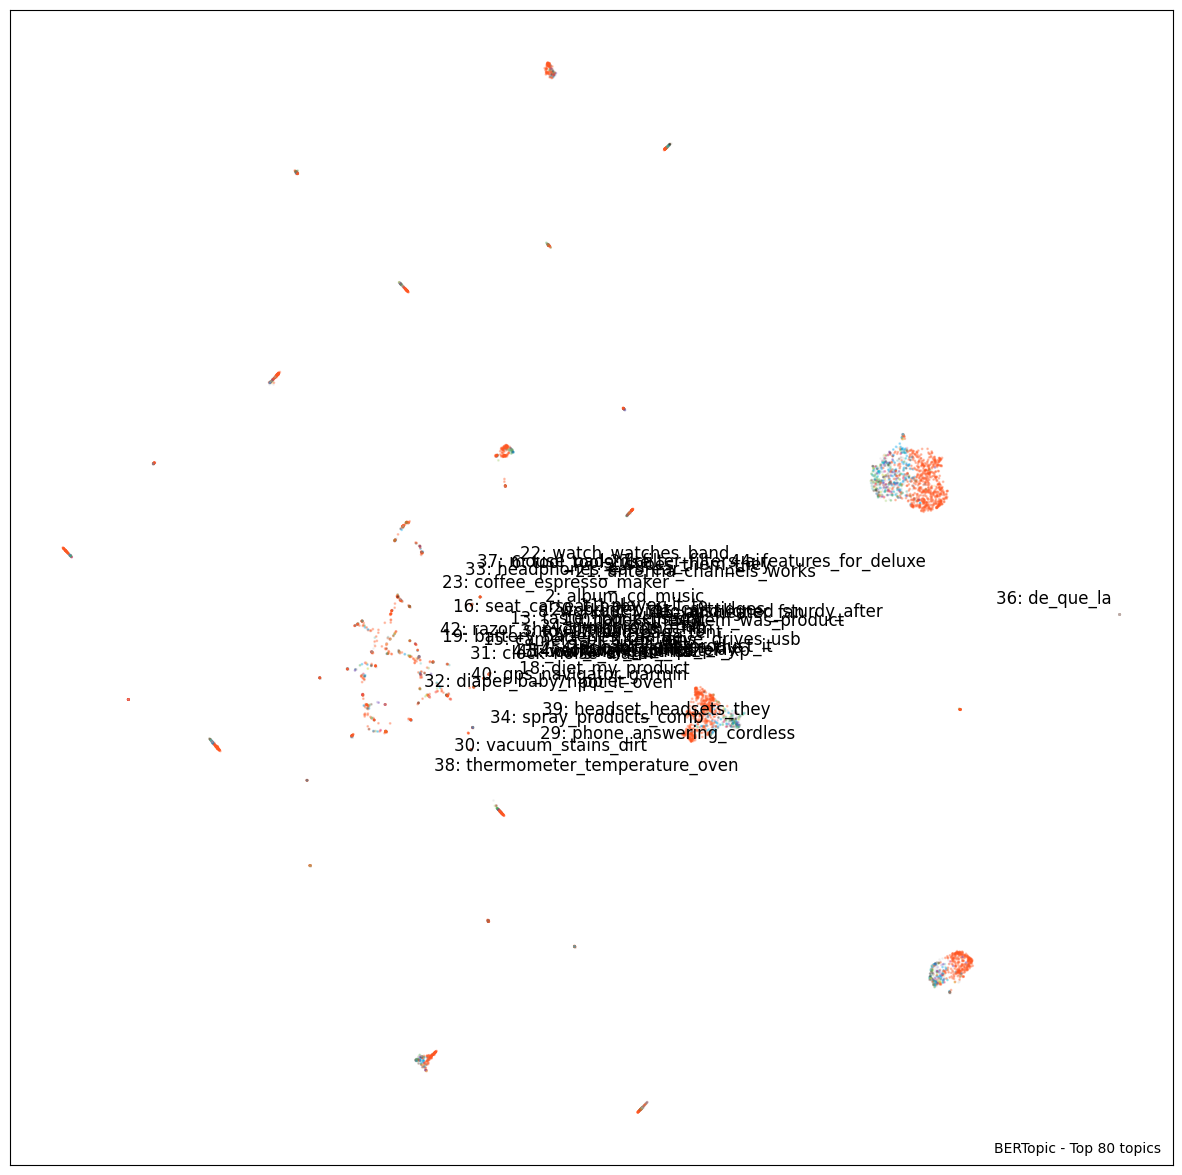

In [653]:
# Prepare data for plotting
embeddings = embedding_bert_patt#model._extract_embeddings(docs['review'])


umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics
 
# Plot parameters
top_n = 80
fontsize = 12
 
# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]
 
# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                        '#03A9F4', # Blue
                                        '#4CAF50', # Green
                                        '#80CBC4', # FFEB3B
                                        '#673AB7', # Purple
                                        '#795548', # Brown
                                        '#E91E63', # Pink
                                        '#212121', # Black
                                        '#00BCD4', # Light Blue
                                        '#CDDC39', # Yellow/Red
                                        '#AED581', # Light Green
                                        '#FFE082', # Light Orange
                                        '#BCAAA4', # Light Brown
                                        '#B39DDB', # Light Purple
                                        '#F48FB1', # Light Pink
                                        ])
 
# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)
 
# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
   topic = int(row[1].topic)
   text = f"{topic}: " + "_".join([x[0] for x in model.get_topic(topic)[:3]])
   ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')
 
ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.savefig("BERTopic_Example_Cluster_Plot.png")
plt.show()

In [673]:
import umap
import matplotlib.pyplot as plt
import numpy as np


# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_umap = reducer.fit_transform(docu_embed)



In [676]:
embedding_umap1 = reducer.fit_transform(docu_embed1)

In [4032]:
embedding_umap2 = reducer.fit_transform(embedding_bert_patt2)

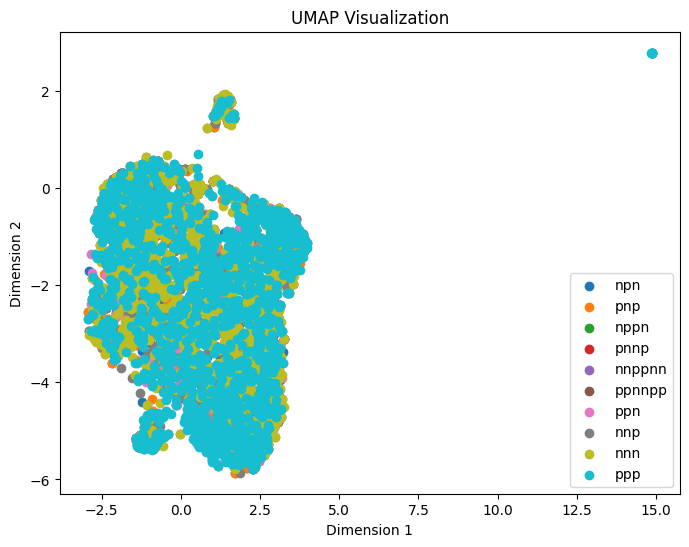

In [674]:
# Visualize the results
embedding_umap = pd.DataFrame(embedding_umap)
plt.figure(figsize=(8, 6))
for label in pattern_list:
    subset = embedding_umap.loc[dict_sets[label]]
    plt.scatter(subset[0], subset[1], label=label)
#plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c='b', cmap='viridis', s=10)
plt.title('UMAP Visualization')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

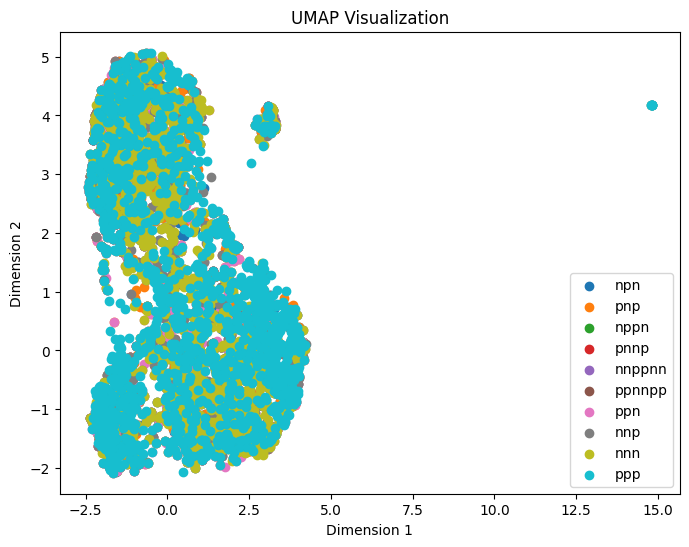

In [678]:
# Visualize the results
embedding_umap1 = pd.DataFrame(embedding_umap1)
plt.figure(figsize=(8, 6))
for label in pattern_list:
    subset = embedding_umap1.loc[dict_sets[label]]
    plt.scatter(subset[0], subset[1], label=label)
#plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c='b', cmap='viridis', s=10)
plt.title('UMAP Visualization')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

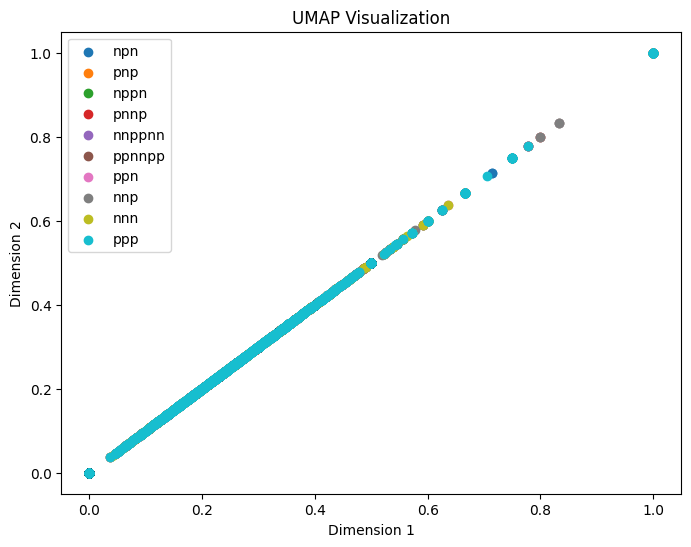

In [3562]:
# Visualize the results
embedding_umap1 = pd.DataFrame(embedding_emo_patt)
plt.figure(figsize=(8, 6))
for label in pattern_list:
    subset = embedding_umap1.loc[dict_sets[label]]
    plt.scatter(subset[0], subset[1], label=label)
#plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c='b', cmap='viridis', s=10)
plt.title('UMAP Visualization')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

In [3558]:
embedding_pat_emo.max().max()

0.0

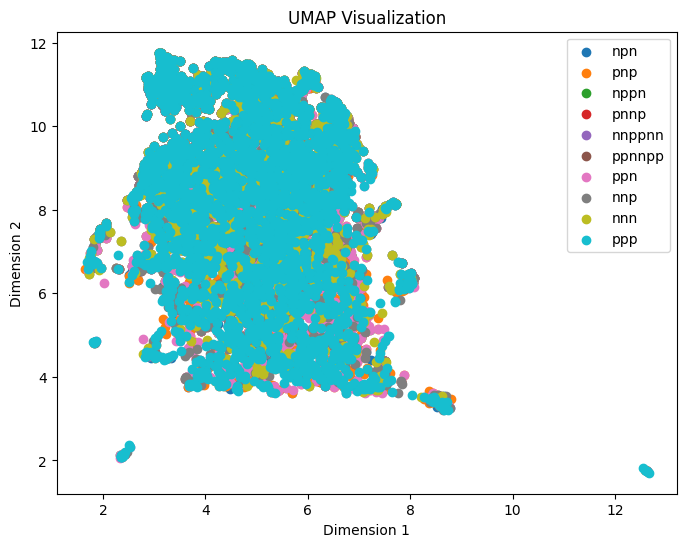

In [4033]:
# Visualize the results
embedding_umap2 = pd.DataFrame(embedding_umap2)
plt.figure(figsize=(8, 6))
for label in pattern_list:
    subset = embedding_umap2.loc[dict_sets[label]]
    plt.scatter(subset[0], subset[1], label=label)
#plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c='b', cmap='viridis', s=10)
plt.title('UMAP Visualization')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

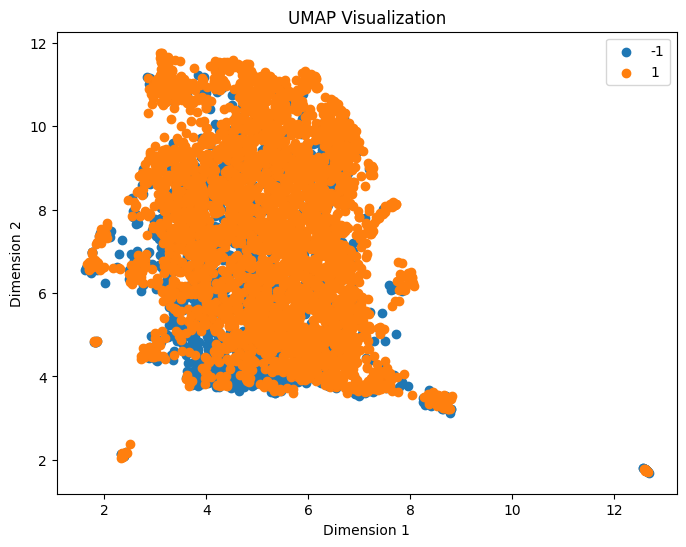

In [4034]:
# Visualize the results
embedding_umap2 = pd.DataFrame(embedding_umap2)
plt.figure(figsize=(8, 6))
for label in [-1,1]:
    subset = embedding_umap2.loc[dict_set_helpful[label]]
    plt.scatter(subset[0], subset[1], label=label)
#plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c='b', cmap='viridis', s=10)
plt.title('UMAP Visualization')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Generate some sample data
np.random.seed(0)
X = np.random.rand(100, 2)  # Two input variables
y = X[:, 0]**2 + X[:, 1]**3  # Non-linear relationship between inputs and output

# Define the neural network
model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(8, activation='relu'),
    Dense(1)  # Output layer with one neuron (for regression tasks)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, verbose=0)

# Evaluate the model (optional)
loss = model.evaluate(X, y)
print(f'Loss: {loss}')

# Make predictions
predictions = model.predict(X)

# Print some of the predictions
print("Predictions:")
for i in range(5):
    print(f"Input: {X[i]}, Predicted Output: {predictions[i][0]}, True Output: {y[i]}")


In [2550]:
pat_wt_embd['nnn']=52

In [2533]:
pat_wt_embd1= pd.DataFrame(pat_wt_embd)

In [2587]:
pattern_list

['npn', 'pnp', 'nppn', 'pnnp', 'nnppnn', 'ppnnpp', 'ppn', 'nnp', 'nnn', 'ppp']

In [2502]:
lol.append([4,5])

In [2503]:
lol

[[4, 5]]

In [2696]:
docu_embed.shape

(7000, 768)

In [2697]:
docu_embed1.shape

(7000, 1536)

In [2698]:
embedding_bert_patt.shape

(7000, 2036)

In [2710]:
relevant_index = np.array(relevant_helpfulness_df.index)

In [4340]:
relevant_helpfulness_df

Unnamed: 0      reviewerID        asin  \
1              1  A2S166WSCFIFP5  000100039X   
4              4  A2XQ5LZHTD4AFT  000100039X   
14            14  A19N3FCQCLJYUA  000100039X   
15            15  A3FFNE1DR5SI1W  000100039X   
17            17  A2X4HE21JTAL98  000100039X   
...          ...             ...         ...   
6984        6984  A3N920W8AIH6NB  000612609X   
6989        6989   AMB648K7UW4U7  000612609X   
6992        6992  A2WLOLLYLMZVJC  000612609X   
6993        6993  A1UI13G1X0AMKK  000612609X   
6999        6999  A3U4FCEAT75XLS  000612609X   

                                         reviewerName helpful  \
1     adead_poet@hotmail.com "adead_poet@hotmail.com"  [0, 2]   
4                                            Alaturka  [7, 9]   
14                                    Amazon Customer  [1, 1]   
15                                         A. Morelli  [1, 1]   
17                                        Antiquarian  [3, 5]   
...                                               ...     ...   
6984                                            bet33  [1, 1]   
6989                                       Book lover  [5, 6]   
6992                       C. Dean Andersson "writer"  [1, 2]   
6993                                       Cenk Sumen  [5, 6]   
6999                                         Cynesige  [3, 3]   

                                             reviewText  overall  \
1     This is one my must have books. It is a master...      5.0   
4     A timeless classic.  It is a very demanding an...      5.0   
14    I discovered The Prophet fifty years ago in co...      5.0   
15    Can't say enough about Kahlil Gibran's work am...      5.0   
17    Anything I've read by Gibran is, in my mind, f...      5.0   
...                                                 ...      ...   
6984  Loved the characters, and learning more about ...      3.0   
6989  The unique style of this author gives the read...      3.0   
6992  I first read this book many years ago. It was ...      5.0   
6993  War and strife make for good reading, at least...      5.0   
6999  This AMAZING book, written in the 1940s, trans...      5.0   

                                                summary  unixReviewTime  \
1                                          close to god      1071100800   
4                                         A Modern Rumi      1033948800   
14                A book everyone &#34;should&#34; read      1358899200   
15                      phenomenal piece of literature!      1340755200   
17                                             Flawless      1132099200   
...                                                 ...             ...   
6984                          Learned a lot of history!      1357776000   
6989                                  Lengthy but light      1327017600   
6992                                     Red Orm Lives!      1123286400   
6993  laconic sea warriors on the hunt for grand adv...      1176249600   
6999  Just about the most fun you can have reading a...      1295654400   

       reviewTime  ... ppp  nnn  nnp  ppn  pnnp  nppn  nnppnn  ppnnpp  \
1     12 11, 2003  ...   1    0    0    1     0     0       0       0   
4      10 7, 2002  ...   0    0    0    1     0     1       0       0   
14    01 23, 2013  ...   0    1    1    0     0     0       0       0   
15    06 27, 2012  ...   1    0    0    0     0     0       0       0   
17    11 16, 2005  ...   0    0    0    1     0     1       0       0   
...           ...  ...  ..  ...  ...  ...   ...   ...     ...     ...   
6984  01 10, 2013  ...   0    0    0    0     0     0       0       0   
6989  01 20, 2012  ...   0    0    1    0     0     0       0       0   
6992   08 6, 2005  ...   1    0    0    0     0     0       0       0   
6993  04 11, 2007  ...   0    1    1    1     0     1       1       0   
6999  01 22, 2011  ...   2    0    0    3     0     1       0       0   

      total_patterns  helpfulness  
1                

In [4345]:
xxrel = relevant_index.tolist()

In [4352]:
(relevant_helpfulness_df['helpfulness'] == Y).unique()

array([ True])

In [3511]:
embedding_pat1.shape

(1, 100)

# Deep Learning Models

In [4225]:
X1 = np.array(docu_embed[xxrel]) #BERT 786
X2 = np.array(docu_embed1[xxrel]) #BERT 1536
X3 = np.array(embedding_bert_patt[xxrel]) # BERT 2536 p
X4 = np.array(embedding_bert_patt2[xxrel]) # BERT 2536 ep
X5 = np.array(embedding_bert_patt3[xxrel]) # BERT 2936 ep
#X_pat = np.array(docu_embed_pat1[xxrel])
#X_emo = np.array(docu_embed_emo1[xxrel])
X_emo_single = np.array(docu_embed_emo_single)
X_pat_single = np.array(docu_embed_pat_single)
X_single_single = np.array(docu_embed_emo_pat_single_single)


In [4519]:
X5[balanced_indices].shape

(2696, 2936)



### Split the data into 70% training and 30% testing
### Here we want the same data in all datasets for homogeneous comparison
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_balanced, Y_balanced, test_size=0.3, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_balanced, Y_balanced, test_size=0.3, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_balanced, Y_balanced, test_size=0.3, random_state=42)
X_pat_train,X_pat_test,y_pat_train,y_pat_test = train_test_split(X_pat_balanced,Y_balanced,test_size=0.3, random_state=42)
X_emo_train_single,X_emo_test_single,y_emo_train_single,y_emo_test_single = train_test_split(X_emo_bal_single,Y_balanced,test_size=0.3, random_state=42)
X_pat_train_single,X_pat_test_single,y_pat_train_single,y_pat_test_single = train_test_split(X_pat_bal_single,Y_balanced,test_size=0.3, random_state=42)
X_train_ss,X_test_ss,y_train_ss,y_test_ss = train_test_split(X_bal_single_single,Y_balanced,test_size=0.3, random_state=42)


In [4339]:
np.unique(Y)

array([0, 1])

In [4522]:
X5_train.shape

(1887, 2936)

In [4094]:

class_0_indices = np.where(Y == 0)[0]
class_1_indices = np.where(Y == 1)[0]

# Determine the minority class
minority_class = class_0_indices if len(class_0_indices) < len(class_1_indices) else class_1_indices

majority_class_sampled = np.random.choice(class_1_indices , len(class_0_indices), replace=False)
balanced_indices = np.concatenate((minority_class, majority_class_sampled))
bal_indices = balanced_indices.tolist()
# Create balanced dataset
X1_balanced = X1[bal_indices]
X2_balanced = X2[bal_indices]
X3_balanced = X3[bal_indices]
X4_balanced = X4[bal_indices]
X5_balanced = X5[bal_indices]
X_pat_balanced = X_pat[bal_indices]
X_emo_balanced = X_emo[bal_indices]
Y_balanced = Y[bal_indices]
X_emo_bal_single = X_emo_single[bal_indices]
X_pat_bal_single = X_pat_single[bal_indices]
X_bal_single_single = X_single_single[bal_indices]


In [4095]:
data_indices = range(len(X_pat_balanced))

# Perform the train-test split with a specified random_state
train_indices, test_indices = train_test_split(data_indices, test_size=0.3, random_state=42)

In [4096]:
X1_train, X1_test, y1_train, y1_test = X1_balanced[train_indices],X1_balanced[test_indices],Y_balanced[train_indices], Y_balanced[test_indices]
X2_train, X2_test, y2_train, y2_test = X2_balanced[train_indices],X2_balanced[test_indices], Y_balanced[train_indices], Y_balanced[test_indices]
X3_train, X3_test, y3_train, y3_test = X3_balanced[train_indices],X3_balanced[test_indices], Y_balanced[train_indices], Y_balanced[test_indices]
X4_train, X4_test, y4_train, y4_test = X4_balanced[train_indices],X4_balanced[test_indices], Y_balanced[train_indices], Y_balanced[test_indices]
X5_train, X5_test, y5_train, y5_test = X5_balanced[train_indices],X5_balanced[test_indices], Y_balanced[train_indices], Y_balanced[test_indices]
X_pat_train,X_pat_test,y_pat_train,y_pat_test = X_pat_balanced[train_indices],X_pat_balanced[test_indices],Y_balanced[train_indices], Y_balanced[test_indices]
X_emo_train_single,X_emo_test_single,y_emo_train_single,y_emo_test_single = X_emo_bal_single[train_indices],X_emo_bal_single[test_indices],Y_balanced[train_indices], Y_balanced[test_indices]
X_pat_train_single,X_pat_test_single,y_pat_train_single,y_pat_test_single = X_pat_bal_single[train_indices],X_pat_bal_single[test_indices],Y_balanced[train_indices], Y_balanced[test_indices]
X_train_ss,X_test_ss,y_train_ss,y_test_ss = X_bal_single_single[train_indices],X_bal_single_single[test_indices],Y_balanced[train_indices], Y_balanced[test_indices]

In [ ]:
!pip install tensorflow

In [3673]:
!pip install xgboost

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/6d/d1/3e954de1d492129710e8625349a7b86eb287a4f413c5b5c15522f89a6c04/xgboost-2.0.0-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.4 MB/s eta 0:00:00a 0:00:01m


In [3449]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score




In [3688]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [3729]:



# Define models and their respective hyperparameter grids for tuning
models = [
    {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 70, 100, 200],
            'max_depth': [3, 5, 10, 15,20],
            'min_samples_split': [2, 5, 10,15]
        }
    },
    {
        'model': XGBClassifier(),
        'params': {
            'max_depth': [3, 5, 7, 10],
            'n_estimators': [50, 70, 100, 200],
            'learning_rate': [0.001, 0.0015,0.01, 0.1, 0.2]
        }
    },
    {
        'model': LogisticRegression(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10]
        }
    }
]

best_model = None
best_accuracy = 0

# Loop through the models and perform Grid Search
for model_config in models:
    model = model_config['model']
    param_grid = model_config['params']

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_ss, y_train_ss)

    # Get the best model and its parameters
    best_model_params = grid_search.best_params_
    best_model_instance = grid_search.best_estimator_
    best_model_accuracy = grid_search.best_score_

    # Check if this model performs better than the previous best
    if best_model_accuracy > best_accuracy:
        best_accuracy = best_model_accuracy
        best_model = best_model_instance

# Fit the best model on the entire dataset
best_model.fit(X_train_ss, y_train_ss)

# Evaluate the best model
y_pred = best_model.predict(X_test_ss)
accuracy = accuracy_score(y_test_ss, y_pred)

print(f'Best Model: {best_model}')
print(f'Best Model Parameters: {best_model_params}')
print(f'Best Model Train Accuracy: {best_accuracy}')
print(f'Best Model Test Accuracy: {accuracy}')


Best Model: LogisticRegression(C=0.1)
Best Model Parameters: {'C': 0.1}
Best Model Train Accuracy: 0.534141720348617
Best Model Test Accuracy: 0.5611866501854141


In [3730]:





model = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    max_depth=3,                   # Maximum depth of each tree (adjust as needed)
    n_estimators=90,             # Number of trees (adjust as needed)
    learning_rate=0.0015            # Learning rate (adjust as needed)
)

# Train the model
model.fit(X_trian_ss, y_train_ss)

# Make predictions on the test set
y_pred = model.predict(X_test_ss)

# Calculate accuracy
accuracy = accuracy_score(y_test_ss, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.5500618046971569


In [3698]:
C_value = 0.1  # Adjust this value as needed
logistic_reg = LogisticRegression(C=C_value)

# Train the model
logistic_reg.fit(X_train_ss, y_train_ss)
y_ss_pred_proba = logistic_reg.predict_log_proba(X_test_ss)
# Make predictions on the test set
y_pred = logistic_reg.predict(X_test_ss)

# Calculate accuracy
accuracy = accuracy_score(y_test_ss, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5611866501854141


In [3663]:
epch = 80
batchsz = 32

In [3731]:
# Define the model
model = Sequential([
    Dense(64, input_dim=19, activation='relu'),  # Adjust input_dim as per your data
    Dense(32, activation='relu'),
    Dense(16, input_dim=19, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_pat = model.fit(X_trian_ss, y_train_ss, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history_pat.history['loss'], history_pat.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')


y_pat_pred_proba = model.predict (X_test_ss)

# Flatten y_pred to match the shape of y_test (if needed)

y_pat_pred = (y_pat_pred_proba >= 0.5).astype(int)
y_pat_pred = y_pat_pred.flatten()
y_pat_pred = np.array(y_pat_pred)
y_pat_test = np.array(y_pat_test)

# Calculate accuracy
accuracy1 = accuracy_score(y_test_ss, y_pat_pred)

# Calculate precision
precision1 = precision_score(y_test_ss, y_pat_pred)

# Calculate recall
recall1 = recall_score(y_test_ss, y_pat_pred)

# Calculate F1-score
f1 = f1_score(y_test_ss, y_pat_pred)

print(f'Accuracy: {accuracy1:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch 1/70
40/40 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5167
Epoch 2/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6901 - accuracy: 0.5289
Epoch 3/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6884 - accuracy: 0.5358
Epoch 4/70
40/40 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5416
Epoch 5/70
40/40 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5464
Epoch 6/70
40/40 [==============================] - 0s 2ms/step - loss: 0.6851 - accuracy: 0.5538
Epoch 7/70
40/40 [==============================] - 0s 2ms/step - loss: 0.6845 - accuracy: 0.5443
Epoch 8/70
40/40 [==============================] - 0s 2ms/step - loss: 0.6828 - accuracy: 0.5570
Epoch 9/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6818 - accuracy: 0.5564
Epoch 10/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6803 - accuracy: 0.5681
Epoch 11/70
40/40 [

In [3734]:
# Define the model
model = Sequential([
    Dense(64, input_dim=10, activation='relu'),  # Adjust input_dim as per your data
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_pat = model.fit(X_pat_train_single, y_pat_train_single, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history_pat.history['loss'], history_pat.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')


y_pat_pred_proba = model.predict (X_pat_test_single)

# Flatten y_pred to match the shape of y_test (if needed)

y_pat_pred = (y_pat_pred_proba > 0.5).astype(int)
y_pat_pred = y_pat_pred.flatten()
y_pat_pred = np.array(y_pat_pred)
y_pat_test = np.array(y_pat_test)

# Calculate accuracy
accuracy1 = accuracy_score(y_pat_test_single, y_pat_pred)

# Calculate precision
precision1 = precision_score(y_pat_test_single, y_pat_pred)

# Calculate recall
recall1 = recall_score(y_pat_test_single, y_pat_pred)

# Calculate F1-score
f1 = f1_score(y_pat_test_single, y_pat_pred)

print(f'Accuracy: {accuracy1:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch 1/70
40/40 [==============================] - 1s 986us/step - loss: 0.6930 - accuracy: 0.5061
Epoch 2/70
40/40 [==============================] - 0s 910us/step - loss: 0.6916 - accuracy: 0.5284
Epoch 3/70
40/40 [==============================] - 0s 952us/step - loss: 0.6903 - accuracy: 0.5358
Epoch 4/70
40/40 [==============================] - 0s 945us/step - loss: 0.6898 - accuracy: 0.5358
Epoch 5/70
40/40 [==============================] - 0s 879us/step - loss: 0.6891 - accuracy: 0.5326
Epoch 6/70
40/40 [==============================] - 0s 954us/step - loss: 0.6889 - accuracy: 0.5294
Epoch 7/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6884 - accuracy: 0.5421
Epoch 8/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6878 - accuracy: 0.5374
Epoch 9/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6881 - accuracy: 0.5305
Epoch 10/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6877 - accuracy: 0.5305
Epoch 1

In [3739]:
# Define the model
model = Sequential([
    Dense(64, input_dim=9, activation='relu'),  # Adjust input_dim as per your data
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_pat = model.fit(X_emo_train_single, y_emo_train_single, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history_pat.history['loss'], history_pat.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')


y_pat_pred_proba = model.predict (X_emo_test_single)

# Flatten y_pred to match the shape of y_test (if needed)

y_pat_pred = (y_pat_pred_proba > 0.5).astype(int)
y_pat_pred = y_pat_pred.flatten()
y_pat_pred = np.array(y_pat_pred)
y_pat_test = np.array(y_pat_test)

# Calculate accuracy
accuracy1 = accuracy_score(y_emo_test_single, y_pat_pred)

# Calculate precision
precision1 = precision_score(y_emo_test_single, y_pat_pred)

# Calculate recall
recall1 = recall_score(y_emo_test_single, y_pat_pred)

# Calculate F1-score
f1 = f1_score(y_emo_test_single, y_pat_pred)

print(f'Accuracy: {accuracy1:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch 1/70
40/40 [==============================] - 1s 1ms/step - loss: 0.6933 - accuracy: 0.5056
Epoch 2/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6920 - accuracy: 0.5188
Epoch 3/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6911 - accuracy: 0.5310
Epoch 4/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6901 - accuracy: 0.5252
Epoch 5/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6889 - accuracy: 0.5533
Epoch 6/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6888 - accuracy: 0.5299
Epoch 7/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6879 - accuracy: 0.5469
Epoch 8/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6876 - accuracy: 0.5474
Epoch 9/70
40/40 [==============================] - 0s 999us/step - loss: 0.6866 - accuracy: 0.5485
Epoch 10/70
40/40 [==============================] - 0s 995us/step - loss: 0.6860 - accuracy: 0.5421
Epoch 11/70
40/

In [3738]:
X_pat_train.shape

(1887, 9)

In [3998]:
# Define the model
model = Sequential([
    Dense(75, input_dim=100, activation='relu'),
    Dense(48, activation='relu'),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_pat = model.fit(X_pat_train, y_pat_train, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history_pat.history['loss'], history_pat.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')


y_pat_pred_proba = model.predict (X_pat_test)

# Flatten y_pred to match the shape of y_test (if needed)

y_pat_pred = (y_pat_pred_proba > 0.5).astype(int)
y_pat_pred = y_pat_pred.flatten()
y_pat_pred = np.array(y_pat_pred)
y_pat_test = np.array(y_pat_test)

# Calculate accuracy
accuracy1 = accuracy_score(y_pat_test, y_pat_pred)

# Calculate precision
precision1 = precision_score(y_pat_test, y_pat_pred)

# Calculate recall
recall1 = recall_score(y_pat_test, y_pat_pred)

# Calculate F1-score
f1 = f1_score(y_pat_test, y_pat_pred)

print(f'Accuracy: {accuracy1:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')
print(f'F1 Score: {f1:.4f}')


Epoch 1/70


ValueError: in user code:

    File "/Users/amitobe/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/Users/amitobe/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/amitobe/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/Users/amitobe/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/Users/amitobe/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/amitobe/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_234" is incompatible with the layer: expected shape=(None, 100), found shape=(None, 9)


In [3741]:
# Define the model
model = Sequential([
    Dense(75, input_dim=100, activation='relu'),
    Dense(48, activation='relu'),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_emo = model.fit(X_emo_train, y_emo_train, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history_emo.history['loss'], history_emo.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')


y_emo_pred_proba = model.predict (X_emo_test)

# Flatten y_pred to match the shape of y_test (if needed)

y_emo_pred = (y_emo_pred_proba > 0.5).astype(int)
y_emo_pred = y_emo_pred.flatten()
y_emo_pred = np.array(y_emo_pred)
y_emo_test = np.array(y_emo_test)

# Calculate accuracy
accuracy1 = accuracy_score(y_emo_test, y_emo_pred)

# Calculate precision
precision1 = precision_score(y_emo_test, y_emo_pred)

# Calculate recall
recall1 = recall_score(y_emo_test, y_emo_pred)

# Calculate F1-score
f1 = f1_score(y_emo_test, y_emo_pred)

print(f'Accuracy: {accuracy1:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')
print(f'F1 Score: {f1:.4f}')


Epoch 1/70
40/40 [==============================] - 1s 2ms/step - loss: 0.6801 - accuracy: 0.5707
Epoch 2/70
40/40 [==============================] - 0s 2ms/step - loss: 0.6581 - accuracy: 0.6211
Epoch 3/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6493 - accuracy: 0.6349
Epoch 4/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6492 - accuracy: 0.6131
Epoch 5/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6480 - accuracy: 0.6333
Epoch 6/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6411 - accuracy: 0.6391
Epoch 7/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6372 - accuracy: 0.6354
Epoch 8/70
40/40 [==============================] - 0s 967us/step - loss: 0.6364 - accuracy: 0.6481
Epoch 9/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6338 - accuracy: 0.6471
Epoch 10/70
40/40 [==============================] - 0s 1ms/step - loss: 0.6301 - accuracy: 0.6444
Epoch 11/70
40/40

In [3742]:
# Define the model
model = Sequential([
    Dense(768, input_dim=768, activation='relu'),
    Dense(416, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history1 = model.fit(X1_train, y1_train, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history1.history['loss'], history1.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')


y1_pred_proba = model.predict (X1_test)

# Flatten y_pred to match the shape of y_test (if needed)

y1_pred = (y1_pred_proba > 0.5).astype(int)
y1_pred = y1_pred.flatten()
y1_pred = np.array(y1_pred)
y1_test = np.array(y1_test)

# Calculate accuracy
accuracy1 = accuracy_score(y1_test, y_pred)

# Calculate precision
precision1 = precision_score(y1_test, y_pred)

# Calculate recall
recall1 = recall_score(y1_test, y_pred)

# Calculate F1-score
f1 = f1_score(y1_test, y1_pred)

print(f'Accuracy: {accuracy1:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')
print(f'F1 Score: {f1:.4f}')


Epoch 1/70
40/40 [==============================] - 1s 5ms/step - loss: 0.6574 - accuracy: 0.6200
Epoch 2/70
40/40 [==============================] - 0s 4ms/step - loss: 0.5919 - accuracy: 0.6863
Epoch 3/70
40/40 [==============================] - 0s 5ms/step - loss: 0.5543 - accuracy: 0.7048
Epoch 4/70
40/40 [==============================] - 0s 7ms/step - loss: 0.5260 - accuracy: 0.7276
Epoch 5/70
40/40 [==============================] - 0s 6ms/step - loss: 0.5172 - accuracy: 0.7403
Epoch 6/70
40/40 [==============================] - 0s 6ms/step - loss: 0.5165 - accuracy: 0.7462
Epoch 7/70
40/40 [==============================] - 0s 6ms/step - loss: 0.4738 - accuracy: 0.7711
Epoch 8/70
40/40 [==============================] - 0s 6ms/step - loss: 0.4452 - accuracy: 0.7912
Epoch 9/70
40/40 [==============================] - 0s 6ms/step - loss: 0.4367 - accuracy: 0.7870
Epoch 10/70
40/40 [==============================] - 0s 6ms/step - loss: 0.3938 - accuracy: 0.8129
Epoch 11/70
40/40 [

In [3453]:
print(f'Accuracy: {accuracy1:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.7095
Precision: 0.6821
Recall: 0.7725
F1 Score: 0.6709


In [3699]:

# Define the model
model = Sequential([
    Dense(1536, input_dim=1536, activation='relu'),
    Dense(848, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model.fit(X2_train, y2_train, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history2.history['loss'], history2.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')

y2_pred_proba = model.predict (X2_test)
# Flatten y_pred to match the shape of y_test (if needed)

y2_pred = (y2_pred_proba > 0.5).astype(int)
y2_pred = y2_pred.flatten()
y2_pred = np.array(y2_pred)
y2_test = np.array(y2_test)

# Calculate accuracy
accuracy2 = accuracy_score(y2_test, y2_pred)
# Calculate precision
precision2 = precision_score(y2_test, y2_pred)

# Calculate recall
recall2 = recall_score(y2_test, y2_pred)

# Calculate F1-score
f2 = f1_score(y2_test, y2_pred)

print(f'Accuracy: {accuracy2:.4f}')
print(f'Precision: {precision3:.4f}')
print(f'Recall: {recall2:.4f}')
print(f'F1 Score: {f2:.4f}')


Epoch 1/80
40/40 [==============================] - 2s 26ms/step - loss: 0.6543 - accuracy: 0.6290
Epoch 2/80
40/40 [==============================] - 1s 16ms/step - loss: 0.5837 - accuracy: 0.6900
Epoch 3/80
40/40 [==============================] - 1s 17ms/step - loss: 0.5491 - accuracy: 0.7281
Epoch 4/80
40/40 [==============================] - 1s 17ms/step - loss: 0.5303 - accuracy: 0.7350
Epoch 5/80
40/40 [==============================] - 1s 21ms/step - loss: 0.5363 - accuracy: 0.7255
Epoch 6/80
40/40 [==============================] - 1s 17ms/step - loss: 0.4892 - accuracy: 0.7599
Epoch 7/80
40/40 [==============================] - 1s 16ms/step - loss: 0.4765 - accuracy: 0.7785
Epoch 8/80
40/40 [==============================] - 1s 18ms/step - loss: 0.4367 - accuracy: 0.8002
Epoch 9/80
40/40 [==============================] - 1s 15ms/step - loss: 0.4551 - accuracy: 0.7806
Epoch 10/80
40/40 [==============================] - 1s 15ms/step - loss: 0.4047 - accuracy: 0.8209
Epoch 11/

In [3455]:

# Define the model
model = Sequential([
    Dense(2036, input_dim=2536, activation='relu'),
    Dense(1464, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model.fit(X3_train, y3_train, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history3.history['loss'], history3.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')


y3_pred_proba = model.predict (X3_test)

# Flatten y_pred to match the shape of y_test (if needed)
y3_pred = (y3_pred_proba > 0.5).astype(int)
y3_pred = y3_pred.flatten()


y3_pred = np.array(y3_pred)
y3_test = np.array(y3_test)

# Calculate accuracy
accuracy3 = accuracy_score(y3_test, y3_pred)

# Calculate precision
precision3 = precision_score(y3_test, y3_pred)

# Calculate recall
recall3 = recall_score(y3_test, y3_pred)

# Calculate F1-score
f3 = f1_score(y3_test, y3_pred)

print(f'Accuracy: {accuracy3:.4f}')
print(f'Precision: {precision3:.4f}')
print(f'Recall: {recall3:.4f}')
print(f'F1 Score: {f3:.4f}')


Epoch 1/70
59/59 [==============================] - 2s 24ms/step - loss: 0.6669 - accuracy: 0.6179
Epoch 2/70
59/59 [==============================] - 2s 26ms/step - loss: 0.5854 - accuracy: 0.6836
Epoch 3/70
59/59 [==============================] - 2s 27ms/step - loss: 0.5576 - accuracy: 0.7059
Epoch 4/70
59/59 [==============================] - 2s 39ms/step - loss: 0.5476 - accuracy: 0.7144
Epoch 5/70
59/59 [==============================] - 3s 46ms/step - loss: 0.5220 - accuracy: 0.7419
Epoch 6/70
59/59 [==============================] - 2s 39ms/step - loss: 0.5030 - accuracy: 0.7462
Epoch 7/70
59/59 [==============================] - 2s 35ms/step - loss: 0.5066 - accuracy: 0.7414
Epoch 8/70
59/59 [==============================] - 2s 30ms/step - loss: 0.4744 - accuracy: 0.7742
Epoch 9/70
59/59 [==============================] - 2s 37ms/step - loss: 0.4422 - accuracy: 0.7811
Epoch 10/70
59/59 [==============================] - 2s 35ms/step - loss: 0.4342 - accuracy: 0.7901
Epoch 11/

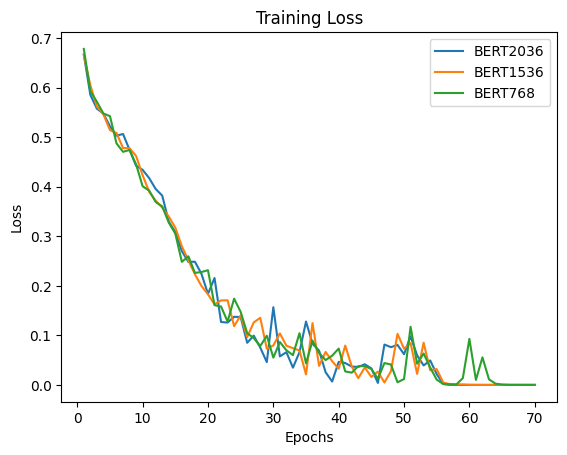

In [3456]:
training_loss3 = history3.history['loss']
training_loss2 = history2.history['loss']
training_loss1 = history1.history['loss']
# Create a range of epochs for x-axis
epochs = range(1, len(training_loss3) + 1)

# Plot training loss
plt.plot(epochs, training_loss3, label='BERT2036')
plt.plot(epochs, training_loss2, label='BERT1536')
plt.plot(epochs, training_loss1, label='BERT768')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [3457]:
performance_param = pd.DataFrame({'embedding':['BERT768','BERT1536','BERT2036'],'accuracy':[accuracy1,accuracy2,accuracy3],'precision':[precision1,precision2,precision3],'recall':[recall1,recall2,recall3],'f1_score':[f1,f2,f3]})

In [3458]:
performance_param

embedding  accuracy  precision  recall  f1_score
0   BERT768  0.709518   0.682119  0.7725  0.670886
1  BERT1536  0.697157   0.703412  0.6700  0.686300
2  BERT2036  0.689740   0.676123  0.7150  0.695018

In [4092]:
epch = 100
batchsz = 64

In [3701]:
# Define the model
model = Sequential([
    Dense(768, input_dim=768, activation='relu'),
    Dense(416, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history1 = model.fit(X1_train, y1_train, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history1.history['loss'], history1.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')


y1_pred_proba = model.predict (X1_test)

# Flatten y_pred to match the shape of y_test (if needed)

y1_pred = (y1_pred_proba > 0.5).astype(int)
y1_pred = y1_pred.flatten()
y1_pred = np.array(y1_pred)
y1_test = np.array(y1_test)

# Calculate accuracy
accuracy1 = accuracy_score(y1_test, y_pred)

# Calculate precision
precision1 = precision_score(y1_test, y_pred)

# Calculate recall
recall1 = recall_score(y1_test, y_pred)

# Calculate F1-score
f1 = f1_score(y1_test, y1_pred)

print(f'Accuracy: {accuracy1:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')
print(f'F1 Score: {f1:.4f}')


Epoch 1/100
30/30 [==============================] - 1s 6ms/step - loss: 0.6531 - accuracy: 0.6200
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 0.5892 - accuracy: 0.6910
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 0.5768 - accuracy: 0.6948
Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 0.5312 - accuracy: 0.7318
Epoch 5/100
30/30 [==============================] - 0s 6ms/step - loss: 0.5186 - accuracy: 0.7440
Epoch 6/100
30/30 [==============================] - 0s 9ms/step - loss: 0.4947 - accuracy: 0.7599
Epoch 7/100
30/30 [==============================] - 0s 7ms/step - loss: 0.4812 - accuracy: 0.7742
Epoch 8/100
30/30 [==============================] - 0s 7ms/step - loss: 0.4454 - accuracy: 0.7864
Epoch 9/100
30/30 [==============================] - 0s 7ms/step - loss: 0.4316 - accuracy: 0.7928
Epoch 10/100
30/30 [==============================] - 0s 6ms/step - loss: 0.3997 - accuracy: 0.8129
Epoch 11/

In [3702]:
print(f'Accuracy: {accuracy1:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.5612
Precision: 0.5466
Recall: 0.6600
F1 Score: 0.6439


In [3703]:

# Define the model
model = Sequential([
    Dense(1536, input_dim=1536, activation='relu'),
    Dense(848, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model.fit(X2_train, y2_train, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history2.history['loss'], history2.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')

y2_pred_proba = model.predict (X2_test)
# Flatten y_pred to match the shape of y_test (if needed)

y2_pred = (y2_pred_proba > 0.5).astype(int)
y2_pred = y2_pred.flatten()
y2_pred = np.array(y2_pred)
y2_test = np.array(y2_test)

# Calculate accuracy
accuracy2 = accuracy_score(y2_test, y2_pred)
# Calculate precision
precision2 = precision_score(y2_test, y2_pred)

# Calculate recall
recall2 = recall_score(y2_test, y2_pred)

# Calculate F1-score
f2 = f1_score(y2_test, y2_pred)

print(f'Accuracy: {accuracy2:.4f}')
print(f'Precision: {precision3:.4f}')
print(f'Recall: {recall2:.4f}')
print(f'F1 Score: {f2:.4f}')


Epoch 1/100
30/30 [==============================] - 1s 17ms/step - loss: 0.6957 - accuracy: 0.5745
Epoch 2/100
30/30 [==============================] - 1s 23ms/step - loss: 0.5937 - accuracy: 0.6863
Epoch 3/100
30/30 [==============================] - 1s 18ms/step - loss: 0.5576 - accuracy: 0.7144
Epoch 4/100
30/30 [==============================] - 1s 21ms/step - loss: 0.5348 - accuracy: 0.7239
Epoch 5/100
30/30 [==============================] - 1s 18ms/step - loss: 0.5172 - accuracy: 0.7371
Epoch 6/100
30/30 [==============================] - 0s 17ms/step - loss: 0.4984 - accuracy: 0.7472
Epoch 7/100
30/30 [==============================] - 1s 17ms/step - loss: 0.4839 - accuracy: 0.7530
Epoch 8/100
30/30 [==============================] - 0s 16ms/step - loss: 0.4497 - accuracy: 0.7880
Epoch 9/100
30/30 [==============================] - 1s 19ms/step - loss: 0.4178 - accuracy: 0.8029
Epoch 10/100
30/30 [==============================] - 1s 23ms/step - loss: 0.4057 - accuracy: 0.8113

In [3704]:

# Define the model
model = Sequential([
    Dense(2036, input_dim=2536, activation='relu'),
    Dense(1464, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model.fit(X3_train, y3_train, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history3.history['loss'], history3.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')


y3_pred_proba = model.predict (X3_test)

# Flatten y_pred to match the shape of y_test (if needed)
y3_pred = (y3_pred_proba > 0.5).astype(int)
y3_pred = y3_pred.flatten()


y3_pred = np.array(y3_pred)
y3_test = np.array(y3_test)

# Calculate accuracy
accuracy3 = accuracy_score(y3_test, y3_pred)

# Calculate precision
precision3 = precision_score(y3_test, y3_pred)

# Calculate recall
recall3 = recall_score(y3_test, y3_pred)

# Calculate F1-score
f3 = f1_score(y3_test, y3_pred)

print(f'Accuracy: {accuracy3:.4f}')
print(f'Precision: {precision3:.4f}')
print(f'Recall: {recall3:.4f}')
print(f'F1 Score: {f3:.4f}')


Epoch 1/100
30/30 [==============================] - 3s 82ms/step - loss: 0.6643 - accuracy: 0.6126
Epoch 2/100
30/30 [==============================] - 2s 54ms/step - loss: 0.5754 - accuracy: 0.7043
Epoch 3/100
30/30 [==============================] - 1s 44ms/step - loss: 0.5530 - accuracy: 0.7228
Epoch 4/100
30/30 [==============================] - 1s 43ms/step - loss: 0.5355 - accuracy: 0.7287
Epoch 5/100
30/30 [==============================] - 1s 44ms/step - loss: 0.5145 - accuracy: 0.7329
Epoch 6/100
30/30 [==============================] - 2s 56ms/step - loss: 0.4903 - accuracy: 0.7647
Epoch 7/100
30/30 [==============================] - 1s 47ms/step - loss: 0.4660 - accuracy: 0.7711
Epoch 8/100
30/30 [==============================] - 1s 48ms/step - loss: 0.4565 - accuracy: 0.7928
Epoch 9/100
30/30 [==============================] - 2s 52ms/step - loss: 0.4422 - accuracy: 0.7848
Epoch 10/100
30/30 [==============================] - 1s 39ms/step - loss: 0.4189 - accuracy: 0.8092

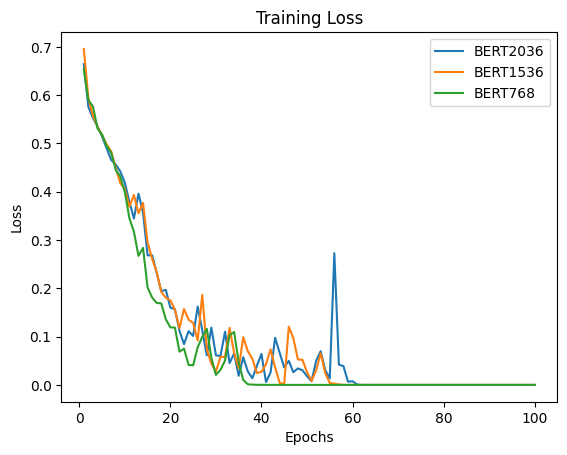

In [3705]:
training_loss3 = history3.history['loss']
training_loss2 = history2.history['loss']
training_loss1 = history1.history['loss']
# Create a range of epochs for x-axis
epochs = range(1, len(training_loss3) + 1)

# Plot training loss
plt.plot(epochs, training_loss3, label='BERT2036')
plt.plot(epochs, training_loss2, label='BERT1536')
plt.plot(epochs, training_loss1, label='BERT768')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [3466]:
performance_param = pd.DataFrame({'embedding':['BERT768','BERT1536','BERT2036'],'accuracy':[accuracy1,accuracy2,accuracy3],'precision':[precision1,precision2,precision3],'recall':[recall1,recall2,recall3],'f1_score':[f1,f2,f3]})

In [3706]:
performance_param

embedding  accuracy  precision  recall  f1_score
0   BERT768  0.709518   0.682119  0.7725  0.666667
1  BERT1536  0.672435   0.678100  0.6425  0.659820
2  BERT2036  0.669963   0.667506  0.6625  0.664994

In [4107]:
def norma(x):
    mean = np.mean(x, axis=0)
    std_dev = np.std(x, axis=0)
    return (x-mean)/std_dev

X1_train_norm = norma(X1_train)
X1_test_norm = (X1_test-np.mean(X1_train,axis=0))/np.std(X1_train,axis=0)
X2_train_norm = norma(X2_train)
X2_test_norm = (X2_test-np.mean(X2_train,axis=0))/np.std(X2_train,axis=0)
X3_train_norm = norma(X3_train)
X3_test_norm = (X3_test-np.mean(X3_train,axis=0))/np.std(X3_train,axis=0)
X4_train_norm = norma(X4_train)
X4_test_norm = (X4_test-np.mean(X4_train,axis=0))/np.std(X4_train,axis=0)
X5_train_norm = norma(X5_train)
X5_test_norm = (X5_test-np.mean(X5_train,axis=0))/np.std(X5_train,axis=0)

In [4114]:
epch = 70
batchsz = 48

In [3756]:
# Define the model
model = Sequential([
    Dense(768, input_dim=768, activation='relu'),
    Dense(416, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history1 = model.fit(X1_train_norm, y1_train, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history1.history['loss'], history1.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')


y1_pred_proba = model.predict (X1_test_norm)

# Flatten y_pred to match the shape of y_test (if needed)

y1_pred = (y1_pred_proba > 0.5).astype(int)
y1_pred = y1_pred.flatten()
y1_pred = np.array(y1_pred)
y1_test = np.array(y1_test)

# Calculate accuracy
accuracy1 = accuracy_score(y1_test, y_pred)

# Calculate precision
precision1 = precision_score(y1_test, y_pred)

# Calculate recall
recall1 = recall_score(y1_test, y_pred)

# Calculate F1-score
f1 = f1_score(y1_test, y1_pred)

print(f'Accuracy: {accuracy1:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')
print(f'F1 Score: {f1:.4f}')


Epoch 1/70
40/40 [==============================] - 1s 7ms/step - loss: 0.6205 - accuracy: 0.6799
Epoch 2/70
40/40 [==============================] - 0s 5ms/step - loss: 0.4572 - accuracy: 0.7785
Epoch 3/70
40/40 [==============================] - 0s 6ms/step - loss: 0.3348 - accuracy: 0.8601
Epoch 4/70
40/40 [==============================] - 0s 6ms/step - loss: 0.2605 - accuracy: 0.8961
Epoch 5/70
40/40 [==============================] - 0s 4ms/step - loss: 0.1586 - accuracy: 0.9359
Epoch 6/70
40/40 [==============================] - 0s 5ms/step - loss: 0.1536 - accuracy: 0.9422
Epoch 7/70
40/40 [==============================] - 0s 5ms/step - loss: 0.0778 - accuracy: 0.9687
Epoch 8/70
40/40 [==============================] - 0s 5ms/step - loss: 0.1144 - accuracy: 0.9571
Epoch 9/70
40/40 [==============================] - 0s 5ms/step - loss: 0.0501 - accuracy: 0.9820
Epoch 10/70
40/40 [==============================] - 0s 5ms/step - loss: 0.0647 - accuracy: 0.9815
Epoch 11/70
40/40 [

In [3755]:

# Define the model
model = Sequential([
    Dense(1536, input_dim=1536, activation='relu'),
    Dense(848, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model.fit(X2_train_norm, y2_train, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history2.history['loss'], history2.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')

y2_pred_proba = model.predict (X2_test_norm)
# Flatten y_pred to match the shape of y_test (if needed)

y2_pred = (y2_pred_proba > 0.5).astype(int)
y2_pred = y2_pred.flatten()
y2_pred = np.array(y2_pred)
y2_test = np.array(y2_test)

# Calculate accuracy
accuracy2 = accuracy_score(y2_test, y2_pred)
# Calculate precision
precision2 = precision_score(y2_test, y2_pred)

# Calculate recall
recall2 = recall_score(y2_test, y2_pred)

# Calculate F1-score
f2 = f1_score(y2_test, y2_pred)

print(f'Accuracy: {accuracy2:.4f}')
print(f'Precision: {precision3:.4f}')
print(f'Recall: {recall2:.4f}')
print(f'F1 Score: {f2:.4f}')


Epoch 1/70
40/40 [==============================] - 1s 11ms/step - loss: 0.6293 - accuracy: 0.6661
Epoch 2/70
40/40 [==============================] - 0s 12ms/step - loss: 0.4867 - accuracy: 0.7652
Epoch 3/70
40/40 [==============================] - 1s 19ms/step - loss: 0.4039 - accuracy: 0.8166
Epoch 4/70
40/40 [==============================] - 1s 17ms/step - loss: 0.2914 - accuracy: 0.8755
Epoch 5/70
40/40 [==============================] - 1s 23ms/step - loss: 0.2245 - accuracy: 0.9078
Epoch 6/70
40/40 [==============================] - 1s 16ms/step - loss: 0.1774 - accuracy: 0.9290
Epoch 7/70
40/40 [==============================] - 1s 16ms/step - loss: 0.1538 - accuracy: 0.9364
Epoch 8/70
40/40 [==============================] - 1s 19ms/step - loss: 0.1180 - accuracy: 0.9497
Epoch 9/70
40/40 [==============================] - 1s 21ms/step - loss: 0.1129 - accuracy: 0.9603
Epoch 10/70
40/40 [==============================] - 1s 20ms/step - loss: 0.0556 - accuracy: 0.9772
Epoch 11/

In [3767]:

# Define the model
model = Sequential([
    Dense(2536, input_dim=2536, activation='relu'),
    Dense(1464, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model.fit(X3_train_norm, y3_train, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history3.history['loss'], history3.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')


y3_pred_proba = model.predict (X3_test_norm)

# Flatten y_pred to match the shape of y_test (if needed)
y3_pred = (y3_pred_proba > 0.5).astype(int)
y3_pred = y3_pred.flatten()


y3_pred = np.array(y3_pred)
y3_test = np.array(y3_test)

# Calculate accuracy
accuracy3 = accuracy_score(y3_test, y3_pred)

# Calculate precision
precision3 = precision_score(y3_test, y3_pred)

# Calculate recall
recall3 = recall_score(y3_test, y3_pred)

# Calculate F1-score
f3 = f1_score(y3_test, y3_pred)

print(f'Accuracy: {accuracy3:.4f}')
print(f'Precision: {precision3:.4f}')
print(f'Recall: {recall3:.4f}')
print(f'F1 Score: {f3:.4f}')


Epoch 1/70
40/40 [==============================] - 3s 42ms/step - loss: 0.7208 - accuracy: 0.6497
Epoch 2/70
40/40 [==============================] - 2s 40ms/step - loss: 0.5546 - accuracy: 0.7266
Epoch 3/70
40/40 [==============================] - 2s 42ms/step - loss: 0.5135 - accuracy: 0.7578
Epoch 4/70
40/40 [==============================] - 2s 39ms/step - loss: 0.4510 - accuracy: 0.7944
Epoch 5/70
40/40 [==============================] - 2s 45ms/step - loss: 0.3992 - accuracy: 0.8161
Epoch 6/70
40/40 [==============================] - 2s 39ms/step - loss: 0.3647 - accuracy: 0.8426
Epoch 7/70
40/40 [==============================] - 2s 39ms/step - loss: 0.2797 - accuracy: 0.8887
Epoch 8/70
40/40 [==============================] - 2s 43ms/step - loss: 0.2611 - accuracy: 0.8839
Epoch 9/70
40/40 [==============================] - 2s 43ms/step - loss: 0.2497 - accuracy: 0.8961
Epoch 10/70
40/40 [==============================] - 2s 39ms/step - loss: 0.2260 - accuracy: 0.9147
Epoch 11/

In [4120]:

# 7-Layer Deep Learning model
model = Sequential([
    Dense(2536, input_dim=2536, activation='relu'),
    Dense(1464, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history4 = model.fit(X4_train_norm, y4_train, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history3.history['loss'], history3.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')


y4_pred_proba = model.predict (X4_test_norm)

# Flatten y_pred to match the shape of y_test (if needed)
y4_pred = (y4_pred_proba > 0.5).astype(int)
y4_pred = y4_pred.flatten()


y4_pred = np.array(y4_pred)
y4_test = np.array(y4_test)

# Calculate accuracy
accuracy4 = accuracy_score(y4_test, y4_pred)

# Calculate precision
precision4 = precision_score(y4_test, y4_pred)

# Calculate recall
recall4 = recall_score(y4_test, y4_pred)

# Calculate F1-score
f4 = f1_score(y4_test, y4_pred)

print(f'Accuracy: {accuracy3:.4f}')
print(f'Precision: {precision3:.4f}')
print(f'Recall: {recall3:.4f}')
print(f'F1 Score: {f3:.4f}')


Epoch 1/70
40/40 [==============================] - 3s 56ms/step - loss: 0.6720 - accuracy: 0.6433
Epoch 2/70
40/40 [==============================] - 2s 42ms/step - loss: 0.5431 - accuracy: 0.7191
Epoch 3/70
40/40 [==============================] - 2s 41ms/step - loss: 0.4721 - accuracy: 0.7817
Epoch 4/70
40/40 [==============================] - 2s 41ms/step - loss: 0.4176 - accuracy: 0.8182
Epoch 5/70
40/40 [==============================] - 2s 41ms/step - loss: 0.3525 - accuracy: 0.8453
Epoch 6/70
40/40 [==============================] - 2s 41ms/step - loss: 0.3114 - accuracy: 0.8622
Epoch 7/70
40/40 [==============================] - 2s 42ms/step - loss: 0.2504 - accuracy: 0.9020
Epoch 8/70
40/40 [==============================] - 2s 39ms/step - loss: 0.2257 - accuracy: 0.9163
Epoch 9/70
40/40 [==============================] - 2s 39ms/step - loss: 0.1948 - accuracy: 0.9237
Epoch 10/70
40/40 [==============================] - 2s 39ms/step - loss: 0.1728 - accuracy: 0.9406
Epoch 11/

In [4097]:
embedding_bert_patt3.shape

(7000, 2936)

In [4485]:
X4_train.shape

(1887, 2536)

In [4100]:
1536-2936

-1400

In [4121]:

# Define the model
model = Sequential([
    Dense(2936, input_dim=2936, activation='relu'),
    Dense(1464, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history5 = model.fit(X5_train_norm, y5_train, epochs=epch, batch_size=batchsz)

# Display training loss and accuracy over epochs
for epoch, (loss, accuracy) in enumerate(zip(history5.history['loss'], history5.history['accuracy']), 1):
    print(f'Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')


y5_pred_proba = model.predict (X5_test_norm)

# Flatten y_pred to match the shape of y_test (if needed)
y5_pred = (y5_pred_proba > 0.5).astype(int)
y5_pred = y5_pred.flatten()


y5_pred = np.array(y5_pred)
y5_test = np.array(y5_test)

# Calculate accuracy
accuracy5 = accuracy_score(y5_test, y5_pred)

# Calculate precision
precision5 = precision_score(y5_test, y5_pred)

# Calculate recall
recall5 = recall_score(y5_test, y5_pred)

# Calculate F1-score
f5 = f1_score(y5_test, y5_pred)

print(f'Accuracy: {accuracy3:.4f}')
print(f'Precision: {precision3:.4f}')
print(f'Recall: {recall3:.4f}')
print(f'F1 Score: {f3:.4f}')


Epoch 1/70
40/40 [==============================] - 3s 60ms/step - loss: 0.8090 - accuracy: 0.6015
Epoch 2/70
40/40 [==============================] - 2s 55ms/step - loss: 0.5504 - accuracy: 0.7303
Epoch 3/70
40/40 [==============================] - 2s 42ms/step - loss: 0.4780 - accuracy: 0.7605
Epoch 4/70
40/40 [==============================] - 2s 42ms/step - loss: 0.4445 - accuracy: 0.7992
Epoch 5/70
40/40 [==============================] - 2s 54ms/step - loss: 0.3740 - accuracy: 0.8331
Epoch 6/70
40/40 [==============================] - 2s 50ms/step - loss: 0.3289 - accuracy: 0.8606
Epoch 7/70
40/40 [==============================] - 2s 50ms/step - loss: 0.3013 - accuracy: 0.8776
Epoch 8/70
40/40 [==============================] - 2s 50ms/step - loss: 0.2814 - accuracy: 0.8850
Epoch 9/70
40/40 [==============================] - 2s 48ms/step - loss: 0.2322 - accuracy: 0.9062
Epoch 10/70
40/40 [==============================] - 2s 47ms/step - loss: 0.1930 - accuracy: 0.9258
Epoch 11/

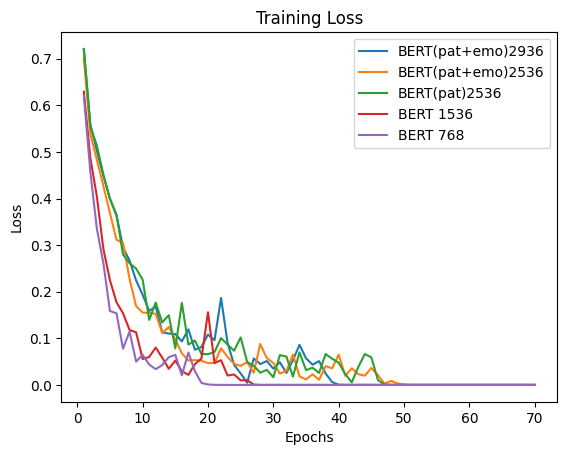

In [4116]:
training_loss5 = history5.history['loss']
training_loss4 = history4.history['loss']
training_loss3 = history3.history['loss']
training_loss2 = history2.history['loss']
training_loss1 = history1.history['loss']
# Create a range of epochs for x-axis
epochs = range(1, len(training_loss3) + 1)

# Plot training loss
plt.plot(epochs, training_loss5, label='BERT(pat+emo)2936')
plt.plot(epochs, training_loss4, label='BERT(pat+emo)2536')
plt.plot(epochs, training_loss3, label='BERT(pat)2536')
plt.plot(epochs, training_loss2, label='BERT 1536')
plt.plot(epochs, training_loss1, label='BERT 768')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

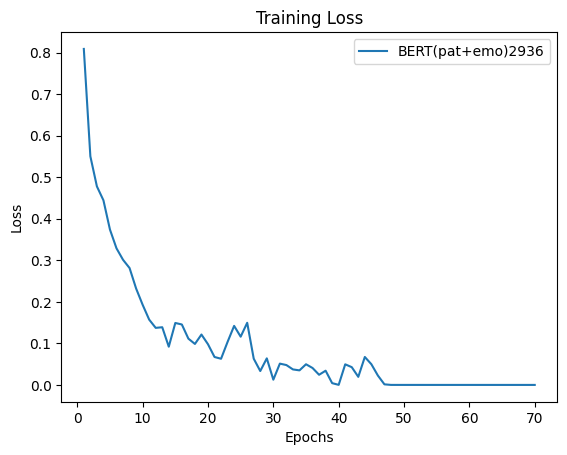

In [4122]:
training_loss5 = history5.history['loss']

# Create a range of epochs for x-axis
epochs = range(1, len(training_loss3) + 1)

# Plot training loss
plt.plot(epochs, training_loss5, label='BERT(pat+emo)2936')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [4117]:
performance_param = pd.DataFrame({'embedding':['BERT768','BERT1536','BERT2536(p)','BERT2536(ep)','BERT2936(ep)'],'accuracy':[accuracy1,accuracy2,accuracy3,accuracy4,accuracy5],'precision':[precision1,precision2,precision3,precision4,precision5],'recall':[recall1,recall2,recall3,recall4,recall5],'f1_score':[f1,f2,f3,f4,f5]})

In [4321]:
performance_param

embedding  accuracy  precision  recall  f1_score
0       BERT768  0.550062   0.540000  0.6075  0.679341
1      BERT1536  0.688504   0.685930  0.6825  0.684211
2   BERT2536(p)  0.702101   0.717808  0.6550  0.684967
3  BERT2536(ep)  0.707046   0.689095  0.7425  0.714801
4  BERT2936(ep)  0.667491   0.660147  0.6750  0.667491

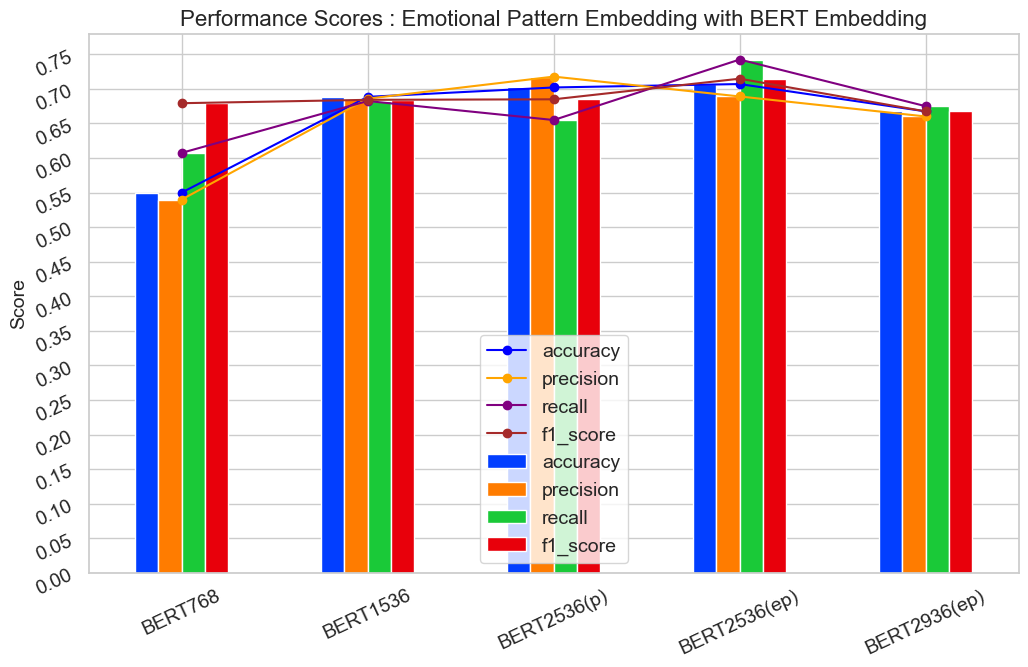

In [4483]:
sns.set_palette("bright")
zz = performance_param
ax = zz.plot(y=['accuracy','precision','recall','f1_score'], x='embedding', kind='bar',figsize=(12,7))
ax.legend(['accuracy','precision','recall','f1_score'])
ax.set_xlabel('')  # Change label and font size
ax.set_ylabel('Score', fontsize=14)  # Change label and font size
ax.set_title('Performance Scores : Emotional Pattern Embedding with BERT Embedding', fontsize=16)
y_ticks = [(i*.05) for i in range(0,20)]
ax.set_yticks(y_ticks)
ax.yaxis.grid(True)
# Increase font size of tick labels
ax.plot(zz['embedding'], zz['accuracy'], color='blue', marker='o', label='accuracy')
ax.plot(zz['embedding'], zz['precision'], color='orange', marker='o', label='precision')
ax.plot(zz['embedding'], zz['recall'], color='purple', marker='o', label='recall')
ax.plot(zz['embedding'], zz['f1_score'], color='brown', marker='o', label='f1_score')
#ax.plot(zz['Dataset'], zz['TextBlob'], color='red', marker='o', label='BERT')
#ax.plot(zz['Dataset'], zz['VADER'], color='green', marker='o', label='BERT')
ax.tick_params(rotation = 25,axis='both', labelsize=14)
ax.legend(loc = 'lower center',fontsize=14)



<Axes: >

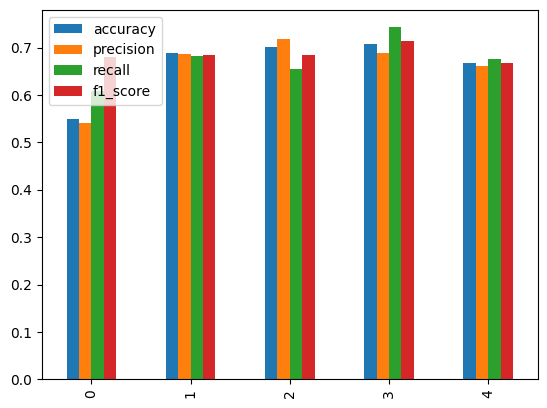

In [4119]:
performance_param.plot(kind='bar')


In [3803]:
C_value = 0.1  # Adjust this value as needed
logistic_reg = LogisticRegression(C=C_value)

# Train the model
logistic_reg.fit(X_train_ss, y_train_ss)
y_ss_pred_proba = logistic_reg.predict_log_proba(X_test_ss)
# Make predictions on the test set
y_pred = logistic_reg.predict(X_test_ss)

# Calculate accuracy
accuracy = accuracy_score(y_test_ss, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5611866501854141


In [3806]:
y3_train_proba = model.predict (X3_train_norm)   # from BERT 2036
y3_pred_proba = model.predict (X3_test_norm)
y_ss_train_proba = logistic_reg.predict_log_proba(X_train_ss)  #ss is single single , 10 for patterns and 9 for emotions
y_ss_pred_proba = logistic_reg.predict_log_proba(X_test_ss)
y_ss_stack_train = y_ss_train_proba[:,0].reshape(1887,1) # from LR 19 input
y_ss_stack_pred = y_ss_pred_proba[:,0].reshape(809,1)

26/26 [==============================] - 0s 6ms/step


In [3808]:
train_stack = np.append(y_ss_stack_train,y3_train_proba,axis=1)
train_stack.shape

(1887, 2)

In [3810]:
test_stack = np.append(y_ss_stack_pred,y3_pred_proba,axis=1)
test_stack.shape

(809, 2)

In [3811]:
C_value = 0.1  # Adjust this value as needed
logistic_reg = LogisticRegression(C=C_value)

# Train the model
logistic_reg.fit(train_stack, y_train_ss)  # fitting data to the train stack 
y_pred_stack = logistic_reg.predict(test_stack)


In [3812]:
accuracy_score(y_pred_stack,y_test_ss)

0.7021013597033374

In [3813]:
precision_score(y_pred_stack,y_test_ss)

0.655

In [3814]:
f1_score(y_pred_stack,y_test_ss)

0.6849673202614378

## Mutual Information and Feature Importance Analysis

In [4314]:
pat_feature = pd.Series(pat_wt_embd)
pat_feature = pat_feature/len_pat
pat_feature

ppn       0.158571
ppp       0.151429
pnp       0.150000
nnp       0.147143
npn       0.117143
nnn       0.104286
pnnp      0.072857
nppn      0.062857
ppnnpp    0.020000
nnppnn    0.015714
dtype: float64

In [4315]:
emo_feature = pd.Series(emo_wt_embd)
emo_feature = emo_feature/len_emo
emo_feature

positive        0.168571
trust           0.141429
anticipation    0.125714
negative        0.121429
joy             0.120000
sadness         0.094286
surprise        0.090000
anger           0.071429
disgust         0.068571
dtype: float64

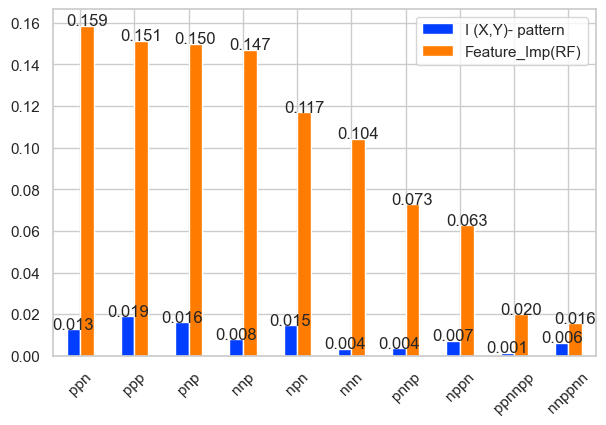

In [4523]:
X_Hx = data_amazon_json_df_pat.loc[xxrel][pattern_list]
y_Hx = data_amazon_json_df_pat.loc[xxrel]['helpfulness']
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_Hx, y_Hx)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_Hx.columns
mututal_info = mutual_info.sort_values(ascending=False)
df = pd.DataFrame({'I (X,Y)- pattern': mutual_info, 'Feature_Imp(RF)': pat_feature})

# Plot the DataFrame
ax = df.sort_values(by = 'Feature_Imp(RF)',ascending = False).plot(kind='bar',figsize=(7, 4.5))

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.xticks(rotation=45)
plt.show()


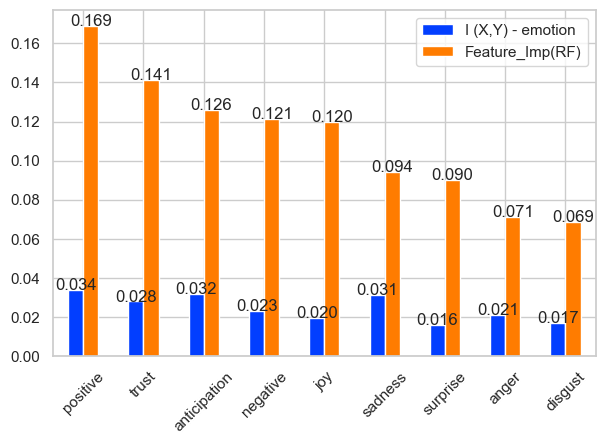

In [4525]:
X_Hx = data_amazon_json_df_pat_nrc.loc[xxrel][emo_list]
y_Hx = data_amazon_json_df_pat_nrc.loc[xxrel]['helpfulness']

X_Hx = X_Hx.fillna(0)
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_Hx, y_Hx)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_Hx.columns
mututal_info = mutual_info.sort_values(ascending=False)
df = pd.DataFrame({'I (X,Y) - emotion': mutual_info, 'Feature_Imp(RF)': emo_feature})

# Plot the DataFrame
ax = df.sort_values(by = 'Feature_Imp(RF)',ascending = False).plot(kind='bar',figsize=(7,4.5))

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.xticks(rotation=45)
plt.show()

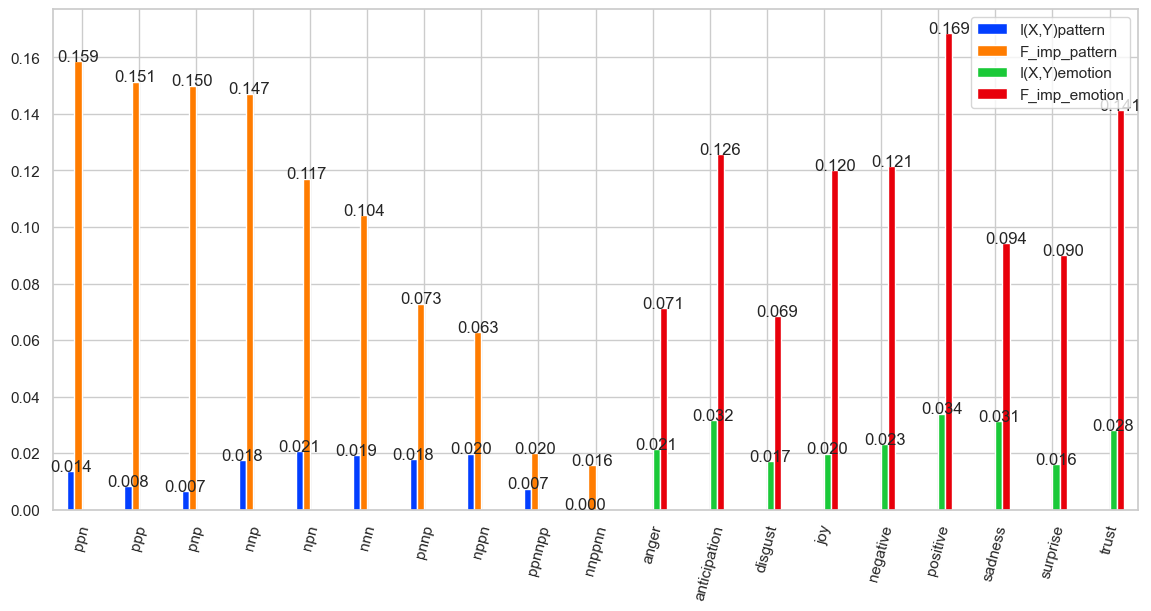

In [4545]:
X_Hx = data_amazon_json_df_pat.loc[xxrel][pattern_list]
y_Hx = data_amazon_json_df_pat.loc[xxrel]['helpfulness']
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info1 = mutual_info_classif(X_Hx, y_Hx)
mutual_info1 = pd.Series(mutual_info1)
mutual_info1.index = X_Hx.columns
mututal_info1 = mutual_info1.sort_values(ascending=False)
df = pd.DataFrame({'I(X,Y)pattern': mutual_info1,'F_imp_pattern': pat_feature,'I(X,Y)emotion':mutual_info,'F_imp_emotion':emo_feature})

# Plot the DataFrame
ax = df.sort_values(by = 'F_imp_pattern',ascending = False).plot(kind='bar',figsize=(14, 6.5))

# Add values on top of the bars
for p in ax.patches:
    if p.get_height()>0:
        ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.xticks(rotation=75)
plt.show()

In [4537]:
if p.get_height()>0:
     print(1)
else:
     print(0)

1


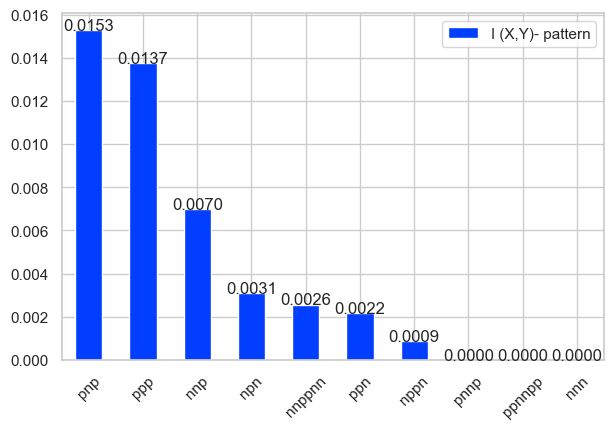

In [4414]:
X_Hx = data_amazon_json_df_pat.loc[bal_indices][pattern_list]
y_Hx = data_amazon_json_df_pat.loc[bal_indices]['helpfulness']
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_Hx, y_Hx)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_Hx.columns
mututal_info = mutual_info.sort_values(ascending=False)
df = pd.DataFrame({'I (X,Y)- pattern': mutual_info}) #, 'Feature_Imp(RF)': pat_feature})

# Plot the DataFrame
ax = df.sort_values(by = 'I (X,Y)- pattern',ascending = False).plot(kind='bar',figsize=(7, 4.5))

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.xticks(rotation=45)
plt.show()

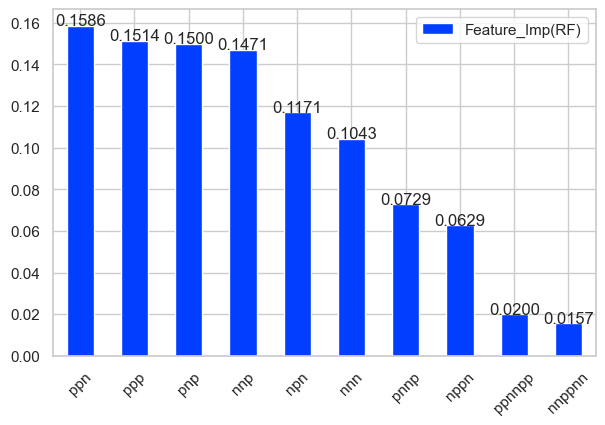

In [4417]:
X_Hx = data_amazon_json_df_pat.loc[bal_indices][pattern_list]
y_Hx = data_amazon_json_df_pat.loc[bal_indices]['helpfulness']
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_Hx, y_Hx)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_Hx.columns
mututal_info = mutual_info.sort_values(ascending=False)
df = pd.DataFrame({'Feature_Imp(RF)': pat_feature})

# Plot the DataFrame
ax = df.sort_values(by = 'Feature_Imp(RF)',ascending = False).plot(kind='bar',figsize=(7, 4.5))

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.xticks(rotation=45)
plt.show()

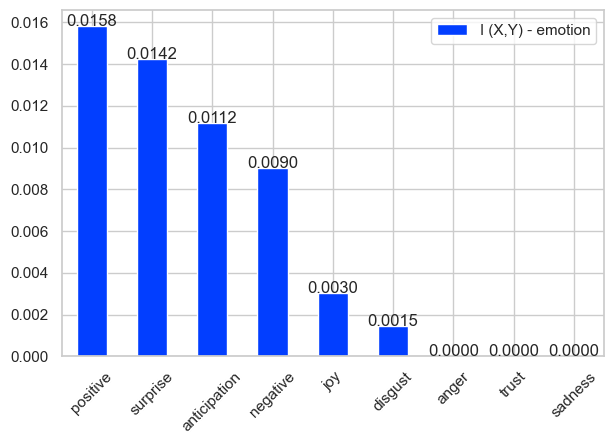

In [4416]:
X_Hx = data_amazon_json_df_pat_nrc.loc[bal_indices][emo_list]
y_Hx = data_amazon_json_df_pat_nrc.loc[bal_indices]['helpfulness']

X_Hx = X_Hx.fillna(0)
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_Hx, y_Hx)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_Hx.columns
mututal_info = mutual_info.sort_values(ascending=False)
df = pd.DataFrame({'I (X,Y) - emotion': mutual_info}) #, 'Feature_Imp(RF)': emo_feature})

# Plot the DataFrame
ax = df.sort_values(by = 'I (X,Y) - emotion',ascending = False).plot(kind='bar',figsize=(7,4.5))

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.xticks(rotation=45)
plt.show()

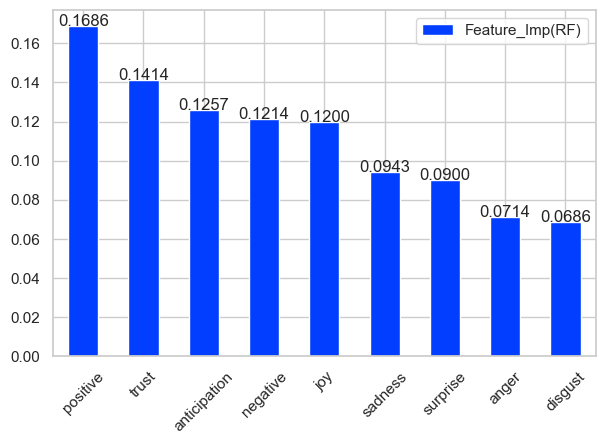

In [4421]:

df = pd.DataFrame({'Feature_Imp(RF)': emo_feature})

# Plot the DataFrame
ax = df.sort_values(by = 'Feature_Imp(RF)',ascending = False).plot(kind='bar',figsize=(7, 4.5))

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.xticks(rotation=45)
plt.show()

array([0.0719596 , 0.14129688, 0.08982293, 0.16797673, 0.12084422,
       0.09409701, 0.06924912, 0.11928702, 0.1254665 ])

In [4504]:
y_train_ss.shape

(1887,)

In [4506]:
y5_train.shape

(1887,)

In [4511]:
np.unique(y5_test, return_counts=True)

(array([0, 1]), array([409, 400]))